# Progetto di Introduzione ad analisi dati
# Analisi sulla felicità in rapporto ad altri indici

## 1. Contesto

Una ricerca di sociologia ed analisi economica chiede di analizzare la felicità dichiarata da una raccolta di dati effettuata nei vari stati del mondo tramite un "censimento".
Si vuole provare l'effettiva veridicità di quello che viene dichiarato e vedere come si possono interfacciare i dati principali sulla felicità ad altri dataset e contesti sempre basati sulla raccolta di dati con identificazione in base allo stato-regione di appartenenza.
Si vogliono inoltre creare dei regressori e classificatori per predire possibili outcome per i prossimi anni in base ai dati forniti dai vari dataset, in particolare si vuole vedere la relazione tra la felicità dichiarata e l'inequalità di una regione, oltre a trovare un modo di classificare delle etichette di inequalità.
Dopo aver tratto delle conclusioni sia nell'analisi di un regressore che di un classificatore, si vuole inoltre trovare il legame tra i vari stati tramite degli algoritmi di clustering, quindi aggiungere un attributo alle regioni ed anni(che costituiscono la chiave primari dei dataset) che identifichi l'appartenenza ad un cluster.

## 2. Richieste e Obiettivi

1. Descrizione dei vari dataset 
2. Trovare le associazioni nel dataset originale 
3. trovare altre associazioni con altri dati(demografici, dipendenti dagli stati, etc..)
4. Predirre gli score di felicità effettuando una analisi di regressione e dipendenza tra le varie feature.
5. metodo ensemble di creazione etichette per classificazione tramite clustering e poi classificazione di queste etichette.
5. classificazione di inequalità tramite Bayes, SVM, alberi decisionali, etc... 
6. riduzione della dimensionalità dei dati tramite LDA, PCA.
7. controllo di validità e consistenza dei modelli e dei dati.
8. Clustering generale per la ricerca di stati/regioni che siano simili.

## 3. Raccolta dei dati

I dati utilizzati sono stati presi in [world happyness](https://www.kaggle.com/unsdsn/world-happiness), in [suicide rates](https://ourworldindata.org/suicide), in [infant mortality](https://ourworldindata.org/grapher/infant-mortality?region=World) ed in [income inequality](https://ourworldindata.org/income-inequality).
Durante la pulizia iniziale dei dati sono state sistemate delle informazioni riguardanti dati non esistenti ed alcuni errori di conversione, sono state sistemate le etichette per facilitare i vari merge tra dataset provenienti da sorgenti diverse, che avevano bisogno di una correzione leggera.

## 3.1 Esplorazione dei dati

In [1]:
import pandas as pd
import numpy as np

In [2]:
# visualizzazione dati
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [3]:
dataset = pd.read_csv("dati/worldHappyness/2015.csv")
for i in range(6,9):
    dataset = pd.concat([dataset,pd.read_csv("dati/worldHappyness/201"+str(i)+".csv")])

Questo dataset contiene la lista di stati nella classifica della world happiness.
World Happiness utilizza i dati che provengono dal [Gallup World Poll](https://www.gallup.com/analytics/318875/global-research.aspx). Le classifiche si basano sulle risposte alla principale domanda di valutazione della vita posta in un sondaggio. Questa è chiamata scala Cantril: chiede agli intervistati di pensare a una scala, con la migliore vita possibile per loro essendo un 10 e la peggiore vita possibile essendo uno 0. Gli viene quindi chiesto di valutare la propria vita attuale da 0 a  10. Le classifiche provengono da campioni rappresentativi a livello nazionale, queste si basano interamente sui punteggi del sondaggio, utilizzando i pesi Gallup per rendere rappresentative le stime. Le feature secondarie mostrano la misura stimata in cui ciascuno dei sei fattori: livelli di PIL (GDP), aspettativa di vita, generosità, sostegno sociale, libertà e corruzione(i metodi di calcolo di questi indici non sono stati dichiarati, o sono nascosti in qualche FAQ). Per maggiori informazioni sull'origine dei dati o su alcuni indici utilizzati visitare [FAQ](https://worldhappiness.report/faq).

Per la maggior parte dell'analisi verranno utilizzati i dati del 2017, ma ragionamenti simili possono essere fatti per gli altri anni(per studi come regressione o predizine in base a feature-predittori, verrà fatto uno studio sul singolo anno).

In [4]:
dataset2017=pd.read_csv("dati/worldHappyness/2017.csv")
dataset2017.isnull().values.any()

False

### 3.1.1 Numerosità dei dataset sulla felicità

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 626 entries, 0 to 155
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Country                    626 non-null    object 
 1   Region                     315 non-null    object 
 2   rank                       626 non-null    int64  
 3   Score                      626 non-null    float64
 4   Standard_Error             158 non-null    float64
 5   GDP                        626 non-null    float64
 6   Family                     315 non-null    float64
 7   life_Expectancy            626 non-null    float64
 8   FreedomOflife              626 non-null    float64
 9   corruption                 625 non-null    float64
 10  Generosity                 626 non-null    float64
 11  DystopiaResidual           625 non-null    float64
 12  year                       626 non-null    int64  
 13  Social_support             626 non-null    float64

L'inferenza dei tipi delle feature effettuata da pandas è esatta per la maggior parte dei parametri, dato che le feature identificate come **object** sono delle stringhe(e sarebbe meglio utilizzare un tipo più specifico per future manipolazioni dei dati).
Durante questa analisi dati non verranno sfruttate particolarmente le feature sopracitate, ma verranno utilizzate solo per identificare la provenienza del dato, quindi verranno lasciate come object, in alternativa si potrebbe fare un cast a stringe oppure utilizzare i nuovi tipi di pandas **StringDtype**.

Nel dataset risultante sono presenti valori nulli o NAN (come si può vedere dalla seguente istruzione) dato che lo studio che ha condotto la raccolta dei dati ha aggiunto o tolto alcuni attributi durante gli anni(intervallo di confidenza dello score, deviazione standard dello score, o altre feature che variano di anno in anno), quindi analisi su attributi (per tutti gli anni) saranno fatte solo sulle feature comuni, mentre modellazioni specifiche per un anno veranno costruite sulla base degli attributi disponibili per quell'anno.

In [6]:
dataset.isnull().values.any()

True

In [7]:
dataset2017.count()

Country                      155
rank                         155
Score                        155
Upper_Confidence_Interval    155
Lower_Confidence_Interval    155
GDP                          155
Social_support               155
life_Expectancy              155
FreedomOflife                155
Generosity                   155
corruption                   155
DystopiaResidual             155
year                         155
dtype: int64

Il 2017 fornisce una buona quantità di feature, ed è l'ultimo anno in cui vengono forniti gli intervalli di confidenza per lo score di felicità.

Dato che non verrà visto fino all'analisi tramite regressione, si vede il boxplot degli score di felicità sulla base annuale.

<AxesSubplot:title={'center':'Score'}, xlabel='year'>

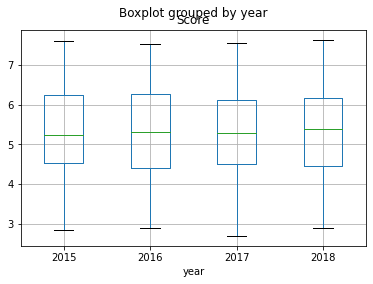

In [8]:
dataset.boxplot(column="Score",by="year")

Durante gli anni lo score di felicità sembra essere restato lo stesso.

## 3.1.2 Plotting sulla mappa dei dati sugli score della felicità

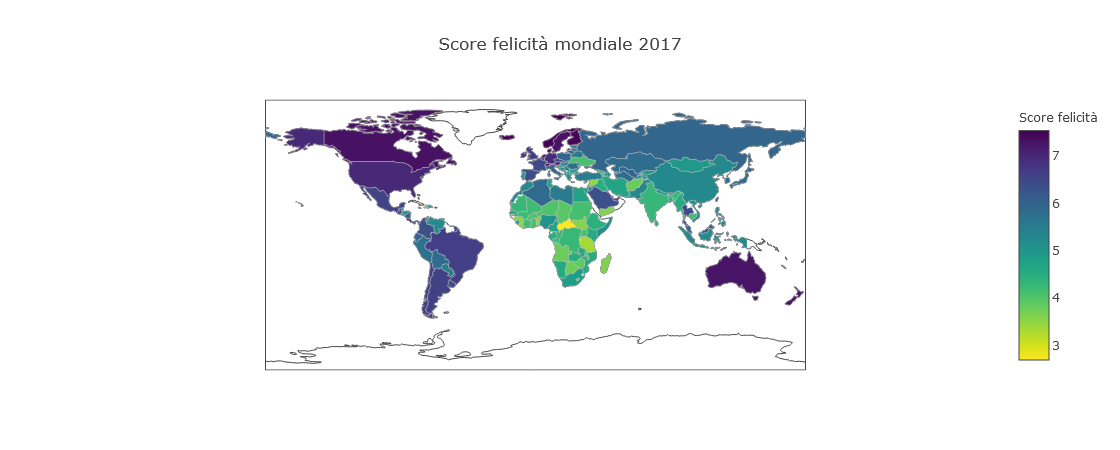

In [9]:
from plotly.offline import  init_notebook_mode,iplot
count = [ dict(
        # tipo di mappa
        type = 'choropleth',
        locations = dataset2017['Country'],
        locationmode='country names',
        z = dataset2017['Score'],
        text = dataset2017['Country'],
        colorscale = 'Viridis',
        autocolorscale = False,
        reversescale = True,
        # colorazione
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        # legenda colori
        colorbar = dict(
            autotick =False,
            title = 'Score felicità'),
      ) ]
# create layout for gragh
layout = dict(
    title = 'Score felicità mondiale 2017',
    # 
    geo = dict(
        showframe = True,
        showcoastlines = True,
        projection = dict(
            type = 'Mercator'
        )
    )
)
# prepare the fig parameter
fig = dict( data=count, layout=layout )
iplot( fig, validate=False, filename='d3-world-map' )

In [10]:
suicides = pd.read_csv("dati/worldHappyness/suicidecorretti.csv")
suicidesByAge = pd.read_csv("dati/worldHappyness/suicide-death-rate-by-age.csv")
suicidesBySex = pd.read_csv("dati/worldHappyness/male-vs-female-suicide.csv").drop("Continent",1).dropna()

Questo dataset contiene i tassi di suicidi per stato-regione(ogni 100000 individui) standardizzati in base alle fasce di età , in particolare quello che viene fatto dai fautori della raccolta (world health organization) è il seguente calcolo.
\\[DRS_a=\sum r_{ia}(\frac{n_{is}}{\sum_i n_{is}})\\]
Dove n<sub>is</sub> è la popolazione di metà anno nell'i-esimo gruppo di età della popolazione standard, r<sub>ia</sub> sono i tassi di mortalità nel gruppo di età i nella popolazione A. Il rapporto tra due di questi tassi standardizzati è indicato come il rapporto di mortalità comparativo (CMR), una misura molto utile.
Altre informazioni sulle tecniche di standardizzazione utilizzate possono essere lette in [age standardization of rates](https://www.who.int/healthinfo/paper31.pdf).
Nella descrizione dei dati data dai fornitori non viene specificato comunque che tipo di "Self-harm" si intende (si ipotizzano le cause come depressione clinica o altro ma si potrebbe pensare che dietro questo dato siano nascosti anche gli incidenti domestici).

Alternativamente possono essere definiti dei pesi per singole fasce di età(favorendo fasce di età più basse, dato che intuitivamente dovrebbe essere più grave il suicidio di un giovane).

In [11]:
suicidesByAge.columns
weights = {"Deaths - Self-harm - Sex: Both - Age: 5-14 years (Rate)":0.30,
          "Deaths - Self-harm - Sex: Both - Age: 15-49 years (Rate)":0.50,
          "Deaths - Self-harm - Sex: Both - Age: 50-69 years (Rate)":0.15,
          "Deaths - Self-harm - Sex: Both - Age: 70+ years (Rate)":0.5}
suicidesByAge["my age-standardized rate"]= suicidesByAge["Deaths - Self-harm - Sex: Both - Age: 5-14 years (Rate)"]*weights["Deaths - Self-harm - Sex: Both - Age: 5-14 years (Rate)"] +suicidesByAge["Deaths - Self-harm - Sex: Both - Age: 15-49 years (Rate)"]*weights["Deaths - Self-harm - Sex: Both - Age: 15-49 years (Rate)"] +suicidesByAge["Deaths - Self-harm - Sex: Both - Age: 50-69 years (Rate)"]*weights["Deaths - Self-harm - Sex: Both - Age: 50-69 years (Rate)"] +suicidesByAge["Deaths - Self-harm - Sex: Both - Age: 70+ years (Rate)"]*weights["Deaths - Self-harm - Sex: Both - Age: 70+ years (Rate)"] 
suicidesByAge    

Entity Code  Year  \
0     Afghanistan  AFG  2015   
1     Afghanistan  AFG  2016   
2     Afghanistan  AFG  2017   
3     Afghanistan  AFG  2018   
4     Afghanistan  AFG  2019   
...           ...  ...   ...   
1134     Zimbabwe  ZWE  2015   
1135     Zimbabwe  ZWE  2016   
1136     Zimbabwe  ZWE  2017   
1137     Zimbabwe  ZWE  2018   
1138     Zimbabwe  ZWE  2019   

      Deaths - Self-harm - Sex: Both - Age: All Ages (Rate)  \
0                                              5.345650       
1                                              5.303696       
2                                              5.288793       
3                                              5.269432       
4                                              5.252281       
...                                                 ...       
1134                                          18.750438       
1135                                          18.357755       
1136                                          18.222157       
1137                                          18.135816       
1138                                          17.993154       

      Deaths - Self-harm - Sex: Both - Age: 5-14 years (Rate)  \
0                                              0.329152         
1                                              0.326790         
2                                              0.322113         
3                                              0.321288         
4                                              0.317069         
...                                                 ...         
1134                                           0.248969         
1135                                           0.246142         
1136                                           0.234724         
1137                                           0.230929         
1138                                           0.224171         

      Deaths - Self-harm - Sex: Both - Age: 15-49 years (Rate)  \
0                                              9.006631          
1                                              8.876094          
2                                              8.793721          
3                                              8.717130          
4                                              8.631835          
...                                                 ...          
1134                                          26.704327          
1135                                          26.043762          
1136                                          25.773891          
1137                                          25.535668          
1138                                          25.214389          

      Deaths - Self-harm - Sex: Both - Age: 50-69 years (Rate)  \
0                                             17.740993          
1                                             17.256328          
2                                             16.944084          
3                                             16.441110          
4                                             16.009432          
...                                                 ...          
1134                                          52.521486          
1135                                          51.163649          
1136                                          50.346217          
1137                                          49.767578          
1138                                          48.939046          

      Deaths - Self-harm - Sex: Both - Age: 70+ years (Rate)  \
0                                             22.547579        
1                                             22.428185        
2                                             22.362292        
3                                             22.281327        
4                                             22.223576        
...                                                 ...        
1134                                          90.92188

Verranno comunque utilizzati i tassi già forniti in particolare quelli che forniscono i singoli tassi per sesso, in modo da poter distinguere i due casi e svolgere una analisi con attributi aggiuntivi nell'evenienza.

In [12]:
suicidesBySex["Suicide rate (age-standardized)"] = (suicidesBySex["Male suicide rate (age-standardized)"] + suicidesBySex["Female suicide rate (age-standardized)"])/2 
#suicidesBySex[suicidesBySex["Entity"]=="Afghanistan"]
#suicides[suicides["Country"]=="Afghanistan"]
suicidesBySex

Country Code  year  Male suicide rate (age-standardized)  \
1     Afghanistan  AFG  2015                                 14.39   
2     Afghanistan  AFG  2016                                 14.23   
3     Afghanistan  AFG  2017                                 14.21   
4     Afghanistan  AFG  2018                                 14.10   
5     Afghanistan  AFG  2019                                 13.99   
...           ...  ...   ...                                   ...   
1191     Zimbabwe  ZWE  2015                                 43.91   
1192     Zimbabwe  ZWE  2016                                 42.60   
1193     Zimbabwe  ZWE  2017                                 42.22   
1194     Zimbabwe  ZWE  2018                                 41.69   
1195     Zimbabwe  ZWE  2019                                 41.08   

      Female suicide rate (age-standardized)  Suicide rate (age-standardized)  
1                                       4.73                            9.560  
2                                       4.68                            9.455  
3                                       4.65                            9.430  
4                                       4.64                            9.370  
5                                       4.63                            9.310  
...                                      ...                              ...  
1191                                   15.62                           29.765  
1192                                   15.36                           28.980  
1193                                   14.96                           28.590  
1194                                   14.77                           28.230  
1195                                   14.49                           27.785  

[970 rows x 6 columns]

In [13]:
suicides2017 = suicidesBySex[suicidesBySex["year"]==2017]

Come cià detto verranno utilizzati dataset riferiti al 2017 per l'analisi principale, quindi si crea un istanza dedicata solo ai suicidi avvenuti nell'anno 2017.

### 3.1.3 Numerosità dei dataset sui tassi di suicidio

In [14]:
suicides[suicides["year"]==2017].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 222 entries, 2 to 1129
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Country                222 non-null    object 
 1   Code                   190 non-null    object 
 2   year                   222 non-null    int64  
 3   Age-standardized-Rate  222 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 8.7+ KB


In [15]:
suicides2017.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194 entries, 3 to 1193
Data columns (total 6 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Country                                 194 non-null    object 
 1   Code                                    194 non-null    object 
 2   year                                    194 non-null    int64  
 3   Male suicide rate (age-standardized)    194 non-null    float64
 4   Female suicide rate (age-standardized)  194 non-null    float64
 5   Suicide rate (age-standardized)         194 non-null    float64
dtypes: float64(3), int64(1), object(2)
memory usage: 10.6+ KB


C'è una leggera differenza di record tra i due dataset dei suicidi(ed una più grande con il dataset della felicità) perché ci sono stati e regioni non considerate, che verranno comunque ignorate durante l'inner-join che verrà effettuato in seguito.

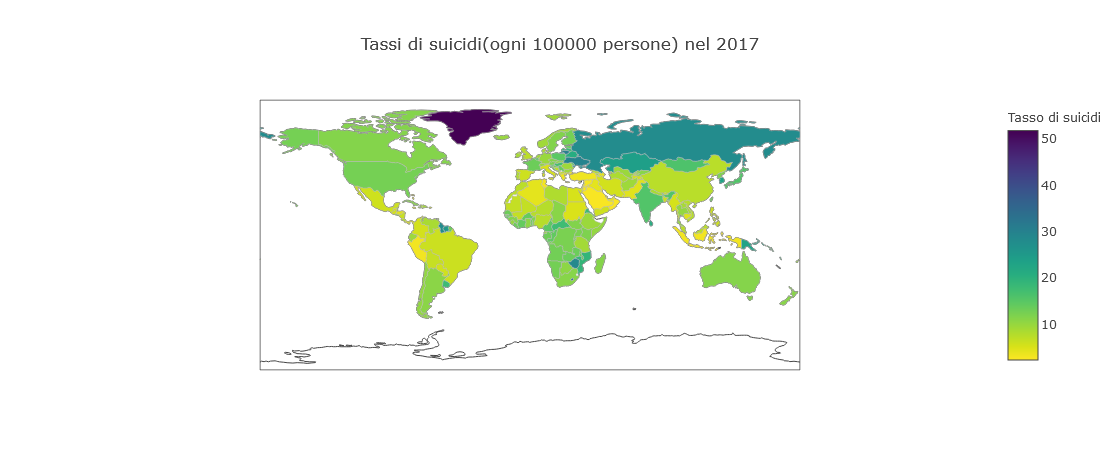

In [16]:
count = [ dict(
        # tipo di mappa
        type = 'choropleth',
        locations = suicides2017['Country'],
        locationmode='country names',
        z = suicides2017['Suicide rate (age-standardized)'],
        text = suicides2017['Country'],
        colorscale = 'Viridis',
        autocolorscale = False,
        reversescale = True,
        # colorazione
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        # legenda colori
        colorbar = dict(
            autotick =False,
            title = 'Tasso di suicidi'),
      ) ]
# create layout for gragh
layout = dict(
    title = 'Tassi di suicidi(ogni 100000 persone) nel 2017',
    # 
    geo = dict(
        showframe = True,
        showcoastlines = True,
        projection = dict(
            type = 'Mercator'
        )
    )
)
# prepare the fig parameter
fig = dict( data=count, layout=layout )
iplot( fig, validate=False, filename='d3-world-map' )

### 3.1.4 Plotting sulla mappa dei tassi di suicidio

## 3.2 Mortalità infantile

Viene caricato ed analizzato in contemporanea con gli altri dataset anche un dataset sulla mortalità infantile. Questo dataset non verrà analizzato nel dettaglio ma solamente utilizzato durante l'analisi combinata degli altri dataset.

In [17]:
infantMortality = pd.read_csv("dati/worldHappyness/infant-mortality.csv")
infantMortality.head()

Country Code  year  Mortality rate, infant (per 1,000 live births)
0  Afghanistan  AFG  2015                                            58.7
1  Afghanistan  AFG  2016                                            56.7
2  Afghanistan  AFG  2017                                            54.9
3  Afghanistan  AFG  2018                                            53.2
4  Afghanistan  AFG  2019                                            51.5

## 3.3 Income inequality

Come per la mortalità infantile, questo dataset viene caricato inizialmente per poi essere utilizzato in seguito durante le predizioni e l'analisi vera e propria.

In [18]:
incomeInequality = pd.read_csv("dati/worldHappyness/economic-inequality-gini-index.csv")
incomeInequality.head()

Country Code  year  GINI index (World Bank estimate)
0    Algeria  DZA  2017                              27.6
1     Angola  AGO  2017                              42.7
2  Argentina  ARG  2017                              42.7
3    Armenia  ARM  2017                              32.4
4  Australia  AUS  2017                              34.7

Viene inoltre introdotta una variabile categorica che esprime l'inequalità di uno stato rispetto a tutti i dati (per essere più precisi si poteva utilizzare l'interpretazione del gini index per cui un valore prossimo allo 0% significava equalità assoluta, mentre un valore vicino a 100% indicava inequalità totale).

La scelta di utilizzare un range definito in base ai dati sottostanti è stata fatta per mantenere una buona variabilità alla variabile categorica introdotta(se fosse stata utilizzata l'interpretazione del gini index, molti valori qualitativi non sarebbero stati presi).

In [19]:
start = incomeInequality["GINI index (World Bank estimate)"].min()
stepgini = incomeInequality["GINI index (World Bank estimate)"].max() - incomeInequality["GINI index (World Bank estimate)"].min() 
stepgini = stepgini/5


conditions = [
    (incomeInequality["GINI index (World Bank estimate)"]<start+stepgini),
    (incomeInequality["GINI index (World Bank estimate)"]>=start+stepgini)&(incomeInequality["GINI index (World Bank estimate)"]<start+2*stepgini),
    (incomeInequality["GINI index (World Bank estimate)"]>=start+2*stepgini)&(incomeInequality["GINI index (World Bank estimate)"]<start+3*stepgini),
    (incomeInequality["GINI index (World Bank estimate)"]>=start+3*stepgini)&(incomeInequality["GINI index (World Bank estimate)"]<start+4*stepgini),
    (incomeInequality["GINI index (World Bank estimate)"]>=start+4*stepgini)
]

valori = ["low","medium-low","medium","medium-high","high"]

incomeInequality["inequality"] = np.select(conditions,valori)

In [20]:
incomeInequality.head()

Country Code  year  GINI index (World Bank estimate)  inequality
0    Algeria  DZA  2017                              27.6         low
1     Angola  AGO  2017                              42.7      medium
2  Argentina  ARG  2017                              42.7      medium
3    Armenia  ARM  2017                              32.4         low
4  Australia  AUS  2017                              34.7  medium-low

<AxesSubplot:>

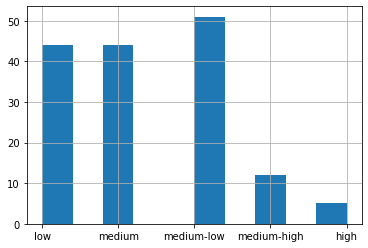

In [21]:
incomeInequality["inequality"].hist()

# 4. Analisi statistica

Obiettivo primario di questa analisi e capire se il legame effettivo tra la felicità dichiarata di una popolazione e la popolazione sia effettivamente vero, per fare questo bisogna analizzare sostanzialmente concetti contrapposti e negativi(come i suicidi, o magari coloro che soffrono di disturbi psichici, dato che solitamente provengono tutti da una radice insita nella tristezza).
Durante questa analisi verranno messe a confronto due distribuzioni, che sono i due dataset principali di questo studio, cioé World Happiness e tasso di suicidi.

In [22]:
import matplotlib.pyplot as plt

Un conteggio delle singole istanze è inutile dato che quasi tutti i dati importanti sono reali.

Un discorso simile può essere fatto per il dataset sui suicidi, dato che praticamente tutti gli attributi rilevanti sono reali, potrebbe comunque essere fatto un discorso diverso per attributi derivati, come la prevalenza tra suicidi di uomini o donne.

In [23]:
prevalenza = suicides2017["Male suicide rate (age-standardized)"] > suicides2017["Female suicide rate (age-standardized)"]
print("Il numero di stati dove il numero di suicidi di uomini è più alto di quello delle donne è "+str(prevalenza.value_counts().tolist()[0]))
print("Il numero di stati dove il numero di suicidi di donne è più alto di quello degli uomini è "+str(prevalenza.value_counts().tolist()[1]))

Il numero di stati dove il numero di suicidi di uomini è più alto di quello delle donne è 192
Il numero di stati dove il numero di suicidi di donne è più alto di quello degli uomini è 2


Come si può vedere, la maggior parte degli stati in cui la prevalenza di suicidi è maschile costituisce sostanzialmente la maggioranza, questo fa intuire come il sesso di una persona possa influire sulla felicità.

## 4.1 Istogrammi

Di seguito vengono visti gli istogrammi degli score di felicità e dei tassi di suicidi, per dare una prima occhiata alle forme delle distribuzioni con la ricerca di possibili similarità tra le due distribuzioni.
Il numero di classi per bin viene stabilito secondo la radice quadrata del numero di record, alternativamente si poteva utilizzare la regola di Stokes prendendo il logaritmo.

Vengono presi intervalli uniformi (presi direttamente da matplotlib o la funzione di pandas) che avranno come ampiezza 
\\[h={\frac{max-min}{nbins}}\\]

### 4.1.1 istogramma degli score di felicità

Viene visto prima di tutto l'istogramma degli score di felicità per capire quale sia l'andamento della distribuzione, dato che si sta cercando di vedere il legame tra gli score di felicità ed i tassi di suicidio.

26


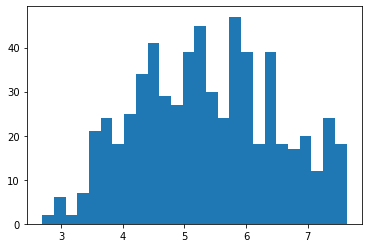

In [24]:
import math
n_bins = math.ceil(math.sqrt(dataset.shape[0]+1))
plt.hist(dataset["Score"],bins=n_bins)
happinessBinWidth = (dataset["Score"].max()-dataset["Score"].min())/n_bins
print(n_bins)

array([[<AxesSubplot:title={'center':'2015'}>,
        <AxesSubplot:title={'center':'2016'}>],
       [<AxesSubplot:title={'center':'2017'}>,
        <AxesSubplot:title={'center':'2018'}>]], dtype=object)

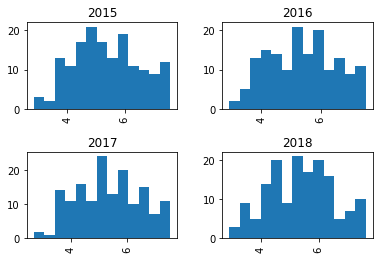

In [25]:
n_binsSingoloAnno = math.ceil(math.sqrt(dataset[dataset["year"]==2017].shape[0]+1))
happinessBinWidth2017 = (dataset2017["Score"].max()-dataset2017["Score"].min())/n_binsSingoloAnno
dataset["Score"].hist(by=dataset["year"],bins=n_binsSingoloAnno)

Non ci sono differenze significative tra le distribuzioni in base ai sessi, quindi l'analisi statistica verrà fatta principalmente sul tasso di suicidi standardizzato senza tenere conto del singolo sesso.

Inoltre i dati sembrano monomodali, quindi si possono approssimare abbastanza bene tramite distribuzioni semplici e non si ricorre a metodi di ricerca di distribuzioni multimodali(mixture of gaussian o altro).

### 4.1.2 istogrammi del tasso dei suicidi

Si passa ora agli istogrammi dei tassi di suicidio.

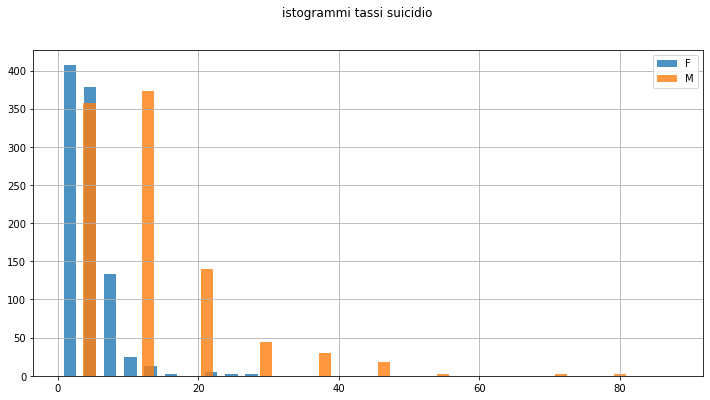

In [26]:
n_binsSuicides = math.ceil(math.sqrt(suicidesBySex.shape[0]+1))
suicideBinWidth = (suicidesBySex["Suicide rate (age-standardized)"].max()-suicidesBySex["Suicide rate (age-standardized)"].min())/n_binsSuicides

fig = plt.figure(figsize=(12,6))
plt.hist(suicidesBySex["Female suicide rate (age-standardized)"], width=suicideBinWidth, alpha=0.8)
plt.hist(suicidesBySex["Male suicide rate (age-standardized)"], width=suicideBinWidth, alpha=0.8)
plt.legend(['F','M'])
fig.suptitle("istogrammi tassi suicidio")
plt.grid()
plt.show()

Come si può vedere semplicemente, i suicidi delle donne restano nella prima parte dell'istogramma (quindi i suicidi femminili restano relativamente bassi in qualsiasi stato) mentre i suicidi maschili raggiungono valori molto alti e si mantengono sopra una certa soglia (intorno ai 15 individui che si sono suicidati su 100000 persone).

array([[<AxesSubplot:title={'center':'2015'}>,
        <AxesSubplot:title={'center':'2016'}>],
       [<AxesSubplot:title={'center':'2017'}>,
        <AxesSubplot:title={'center':'2018'}>],
       [<AxesSubplot:title={'center':'2019'}>, <AxesSubplot:>]],
      dtype=object)

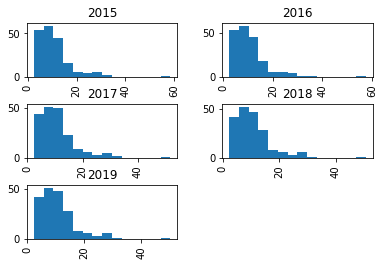

In [27]:
n_binsSingoloAnnoSuicides = math.ceil(math.sqrt(suicidesBySex[suicidesBySex["year"]==2017].shape[0]+1))
suicidesBySex["Suicide rate (age-standardized)"].hist(by=suicidesBySex["year"],bins=n_binsSingoloAnnoSuicides)

L'istogramma dei suicidi sembra mantenere la stessa forma, quindi una variabilità da anno in anno quasi nulla, questo dato è molto interessante, dato che fa vedere come i suicidi ed il pensiero che porta a tali conseguenze sembrano essere indipendenti dal tempo. 
Stesso discorso fatto quindi per gli istogrammi degli score di happiness può quindi essere fatto in questo caso, cioè verrà analizzato principalmente un singolo anno in seguito(2017) dato che i dati non sembrano variare molto di anno in anno.

Come si può vedere ad occhio nudo, l'istogramma segue una distribuzione quasi poissoniana (o simili come una Gamma o una lognormale).
Si vedrà prossimamente la asimmetria(skewness) e la curtosi delle distribuzioni, per vedere se l'intuizione per cui la distribuzione segua una distribuzione di lognormale o gamma è esatta o no, oltre a capire se ci sia una asimmetria a destra e quanto la distribuzione sia schiacciata.


Si può anche vedere come le distribuzioni degli score di felicità e dei suicidi siano fondamentalmente differenti a prima occhiata, dato che la prima segue una distribuzione quasi normale ad occhio, con una Curtosi quasi nulla, mentre la seconda ha i dati concentrati nella prima parte della distribuzione con degli "outlier" nella parte destra.
Altre considerazioni verranno fatte dopo aver portato a termine l'analisi della forma con conseguente studio della distribuzione e Probability Density Function (PDF) stimate.

Tramite questi istogrammi e possibile avere una idea della distribuzione dei dati che servirà dopo per la stima della densità, ma non ci permettono di sapere la probabilità di avere valori tra due estremi, quindi di seguito vengono visti dei calcoli di densità di istogramma per avere una idea basilare di come costruire una densità discreta(più avanti verranno viste le stime di densità vere e proprie).

### 4.1.3 istogramma normalizzato degli score di felicità

Si vedono gli istogrammi normalizzati degli score di felicità e dei tassi di suicidio, confrontando una 

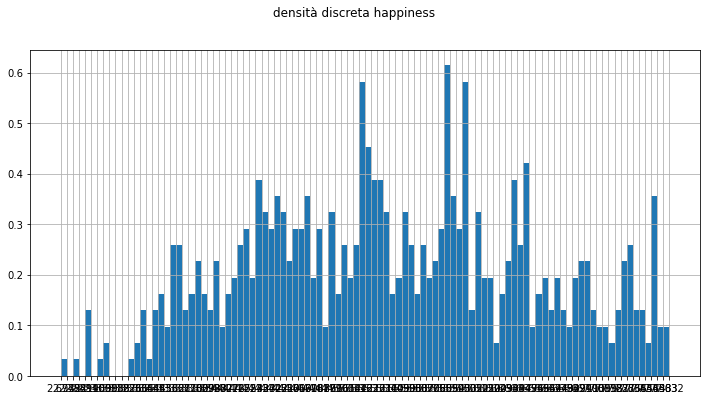

In [28]:
fig = plt.figure(figsize=(12,6))
binsHappiness = list(np.arange(dataset["Score"].min(),dataset["Score"].max(),happinessBinWidth))
#valori,bordi,_=plt.hist(dataset["Score"], bins=binsHappiness, width=happinessBinWidth, density=True)
valori,bordi,_=plt.hist(dataset["Score"], bins=100, density=True)
plt.xticks(bordi)
plt.grid()
fig.suptitle("densità discreta happiness")
plt.show()

### 4.1.4 Istogramma normalizzato dei tassi di suicidio

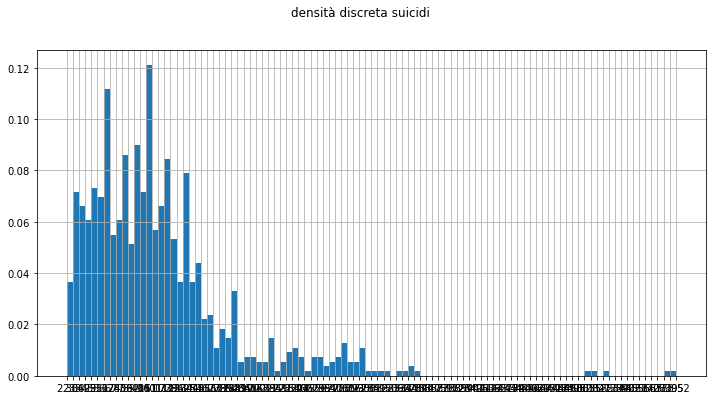

In [29]:
fig = plt.figure(figsize=(12,6))
binsSuicides = list(np.arange(suicidesBySex["Suicide rate (age-standardized)"].min(),suicidesBySex["Suicide rate (age-standardized)"].max(),suicideBinWidth))
#valoriSuicidi,bordiSuicidi,_=plt.hist(suicidesBySex["Suicide rate (age-standardized)"], bins=binsSuicides, width=suicideBinWidth, density=True)
valoriSuicidi,bordiSuicidi,_=plt.hist(suicidesBySex["Suicide rate (age-standardized)"], bins=100, density=True)
plt.xticks(bordiSuicidi)
plt.grid()
fig.suptitle("densità discreta suicidi")
plt.show()

Per calcolare la probabilità di avere valori in un intervallo bisogna calcolare l'area sotto i bins coinvolti nell'intervallo(togliendo le parti che non rientrano ovviamente).

Di seguito viene vista la probabilità di trovare valori in un intervallo compreso tra $min(value)$ per la singola feature ed il primo bordo del bin in cui la probabilità di trovare valori  compresi nell'intervallo sia del 50% (sia score di felicità che suicidi) per confrontare le due distribuzioni.

In [30]:
larghezzeFelicità = bordi[1:]-bordi[:-1]
larghezzeSuicidi = bordiSuicidi [1:]-bordiSuicidi[:-1]
binConsideratiSuicidi = 13
binConsiderati = 53
print((larghezzeFelicità[:binConsiderati]*valori[:binConsiderati]).sum()*100,"% di trovare score di felicità compresi tra [",
     bordi[0],",",bordi[binConsiderati],"]")
print((valoriSuicidi[:binConsideratiSuicidi]*larghezzeSuicidi[:binConsideratiSuicidi]).sum()*100,"% di trovare tassi di suicidio compresi tra [",
     bordiSuicidi[0],",",bordiSuicidi[binConsideratiSuicidi],"]")

50.0 % di trovare score di felicità compresi tra [ 2.69300007820129 , 5.3106700367546065 ]
50.824742268041234 % di trovare tassi di suicidio compresi tra [ 2.3 , 9.60795 ]


Come si poteva già intuire dall'istogramma, i tassi di suicidio sono praticamente tutti concentrati nella prima parte dell'istogramma mentre gli score di felicità sono concentrati quasi a metà, infatti per arrivare al 50% della probabilità di trovare valori tra [minimoSuicidi,numeroSuicidi] per i tassi di suicidio e [minimoScore,numeroScore] per gli score di felicità si vede come nella decima parte dei valori dei tassi di suicidio si ritrovano già il 50% dei record, mentre per gli score di felicità si arriva alla metà tra gli score.
Quindi le due distribuzioni sembrano essere abbastanza differenti.

## 4.2 Indici vari e confronto tra valori

### 4.2.1 Indicatori centrali

Di seguito si vedono indicatori di centralità (puntuali, non vengono calcolati intervalli di confidenza per tutto il dataset dato che negli anni del 2018 e 2019 non vengono più forniti gli estremi, ed in mancanza di altri dati(la deviazione standard), sarebbe inutile fornire dei stimatori intervallari, si potrebbe comunque calcolare una stima in base ai vari anni che vengono forniti per singolo stato, ma questa soluzione sembra soltanto un modo per superare la mancanza di informazioni aggiuntive) sulle feature dei due dataset (world happiness e tassi di suicidio).
L'indice di centralità utilizzato viene definito secondo le seguenti formule:
\\[\overline{X} = \frac{1}{N} \sum_{i}^{N} x_i\\]
Che è la media aritmetica.

In seguito verranno visti pure altri indicatori (di dispersione) che verranno descritti a tempo debito. 

In [31]:
happinessMean = dataset["Score"].mean()
tassoMedioSuicidiUomini = suicidesBySex["Male suicide rate (age-standardized)"].mean()
tassoMedioSuicidiDonne = suicidesBySex["Female suicide rate (age-standardized)"].mean()
tassoMedioSuicidi = suicidesBySex["Suicide rate (age-standardized)"].mean()
print("Score di felicità medio: "+str(happinessMean))
print("Tasso medio di suicidi uomini: "+str(tassoMedioSuicidiUomini))
print("Tasso medio di suicidi donne: "+str(tassoMedioSuicidiDonne))
print("Tasso medio di suicidi: "+str(tassoMedioSuicidi))

Score di felicità medio: 5.3720207670047255
Tasso medio di suicidi uomini: 16.611731958762885
Tasso medio di suicidi donne: 4.725804123711331
Tasso medio di suicidi: 10.668768041237104


In [32]:
happinessMean2017 = dataset2017["Score"].mean()
happinessUpperConfMean2017 = dataset2017["Upper_Confidence_Interval"].mean()
happinessLowerConfMean2017 = dataset2017["Lower_Confidence_Interval"].mean()
tassoMedioSuicidiUomini2017 = suicides2017["Male suicide rate (age-standardized)"].mean()
tassoMedioSuicidiDonne2017 = suicides2017["Female suicide rate (age-standardized)"].mean()
tassoMedioSuicidi2017 = suicides2017["Suicide rate (age-standardized)"].mean()
print("Score di felicità medio 2017: "+str(happinessMean2017)+ "+-" +str((happinessUpperConfMean2017-happinessLowerConfMean2017)/2))
print("Tasso medio di suicidi uomini 2017: "+str(tassoMedioSuicidiUomini2017))
print("Tasso medio di suicidi donne 2017: "+str(tassoMedioSuicidiDonne2017))
print("Tasso medio di suicidi 2017: "+str(tassoMedioSuicidi2017))

Score di felicità medio 2017: 5.354019355773926+-0.09830636170458229
Tasso medio di suicidi uomini 2017: 16.62025773195876
Tasso medio di suicidi donne 2017: 4.733917525773198
Tasso medio di suicidi 2017: 10.67708762886598


E' possibile definire un intervallo di confidenza dato che il dataset del 2017 fornisce i margini del range, cosa non possibile per il dataset completo della happiness e dei suicidi.

A riprova del fatto che considerare solo l'anno 2017 non cambia i risultati ottenuti, si ha più o meno la stessa media di quella di tutti gli anni.

In [33]:
happinessMedian = dataset["Score"].median()
tassoMedianoSuicidiUomini = suicidesBySex["Male suicide rate (age-standardized)"].median()
tassoMedianoSuicidiDonne = suicidesBySex["Female suicide rate (age-standardized)"].median()
tassoMedianoSuicidi = suicidesBySex["Suicide rate (age-standardized)"].median()
print("Score di felicità mediano : "+str(happinessMedian))
print("Tasso mediano di suicidi uomini : "+str(tassoMedianoSuicidiUomini))
print("Tasso mediano di suicidi donne : "+str(tassoMedianoSuicidiDonne))
print("Tasso mediano di suicidi : "+str(tassoMedianoSuicidi))

Score di felicità mediano : 5.306999935150145
Tasso mediano di suicidi uomini : 14.29
Tasso mediano di suicidi donne : 4.155
Tasso mediano di suicidi : 9.54


In [34]:
happinessMedian2017 = dataset2017["Score"].median()
tassoMedianoSuicidiUomini2017 = suicides2017["Male suicide rate (age-standardized)"].median()
tassoMedianoSuicidiDonne2017 = suicides2017["Female suicide rate (age-standardized)"].median()
tassoMedianoSuicidi2017 = suicides2017["Suicide rate (age-standardized)"].median()
print("Score di felicità mediano 2017: "+str(happinessMedian2017))
print("Tasso mediano di suicidi uomini 2017: "+str(tassoMedianoSuicidiUomini2017))
print("Tasso mediano di suicidi donne 2017: "+str(tassoMedianoSuicidiDonne2017))
print("Tasso mediano di suicidi 2017: "+str(tassoMedianoSuicidi2017))

Score di felicità mediano 2017: 5.27899980545044
Tasso mediano di suicidi uomini 2017: 14.36
Tasso mediano di suicidi donne 2017: 4.205
Tasso mediano di suicidi 2017: 9.5


Stesso discorso fatto precedentemente per le medie, le mediane sono praticamente le stesse.

Con questi indicatori i due dataset non possono essere ancora comparati, dato che sono fondamentalmente diversi e non è molto utile fare delle supposizioni sulle semplici medie.

### 4.2.2 Indicatori di dispersione

Tra gli indicatori di dispersione vengono annotati pure il massimo ed il minimo di una feature in un dataset, che in questo caso sono state già utilizzate durante la costruzione degli istogrammi.
Se mai dovesse servire normalizzare i valori in un range, allora in quel caso massimo e minimo saranno riutilizzati per il calcolo dei valori normalizzati tra [0,1].


Potrebbbero essere visti nel dettaglio vari quantili per testare ancora di più i vari dataset ma questo studio si limita ad utilizzare boxplot per la vistualizzazione diretta di quantili (primo e terzo quartile), outlier massimi e minimi.

Quando certi indici dovranno servire verranno direttamente calcolati tramite chiamata di funzione.

Text(0.5, 1.0, 'Happiness score')

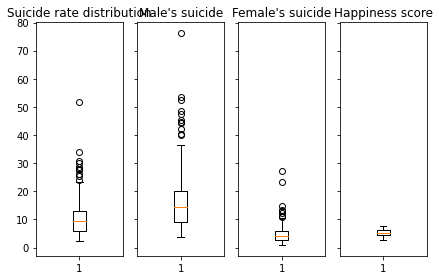

In [35]:
fig, axs = plt.subplots(1, 4, sharey=True, tight_layout=True)

axs[0].boxplot(suicides2017["Suicide rate (age-standardized)"])
axs[0].set_title("Suicide rate distribution")
axs[1].boxplot(suicides2017["Male suicide rate (age-standardized)"])
axs[1].set_title("Male's suicide")
axs[2].boxplot(suicides2017["Female suicide rate (age-standardized)"])
axs[2].set_title("Female's suicide")
axs[3].boxplot(dataset2017["Score"])
axs[3].set_title("Happiness score")
#print(n_binsSuicides)

Una quantità non indifferente di stati con tassi di suicidio molto alti viene considerata come outlier(escono fuori da Q3 + IQR*1.5), mentre gli score di felicità sembrano ricadere perfettamente nell'intervallo, risultando in 0 outlier.

Questo succede perché le distribuzioni dei suicidi non seguono una distribuzione normale(altrimenti la maggior parte dei dati rientrerebbero nell'intervallo tra [Q1-1.5*IQR,Q3+1.5*IQR]) dei dati ma sembrano tendere più ad una Poisson con parametro $\lambda$ relativamente basso, oppure una $\chi^2$.

Anche questo tipo di analisi prova che le distribuzioni dei due dataset sono sostanzialmente differenti, e che in quasi tutti i paesi dove viene dichiarata una felicità medio-alta si hanno probabilmente pochi suicidi (dato che dall'istogramma si ha una asimmetria a destra, quindi molti paesi dove si hanno valori di suicidi relativamente bassi), anche se non bisogna saltare troppo velocemente alle conclusioni.

Come accennato sopra, la distanza inter-quartile(Inter Quartile Range) viene definita come la differenza tra il terzo ed il primo quartile(individuando così un area simmetrica dove al centro vi è la mediana), questa misura è molto importante per capire se la distribuzione segue un andamento normale oppure risultano troppi outlier(come osservato precedentemente infatti, la distribuzione dei tassi di suicidio sembra non essere normale).

Un altro importante indice che tornerà utile durante l'analisi delle due distribuzioni è la varianza definita nel seguente modo:
\begin{equation}
s^2 = \frac{\sum_{i=1}^n(x_i-\overline x)^2}{n}
\end{equation}
Definita quindi come la varianza della popolazione(se fosse stata di un campione si doveva dividere per n-1 e non per n dato che vi era un grado di libertà in meno, quindi usare il fattore di correzione di Bessel per avere uno stimatore unbiased, non è questo il caso).

In [36]:
happinessVariance2017 = dataset2017["Score"].var()
tassoVarianceSuicidiUomini2017 = suicides2017["Male suicide rate (age-standardized)"].var()
tassoVarianceSuicidiDonne2017 = suicides2017["Female suicide rate (age-standardized)"].var()
tassoVarianceSuicidi2017 = suicides2017["Suicide rate (age-standardized)"].var()
happinessVariance = dataset["Score"].var()
tassoVarianceSuicidiUomini = suicidesBySex["Male suicide rate (age-standardized)"].var()
tassoVarianceSuicidiDonne = suicidesBySex["Female suicide rate (age-standardized)"].var()
tassoVarianceSuicidi = suicidesBySex["Suicide rate (age-standardized)"].var()
print("Score di felicità varianza 2017: "+str(happinessVariance2017))
print("Tasso varianza di suicidi uomini 2017: "+str(tassoVarianceSuicidiUomini2017))
print("Tasso varianza di suicidi donne 2017: "+str(tassoVarianceSuicidiDonne2017))
print("Tasso varianza di suicidi 2017: "+str(tassoVarianceSuicidi2017))
print("Score di felicità varianza : "+str(happinessVariance))
print("Tasso varianza di suicidi uomini : "+str(tassoVarianceSuicidiUomini))
print("Tasso varianza di suicidi donne : "+str(tassoVarianceSuicidiDonne))
print("Tasso varianza di suicidi : "+str(tassoVarianceSuicidi))

Score di felicità varianza 2017: 1.2796815163290856
Tasso varianza di suicidi uomini 2017: 117.89775381924038
Tasso varianza di suicidi donne 2017: 11.122128614924414
Tasso varianza di suicidi 2017: 46.013710515597445
Score di felicità varianza : 1.2809124148760904
Tasso varianza di suicidi uomini : 118.40236397348743
Tasso varianza di suicidi donne : 11.023944089559874
Tasso varianza di suicidi : 46.19304572013339


Ancora una volta i valori del 2017 sembrano essere sostanzialmente gli stessi dei dataset completi.

Per avere le deviazioni standard basta prendere la radice quadrata della varianza.

Un modo per avere tutte le informazioni descritte precedentemente era utilizzare la funzione **describe**.

In [37]:
suicides2017.describe()

year  Male suicide rate (age-standardized)  \
count   194.0                            194.000000   
mean   2017.0                             16.620258   
std       0.0                             10.858073   
min    2017.0                              3.620000   
25%    2017.0                              9.012500   
50%    2017.0                             14.360000   
75%    2017.0                             20.040000   
max    2017.0                             76.270000   

       Female suicide rate (age-standardized)  Suicide rate (age-standardized)  
count                              194.000000                       194.000000  
mean                                 4.733918                        10.677088  
std                                  3.334986                         6.783341  
min                                  0.860000                         2.300000  
25%                                  2.625000                         6.011250  
50%                                  4.205000                         9.500000  
75%                                  5.840000                        12.967500  
max                                 27.380000                        51.825000

In [38]:
dataset2017.describe()

rank       Score  Upper_Confidence_Interval  \
count  155.000000  155.000000                 155.000000   
mean    78.000000    5.354019                   5.452326   
std     44.888751    1.131230                   1.118542   
min      1.000000    2.693000                   2.864884   
25%     39.500000    4.505500                   4.608172   
50%     78.000000    5.279000                   5.370032   
75%    116.500000    6.101500                   6.194600   
max    155.000000    7.537000                   7.622030   

       Lower_Confidence_Interval         GDP  Social_support  life_Expectancy  \
count                 155.000000  155.000000      155.000000       155.000000   
mean                    5.255713    0.984718        1.188898         0.551341   
std                     1.145030    0.420793        0.287263         0.237073   
min                     2.521116    0.000000        0.000000         0.000000   
25%                     4.374955    0.663371        1.042635         0.369866   
50%                     5.193152    1.064578        1.253918         0.606042   
75%                     6.006527    1.318027        1.414316         0.723008   
max                     7.479556    1.870766        1.610574         0.949492   

       FreedomOflife  Generosity  corruption  DystopiaResidual    year  
count     155.000000  155.000000  155.000000        155.000000   155.0  
mean        0.408786    0.246883    0.123120          1.850238  2017.0  
std         0.149997    0.134780    0.101661          0.500028     0.0  
min         0.000000    0.000000    0.000000          0.377914  2017.0  
25%         0.303677    0.154106    0.057271          1.591291  2017.0  
50%         0.437454    0.231538    0.089848          1.832910  2017.0  
75%         0.516561    0.323762    0.153296          2.144654  2017.0  
max         0.658249    0.838075    0.464308          3.117485  2017.0

In [39]:
infantMortality2017 = infantMortality[infantMortality["year"]==2017]
infantMortality2017.describe()

year  Mortality rate, infant (per 1,000 live births)
count   237.0                                      237.000000
mean   2017.0                                       24.200654
std       0.0                                       20.465379
min    2017.0                                        1.700000
25%    2017.0                                        7.200000
50%    2017.0                                       16.164699
75%    2017.0                                       37.400000
max    2017.0                                       91.600000

In questo modo si possono osservare anche le feature che non erano state considerate precedentemente.

### 4.2.3 Analisi Z-score

E' molto utile studiare gli z-score delle distribuzioni di dati in modo da poter confrontare direttamente due distribuzioni, solo che, in questo caso, una delle due distribuzioni non ha un andamento normale, quindi  non ci si aspetta nessun risultato da questa analisi.

Gli z-score vengono calcolati nel seguente modo:
\begin{equation}
z_i = \frac{x_i-\mu_X}{\sigma_X}
\end{equation}

Text(0.5, 1.0, 'Happiness score')

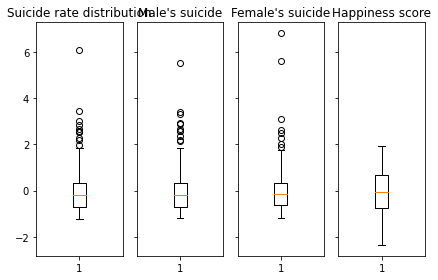

In [40]:
from scipy.stats import zscore
happinessZscore=zscore(dataset2017['Score'])
suicidesMenZscore=zscore(suicides2017["Male suicide rate (age-standardized)"])
suicidesWomenZscore=zscore(suicides2017["Female suicide rate (age-standardized)"])
suicidesZscore=zscore(suicides2017["Suicide rate (age-standardized)"])
infantMortalityZscore=zscore(infantMortality2017['Mortality rate, infant (per 1,000 live births)'])
fig, axs = plt.subplots(1, 4, sharey=True, tight_layout=True)

axs[0].boxplot(suicidesZscore)
axs[0].set_title("Suicide rate distribution")
axs[1].boxplot(suicidesMenZscore)
axs[1].set_title("Male's suicide")
axs[2].boxplot(suicidesWomenZscore)
axs[2].set_title("Female's suicide")
axs[3].boxplot(happinessZscore)
axs[3].set_title("Happiness score")
#axs[4].boxplot(infantMortalityZscore)
#axs[4].set_title("Infant mortality")

Come si può notare, i risultati sono praticamente gli stessi ottenuti dai dataset originali, dove lo score della felicità sembra essere disposta come una normale, i suicidi hanno la maggior parte dei dati concentrati nella parte sinistra ed hanno una lunga coda a destra che viene identificata come outliers.

### 4.2.4 Indici di forma

Di seguito vengono visti gli indici di forma per gli score della felicità e per i tassi di suicidio, il resto delle feature nel dataset della felicità non vengono considerate particolarmente (verranno comunque viste) ai fini dell'analisi statistica dato che obiettivo principale di questo studio è vedere il collegamento tra la felicità e la possibile tristezza percepita di uno stato-regione.

In [41]:
dataset2017.skew()

rank                         0.000000
Score                        0.009554
Upper_Confidence_Interval    0.008410
Lower_Confidence_Interval    0.009116
GDP                         -0.390693
Social_support              -1.181100
life_Expectancy             -0.577966
FreedomOflife               -0.615766
Generosity                   0.898715
corruption                   1.476362
DystopiaResidual            -0.239324
year                         0.000000
dtype: float64

Come si può vedere chiaramente dal valore risultante, l'asimmetria dello score di felicità è praticamente nulla, quindi la distribuzione avrà un andamento a campana tipico della gaussiana.
le altre feature hanno leggere simmetrie a sinistra(per valori minori di 0) o a destra (per valori maggiori di 0).

In [42]:
suicides2017.skew()

year                                      0.000000
Male suicide rate (age-standardized)      1.959358
Female suicide rate (age-standardized)    2.962864
Suicide rate (age-standardized)           2.125137
dtype: float64

Si era già visto tramite gli istogrammi come la distribuzione dei tassi di suicidio avesse una asimmetria a destra, il fatto che il valore sia maggiore di 0 è soltanto una conferma alle congetture precedentemente anticipate.

In [43]:
dataset2017.kurtosis()

rank                        -1.200000
Score                       -0.750419
Upper_Confidence_Interval   -0.776360
Lower_Confidence_Interval   -0.723334
GDP                         -0.676755
Social_support               1.535250
life_Expectancy             -0.585552
FreedomOflife               -0.208406
Generosity                   1.743408
corruption                   1.663740
DystopiaResidual             0.690233
year                         0.000000
dtype: float64

Il valore della kurtosi fa presumere un leggero schiacciamento della distribuzione (platicurtica), quindi non fa presupporre una normale perfetta(un valore di curtosi intorno a 0, dato che la curtosi calcolata da pandas viene spostata da 3 a 0 per il valore di una distribuzione con andamento normale).

In [44]:
suicides2017.kurtosis()

year                                       0.000000
Male suicide rate (age-standardized)       5.614566
Female suicide rate (age-standardized)    15.192962
Suicide rate (age-standardized)            7.550675
dtype: float64

Per i tassi di suicidi sembra esserci una leptocurtosi (un picco molto alto e code lunghe), già visibile effettivamente dagli istogrammi, dove range di valori erano molto popolati ed altri range erano poco popolati.

I risultati e le congetture precedentemente ottenute sono rafforzate dalla vista della densità stimata da pandas.

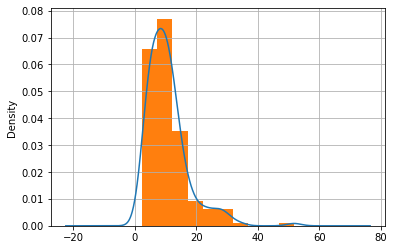

In [45]:
plots = suicides2017["Suicide rate (age-standardized)"].plot.density()
plt.hist(suicides2017["Suicide rate (age-standardized)"], density=True)
plt.grid()
plt.show()

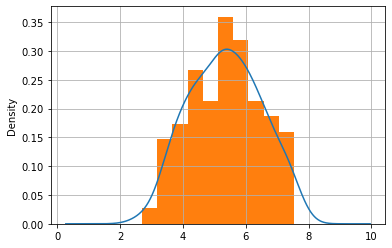

In [46]:
ploth = dataset2017["Score"].plot.density()
plt.hist(dataset2017["Score"], density=True)
plt.grid()
plt.show()

Dalle densità stimate dalla funzione di pandas, si può notare come le densità stimate non siano particolarmente complicate, di seguito verranno visti quindi dei metodi di stima della densità con conseguenti densità stimate, alla fine della stima delle densità verranno poste delle congetture sia sulle singole distribuzioni di dati, sia sulle relazioni tra esse.

### 4.2.5 Analisi densità

In questa sezione verranno viste delle tecniche di stima della densità dei dati sugli score di felicità e sui tassi di suicidi.

Il fine ultimo di questa analisi è vedere se le densità stimate per gli score di felicità e per i tassi di suicidi abbiano lo stesso andamento.

Si parte prima di tutto con dei metodi grafici (come potevano essere precedentemente gli istogrammi), in particolare viene visto prima di tutto il QQ-plot dei dati in modo da testare l'andamento normale dei dati.

Verranno inoltre utilizzati dei metodi statistici per i test di bontà di adattamento (goodness of fit) per la ricerca delle migliori densità stimate per il singolo dataset.

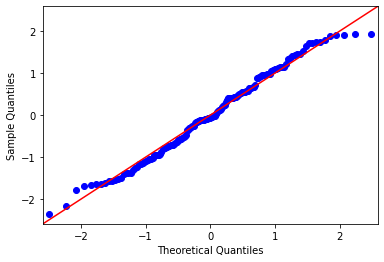

In [47]:
from statsmodels.graphics.gofplots import qqplot

qqplot(dataset2017["Score"], fit=True, line='45')
plt.show()

Come era stato già visto precedentemente, gli score di felicità seguono molto bene una distribuzione normale (tranne per piccole differenze sulle code, causate probabilmente da outlier data la loro scarsità).

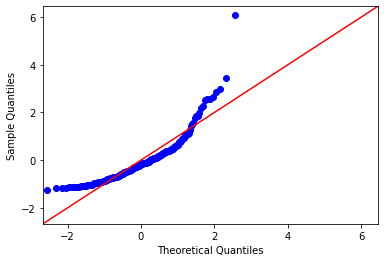

In [48]:
qqplot(suicides2017["Suicide rate (age-standardized)"], fit=True, line='45')
plt.show()

Come già predetto precedentemente, i tassi di suicidio non sembrano seguire una normale, stessa considerazione può essere fatta sui tassi divisi per sesso dato che seguono più o meno tutti la stessa distribuzione.

Di seguito vengono fatti vari fit alle distribuzioni di dati degli score di felicità e dei tassi di suicidi, tutti effettuati su dataset del 2017, con controllo per la ricerca del fit migliore.

Ovviamente non verranno provate tutte le distribuzioni esistenti ma soltanto quelle che sembrano avere un andamento adatto alle distribuzioni e gli istogrammi visti precedentemente, quindi:
> - Per gli score di felicità verranno provate le distribuzioni: Gaussiana, Weibull
> - Per i tassi di suicidi verranno provate le distribuzioni: Lognormale, Gamma.

Per la ricerca dei migliori parametri del fit verrà utilizzato il metodo della Maximum Likelihood Estimation(che è quello utilizzato dalle varie librerie).

Per la ricerca della distribuzione che approssima meglio il dataset verranno utilizzati dei test di goodness, in particolare verrà utilizzato il test di Kolmogorov-Smirnov, anche se per testare la normalità di una distribuzione si avrebberò risultati migliori con test del tipo Shapiro-Wilk [Comparision of normality tests](https://web.archive.org/web/20150630110326/http://instatmy.org.my/downloads/e-jurnal%202/3.pdf).

In [49]:
from scipy.stats import norm,lognorm,gamma,poisson,exponweib,ks_2samp,kstest

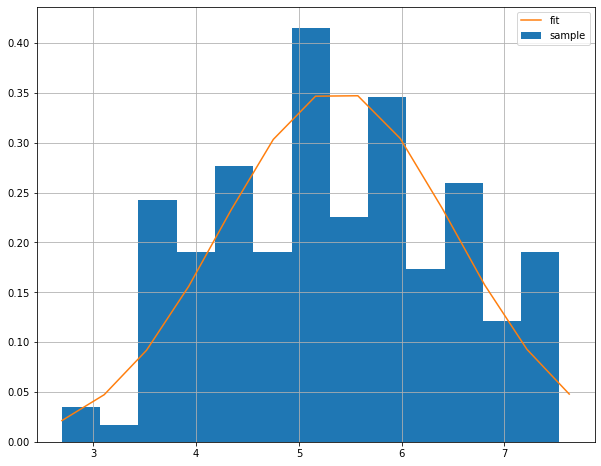

In [50]:
# Fit funzione gaussiana per gli score sulla felicità
plt.figure(figsize=(10,8))
g=norm(*norm.fit(dataset["Score"]))
x=np.linspace(dataset["Score"].min(),dataset["Score"].max(),n_binsSingoloAnno)
plt.hist(dataset2017["Score"],bins=n_binsSingoloAnno,density=True)
plt.plot(x,g.pdf(x))
plt.grid()
plt.legend(['fit','sample'])
plt.show()

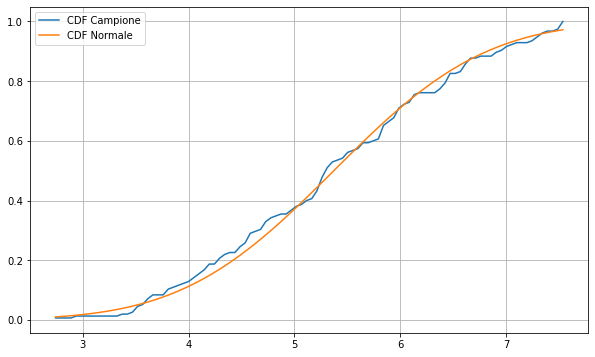

In [51]:
hist, bin_edges = np.histogram(dataset2017['Score'],bins=100,density=True)
cumsumScoreHap = np.cumsum(hist)
cumsumScoreHap = cumsumScoreHap/cumsumScoreHap[-1]

cumsumNorm = g.cdf(bin_edges[1:])

plt.figure(figsize=(10,6))
plt.plot(bin_edges[1:],cumsumScoreHap)
plt.plot(bin_edges[1:],cumsumNorm)
plt.grid()
plt.legend(['CDF Campione','CDF Normale'])
plt.show()

In [52]:
testKSGaussian=kstest(dataset2017["Score"],"norm",args=g.args)
KSstatisticGauss = testKSGaussian[0]
pvalueGauss = testKSGaussian[1]

testKSGaussian

KstestResult(statistic=0.0501259117555275, pvalue=0.8120970889286211)

Il test sembra fornire risultati abbastanza buoni, anche se un p-value alto non significa necessariamente che la distribuzione segua una Gaussiana, significa che l'approssimazione risultante è abbastanza fedele al dataset originale, e che l'ipotesi nulla per cui la densità segua un andamento normale non può essere rifiutata.

shape:5.3409545024336715
scale:5.81084921180306


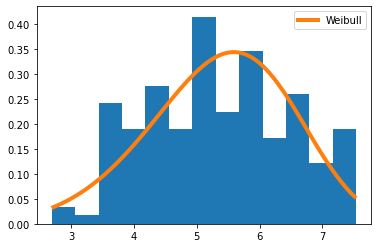

In [53]:
# Fit funzione Weibull 
params = exponweib.fit(dataset2017["Score"], floc=0, f0=1)
Weibshape = params[1]
Weibscale = params[3]
print ('shape:'+str(Weibshape))
print ('scale:'+str(Weibscale))

#### Plotting
# Histogram first
values,bins,hist = plt.hist(dataset2017["Score"],bins=n_binsSingoloAnno,density=True)
center = (bin_edges[:-1] + bin_edges[1:]) / 2.

# Using all params and the stats function
plt.plot(center,exponweib.pdf(center,*params),lw=4,label='Weibull')

plt.legend()

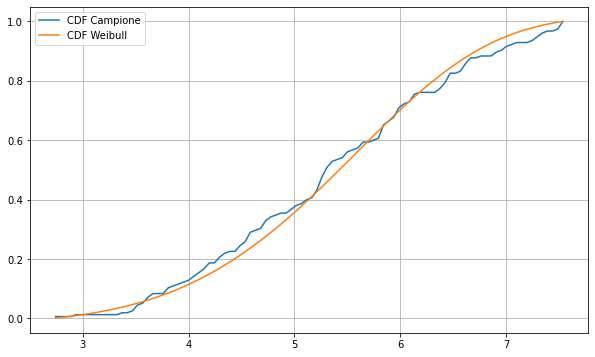

In [54]:
cumsumWeib = exponweib.pdf(center,*params).cumsum()
cumsumWeib = cumsumWeib/cumsumWeib[-1]

plt.figure(figsize=(10,6))
plt.plot(bin_edges[1:],cumsumScoreHap)
plt.plot(bin_edges[1:],cumsumWeib)
plt.grid()
plt.legend(['CDF Campione','CDF Weibull'])
plt.show()

Per calcolare la bontà di adattamento della weibull viene considerata la media di varie produzioni di valori random distribuiti secondo una distribuzione di Weibull, non vengono calcolati varianza o intervallo di confidenza perché lo scopo principale è vedere che valore assume la statistica.

In [55]:
a_in = 1
loc_in = 0

data = []
#ksResult = []
KSstatisticWeib = 0
pvalueWeib = 0
NiterationWeib = 1000
for i in range(0,NiterationWeib):
    tmp = exponweib.rvs(a=a_in,c=Weibshape, loc=loc_in, scale=Weibscale, size = dataset2017["Score"].shape[0]+1)
    data.append(tmp)

for i in range(0,NiterationWeib):
    tmp = ks_2samp(data[i],dataset2017["Score"],alternative="two-sided")
    #ksResult.append(tmp)
    KSstatisticWeib=KSstatisticWeib+tmp[0]
    pvalueWeib=pvalueWeib+tmp[1]

print("statistica: " + str(KSstatisticWeib/NiterationWeib) + ",pvalue: " + str(pvalueWeib/NiterationWeib))

statistica: 0.09074131513647651,pvalue: 0.5371942062344095


Come ipotesi nulla si ha che la distribuzione segua un andamento di Weibull.
Dato il p-value relativamente medio, non può essere detto che la distribuzione di weibull approssimi perfettamente la densità degli score, e dato che non è neanche minore di 0,05 per una confidenza affidabile, non è possibile dire che la approssimi male.
Ad occhio la distribuzione sembra approssimare bene i dati, e la cumulativa sembra essere molto esplicativa della similarità tra le due distribuzioni, quindi probabilmente la scelta del test di Kolmogorov-Smirnov per questo genere di distribuzione non ha portato a test che forniscano dei risultati significativi.

Tra le due distribuzioni analizzate, la normale sembra stimare meglio la densità del dataset originale, quindi si può affermare con poca incertezza che gli score di felicità seguono una distribuzione Gaussiana.

Si procede ora con la stima di densità dei tassi di suicidi.

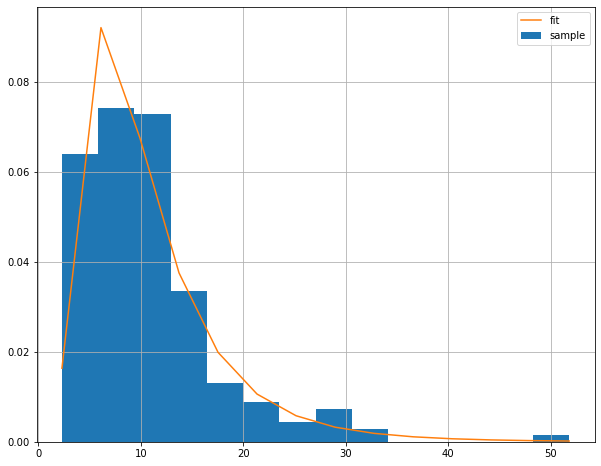

In [56]:
# Fit funzione lognormale per i tassi di suicidio
plt.figure(figsize=(10,8))
g=lognorm(*lognorm.fit(suicides2017["Suicide rate (age-standardized)"]))
x=np.linspace(suicides2017["Suicide rate (age-standardized)"].min(),suicides2017["Suicide rate (age-standardized)"].max(),n_binsSingoloAnnoSuicides)
plt.hist(suicides2017["Suicide rate (age-standardized)"],bins=n_binsSingoloAnnoSuicides,density=True)
plt.plot(x,g.pdf(x))
plt.grid()
plt.legend(['fit','sample'])
plt.show()

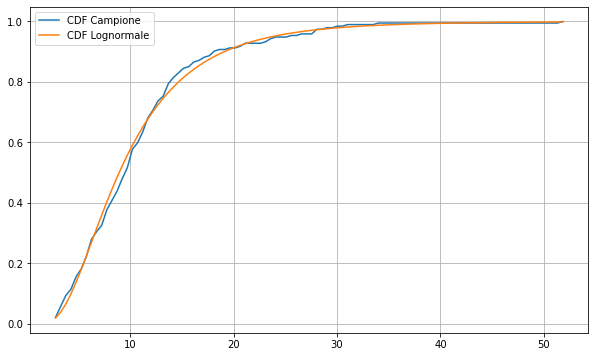

In [57]:
hist, bin_edges = np.histogram(suicides2017["Suicide rate (age-standardized)"],bins=100,density=True)
cumsumTasSui = np.cumsum(hist)
cumsumTasSui = cumsumTasSui/cumsumTasSui[-1]

cumsumLognorm = g.cdf(bin_edges[1:])

plt.figure(figsize=(10,6))
plt.plot(bin_edges[1:],cumsumTasSui)
plt.plot(bin_edges[1:],cumsumLognorm)
plt.grid()
plt.legend(['CDF Campione','CDF Lognormale'])
plt.show()

Dalla CDF si può vedere come la lognormale approssimi bene la densità.

In [58]:
testKSLognorm=kstest(suicides2017["Suicide rate (age-standardized)"],"lognorm",args=g.args)
KSstatisticLognorm = testKSLognorm[0]
pvalueLognorm = testKSLognorm[1]

testKSLognorm

KstestResult(statistic=0.054761848941142166, pvalue=0.5863592144486764)

dato che il p-value non è minore di 0.05, non si può negare il fatto che la densità può essere approssimata tramite una lognormale (ipotesi nulla).

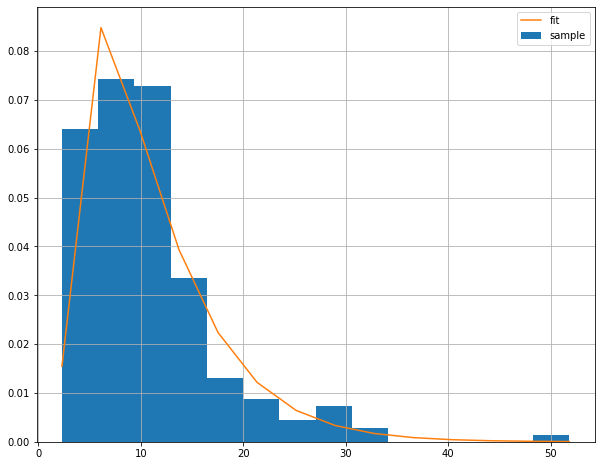

In [59]:
# Fit funzione Gamma per i tassi di suicidio
plt.figure(figsize=(10,8))
g=gamma(*gamma.fit(suicides2017["Suicide rate (age-standardized)"]))
x=np.linspace(suicides2017["Suicide rate (age-standardized)"].min(),suicides2017["Suicide rate (age-standardized)"].max(),n_binsSingoloAnnoSuicides)
plt.hist(suicides2017["Suicide rate (age-standardized)"],bins=n_binsSingoloAnnoSuicides,density=True)
plt.plot(x,g.pdf(x))
plt.grid()
plt.legend(['fit','sample'])
plt.show()

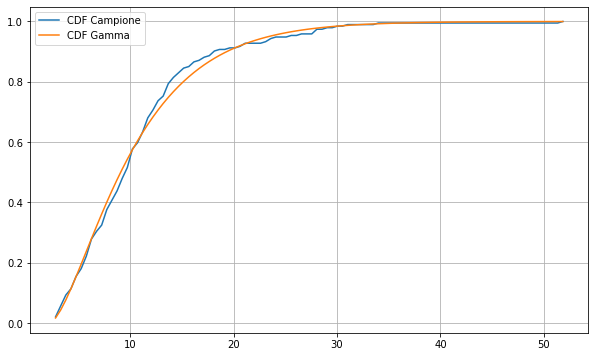

In [60]:
hist, bin_edges = np.histogram(suicides2017["Suicide rate (age-standardized)"],bins=100,density=True)
cumsumTasSuiGam = np.cumsum(hist)
cumsumTasSuiGam = cumsumTasSuiGam/cumsumTasSuiGam[-1]

cumsumGam = g.cdf(bin_edges[1:])

plt.figure(figsize=(10,6))
plt.plot(bin_edges[1:],cumsumTasSuiGam)
plt.plot(bin_edges[1:],cumsumGam)
plt.grid()
plt.legend(['CDF Campione','CDF Gamma'])
plt.show()

In [61]:
testKSGamma=kstest(suicides2017["Suicide rate (age-standardized)"],"gamma",args=g.args)
KSstatisticGamma = testKSGamma[0]
pvalueGamma = testKSGamma[1]

testKSGamma

KstestResult(statistic=0.05583310077174575, pvalue=0.561647177144471)

Sia la funzione Gamma che la Lognormale sembrano approssimare bene la distribuzione dei suicidi.

## 4.2.6 Conclusioni sull'analisi della densità

Le densità che approssimano meglio i dati sono quella normale per gli score di felicità e la funzione Gamma per i tassi di suicidi.

Questi due risultati sono importanti a comprendere come in molti paesi il tasso di suicidi si mantiene relativamente basso, quindi la felicità delle persone non dovrebbe essere troppo influenzata dal tasso di suicidi.

Queste due distribuzioni fanno notare come la relazione tra i due dataset(ed in particolare tra gli score di felicità ed i tassi di suicidi), non sia così specifica, se le due distribuzioni fossero state le stesse(tutte e due normali o similari) si sarebbe affermato che una correlazione tra le due variabili potrebbe esserci stata, introducendo una associazione tra le due.

Dato che le due distribuzioni sono fondamentalmente differenti non sembra esserci un effettivo collegamento tra le due variabili, si passa quindi all'analisi quantitativa tramite correlazione e covarianza alla ricerca di altre associazioni.

## 4.3 Dataframe completo

In [62]:
suicides2017 = suicides2017.sort_values(by="Suicide rate (age-standardized)")

In [63]:
suicides2017["index"] = range(1, len(suicides2017) + 1)
#suicidesBySex["index"] = range(1, len(suicidesBySex) + 1)

In [64]:
suicides2017.head()

Country Code  year  Male suicide rate (age-standardized)  \
574                Kuwait  KWT  2017                                  3.62   
815                  Oman  OMN  2017                                  4.12   
921          Saudi Arabia  SAU  2017                                  4.47   
41    Antigua and Barbuda  ATG  2017                                  4.64   
1039                Syria  SYR  2017                                  4.90   

      Female suicide rate (age-standardized)  Suicide rate (age-standardized)  \
574                                     0.98                            2.300   
815                                     1.22                            2.670   
921                                     0.88                            2.675   
41                                      0.91                            2.775   
1039                                    1.17                            3.035   

      index  
574       1  
815       2  
921       3  
41        4  
1039      5

In [65]:
full2017 = pd.merge(dataset2017, suicides2017.drop(["Suicide rate (age-standardized)","Code"], axis=1), on=["year","Country"])
full2017 = pd.merge(full2017,infantMortality, on=["year","Country"])
full2017 = pd.merge(full2017,incomeInequality.drop(["Code"],axis=1), on=["year","Country"])
full2017.tail()

Country  rank  Score  Upper_Confidence_Interval  \
123                      Togo   150  3.495                   3.594038   
124                    Rwanda   151  3.471                   3.543030   
125                  Tanzania   153  3.349                   3.461430   
126                   Burundi   154  2.905                   3.074690   
127  Central African Republic   155  2.693                   2.864884   

     Lower_Confidence_Interval       GDP  Social_support  life_Expectancy  \
123                   3.395962  0.305445        0.431883         0.247106   
124                   3.398970  0.368746        0.945707         0.326425   
125                   3.236570  0.511136        1.041990         0.364509   
126                   2.735310  0.091623        0.629794         0.151611   
127                   2.521116  0.000000        0.000000         0.018773   

     FreedomOflife  Generosity  corruption  DystopiaResidual  year  \
123       0.380426    0.196896    0.095665          1.837229  2017   
124       0.581844    0.252756    0.455220          0.540061  2017   
125       0.390018    0.354256    0.066035          0.621130  2017   
126       0.059901    0.204435    0.084148          1.683024  2017   
127       0.270842    0.280876    0.056565          2.066005  2017   

     Male suicide rate (age-standardized)  \
123                                 20.85   
124                                 19.59   
125                                 14.18   
126                                 20.09   
127                                 28.25   

     Female suicide rate (age-standardized)  index Code  \
123                                    5.77    148  TGO   
124                                    5.29    140  RWA   
125                                    3.97     93  TZA   
126                                    5.89    146  BDI   
127                                    7.02    172  CAF   

     Mortality rate, infant (per 1,000 live births)  \
123                                            51.9   
124                                            31.4   
125                                            41.0   
126                                            45.9   
127                                            91.6   

     GINI index (World Bank estimate)   inequality  
123                              43.0       medium  
124                              50.4  medium-high  
125                              37.8   medium-low  
126                              39.2   medium-low  
127                              56.2         high

Il dataset completo è formato da 20 feature, alcune derivate da altre feature (come index, rank o inequality), altre con record nulli, le altre invece dovrebbero essere indipendenti (a meno di relazioni tra le feature non direttamente derivabili).

Precedentemente sono state analizzate statisticamente (con studio di densità e sugli indici) più accurata solo le features dei punteggi di felicità e dei tassi di suicidio.

Durante i prossimi capitoli vengono considerate tutte le feature disponibili con valori non nulli e per ogni singola analisi verranno eliminate le feature derivabili in modo da avere dei modelli significativi. 

## 4.4 Relazioni tra le feature e analisi combinata tra i vari dataset

In questo capitolo si vedono principalmente le relazioni

### 4.4.1 Dipendenze nei dati

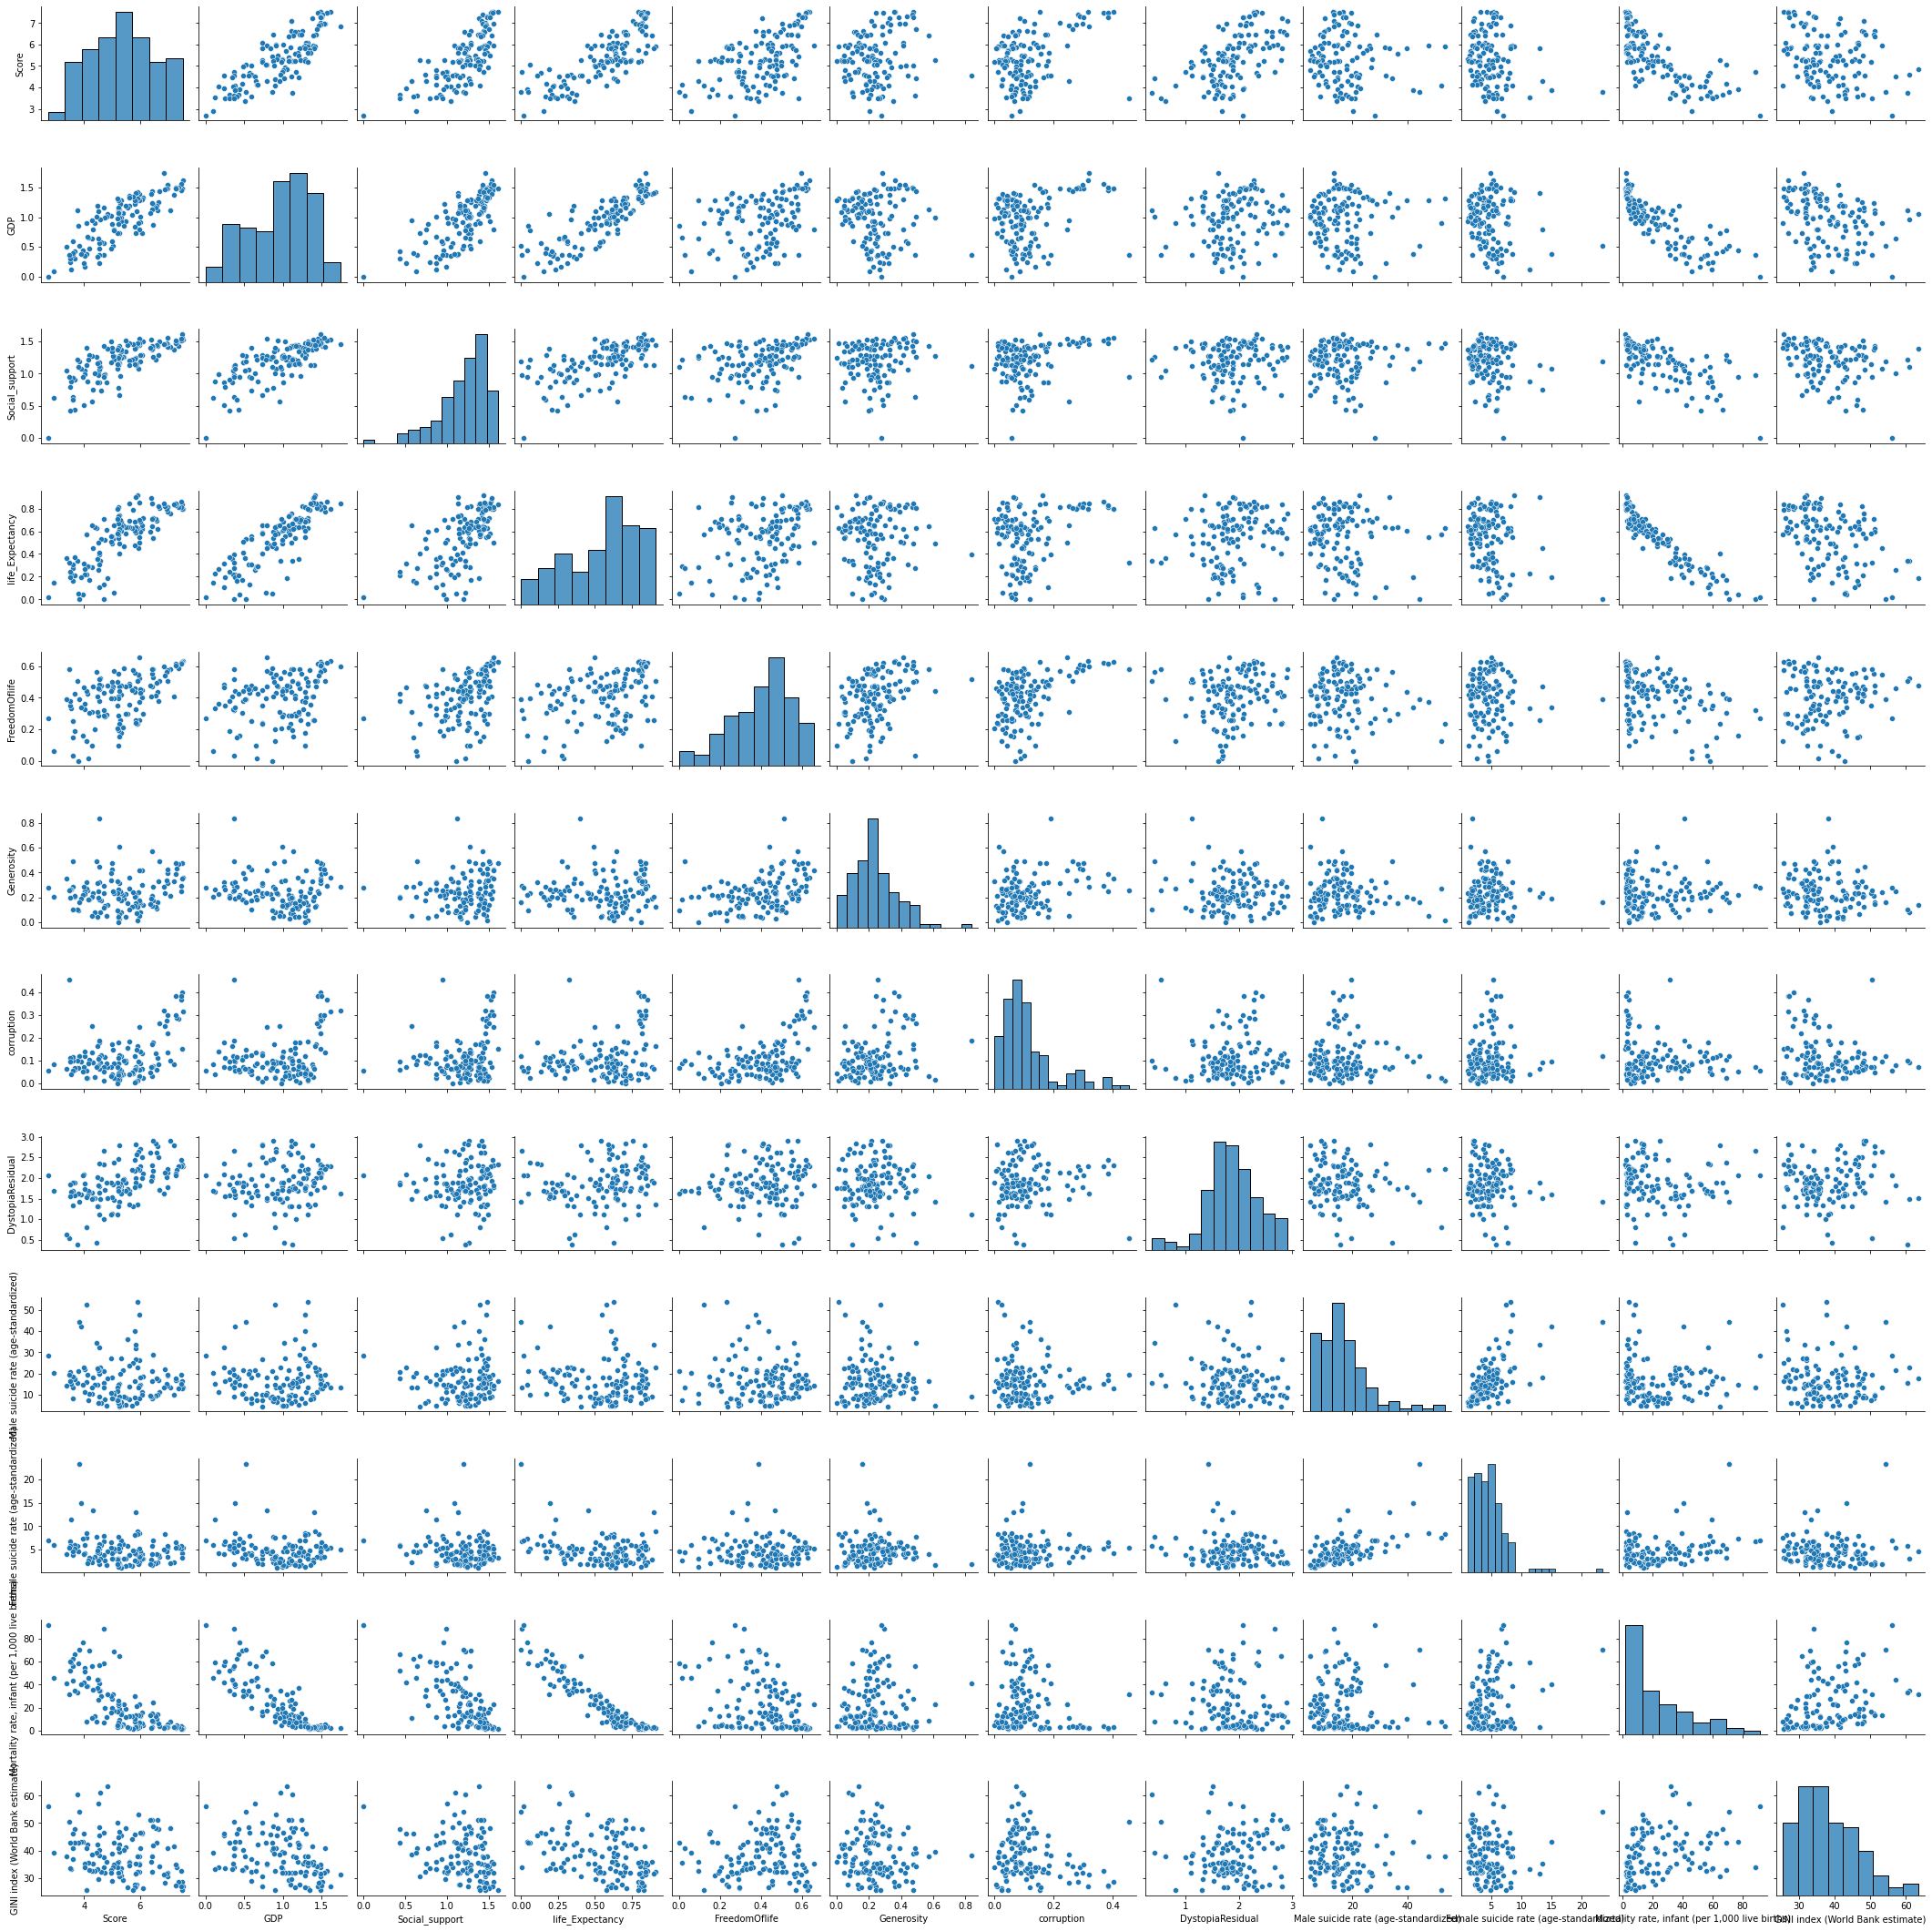

In [66]:
full2017Skimmed = full2017.drop(["rank","index","year","Country","Upper_Confidence_Interval","Lower_Confidence_Interval"],axis=1)
sns.pairplot(full2017Skimmed)

Tralasciando i legami tra i ranghi nelle classifiche (che sono messi in ordine crescente in base al valore degli score o dei tassi di suicidio), si notano dei rapporti tra un paio di feature che non appartengono agli stessi dataset(in particolare si può vedere un collegamento tra life expectancy e mortalità infantile,  o anche Score di felicità e GDP sempre con mortalità infantile).

Altre feature invece non sembrano avere una vera correlazione, per esempio il tasso di suicidi con altre feature non sembra avere particolari associazioni.

Si procede quindi con l'analisi della covarianza.

In [67]:
full2017Skimmed.cov()

Score       GDP  \
Score                                            1.332352  0.386611   
GDP                                              0.386611  0.162947   
Social_support                                   0.245007  0.084414   
life_Expectancy                                  0.219176  0.081213   
FreedomOflife                                    0.095334  0.020753   
Generosity                                       0.025282 -0.003852   
corruption                                       0.043742  0.010421   
DystopiaResidual                                 0.317225  0.030724   
Male suicide rate (age-standardized)            -1.186253 -0.014505   
Female suicide rate (age-standardized)          -0.719985 -0.220194   
Mortality rate, infant (per 1,000 live births) -18.530125 -7.297808   
GINI index (World Bank estimate)                -2.664063 -1.068137   

                                                Social_support  \
Score                                                 0.245007   
GDP                                                   0.084414   
Social_support                                        0.081146   
life_Expectancy                                       0.042906   
FreedomOflife                                         0.017186   
Generosity                                            0.003278   
corruption                                            0.006189   
DystopiaResidual                                      0.009895   
Male suicide rate (age-standardized)                  0.172259   
Female suicide rate (age-standardized)               -0.112958   
Mortality rate, infant (per 1,000 live births)       -4.204742   
GINI index (World Bank estimate)                     -0.643777   

                                                life_Expectancy  \
Score                                                  0.219176   
GDP                                                    0.081213   
Social_support                                         0.042906   
life_Expectancy                                        0.055753   
FreedomOflife                                          0.012529   
Generosity                                             0.000615   
corruption                                             0.005601   
DystopiaResidual                                       0.020565   
Male suicide rate (age-standardized)                  -0.266131   
Female suicide rate (age-standardized)                -0.190088   
Mortality rate, infant (per 1,000 live births)        -4.788907   
GINI index (World Bank estimate)                      -0.838715   

                                                FreedomOflife  Generosity  \
Score                                                0.095334    0.025282   
GDP                                                  0.020753   -0.003852   
Social_support                                       0.017186    0.003278   
life_Expectancy                                      0.012529    0.000615   
FreedomOflife                                        0.022292    0.007136   
Generosity                                           0.007136    0.018627   
corruption                                           0.006732    0.003532   
DystopiaResidual                                     0.008706   -0.004058   
Male suicide rate (age-standardized)                -0.112527   -0.130432   
Female suicide rate (age-standardized)              -0.003206   -0.007559   
Mortality rate, infant (per 1,000 live births)      -1.083829    0.116731   
GINI index (World Bank estimate)                     0.082967   -0.144490   

                                                corruption  DystopiaResidual  \
Score                                             0.043742          0.317225   
GDP                                               0.010421          0.030724   
Social_support                                    0.006189          0.009895   
life_Expectancy                                   0.005601          0.02056

Contrariamente a quanto atteso, molte associazioni tra le feature portano a valori di covarianza abbastanti discordanti dallo 0 (dove potrebbe indicare indipendenza ed specialmente incorrelazione tra le variabili, anche se avere covarianza nulla non è sufficente ma necessario per avere indipendenza tra le variabili).

Non bisogna saltare comunque a conclusioni troppo affrettate sulla correlazione tra le varie variabili, dato che la correlazione può soltanto dire quanto siano correlate-dipendenti le feature coinvolte, ma la potenza della correlazione non è stata ancora analizzata.
Inoltre la covarianza non riesce a considerare casi dove le relazioni coinvolte siano più complicate, per esempio in relazioni non lineari o nella creazione di cluster tra le feature coinvolte.

Si procede quindi con l'analisi della correlazione.

In [68]:
full2017Skimmed.corr()

Score       GDP  \
Score                                           1.000000  0.829740   
GDP                                             0.829740  1.000000   
Social_support                                  0.745136  0.734105   
life_Expectancy                                 0.804177  0.852058   
FreedomOflife                                   0.553174  0.344334   
Generosity                                      0.160485 -0.069911   
corruption                                      0.412638  0.281114   
DystopiaResidual                                0.551234  0.152663   
Male suicide rate (age-standardized)           -0.106896 -0.003738   
Female suicide rate (age-standardized)         -0.211219 -0.184715   
Mortality rate, infant (per 1,000 live births) -0.742366 -0.836024   
GINI index (World Bank estimate)               -0.279077 -0.319958   

                                                Social_support  \
Score                                                 0.745136   
GDP                                                   0.734105   
Social_support                                        1.000000   
life_Expectancy                                       0.637895   
FreedomOflife                                         0.404072   
Generosity                                            0.084304   
corruption                                            0.236592   
DystopiaResidual                                      0.069671   
Male suicide rate (age-standardized)                  0.062899   
Female suicide rate (age-standardized)               -0.134277   
Mortality rate, infant (per 1,000 live births)       -0.682582   
GINI index (World Bank estimate)                     -0.273269   

                                                life_Expectancy  \
Score                                                  0.804177   
GDP                                                    0.852058   
Social_support                                         0.637895   
life_Expectancy                                        1.000000   
FreedomOflife                                          0.355386   
Generosity                                             0.019091   
corruption                                             0.258292   
DystopiaResidual                                       0.174690   
Male suicide rate (age-standardized)                  -0.117235   
Female suicide rate (age-standardized)                -0.272610   
Mortality rate, infant (per 1,000 live births)        -0.937892   
GINI index (World Bank estimate)                      -0.429507   

                                                FreedomOflife  Generosity  \
Score                                                0.553174    0.160485   
GDP                                                  0.344334   -0.069911   
Social_support                                       0.404072    0.084304   
life_Expectancy                                      0.355386    0.019091   
FreedomOflife                                        1.000000    0.350207   
Generosity                                           0.350207    1.000000   
corruption                                           0.490951    0.281783   
DystopiaResidual                                     0.116955   -0.059639   
Male suicide rate (age-standardized)                -0.078393   -0.099404   
Female suicide rate (age-standardized)              -0.007272   -0.018754   
Mortality rate, infant (per 1,000 live births)      -0.335687    0.039551   
GINI index (World Bank estimate)                     0.067192   -0.128012   

                                                corruption  DystopiaResidual  \
Score                                             0.412638          0.551234   
GDP                                               0.281114          0.152663   
Social_support                                    0.236592          0.069671   
life_Expectancy                                   0.258292          0.174690   
Freedom

Si ricorre inoltre ad una heatmap per visualizzare la correlazione,

<AxesSubplot:>

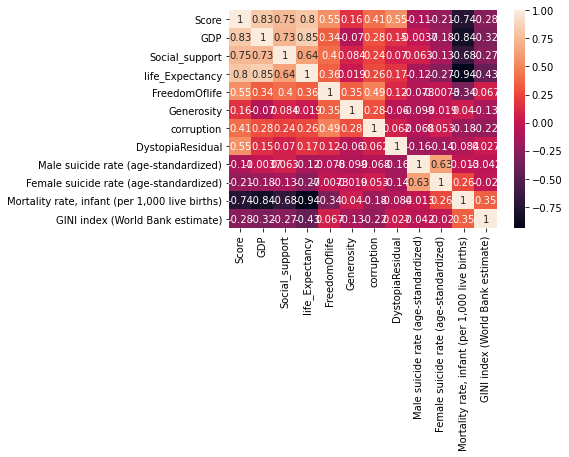

In [69]:
sns.heatmap(full2017Skimmed.corr(), annot = True)

La funzione di pandas calcola l'indice di correlazione di Pearson di default, questo indice è indipendente dalla scala delle singole feature (dato che avviene una standardizzazione dei valori, che rientrano ora tra [-1,1], dove -1 significa che le feature sono correlate in modo inversamente proporzionale, mentre +1 in modo direttamente proporzionale).

E' importante notare che la correlazione di Pearson è un test di tipo parametrico perché presuppone delle caratteristiche sui dati sottostanti, in particolare presume la **normalità** dei dati sottostanti, in seguito si vedranno dei test non parametrici.

La correlazione di Pearson è inoltre molto sensibile agli outlier, e nel dataset dei tassi di suicidio era già stata notata la presenza di valori molto alti in quantità minimali rispetto a tutto il dataset, quindi durante questa analisi di correlazione con Pearson si attendono risultati contrastanti.

Dai valori ottenuti si vede quindi che molte feature che precedentemente avevano valori di covarianza alti hanno ottenuto valori di correlazione molto bassi(rango degli score di felicità ed indici dei tassi di suicidio), quindi sono tecnicamente incorrelate.

Come era stato visto invece sembra esserci una forte correlazione negativa tra la mortalità infantile e la life expectancy.
Altre feature sembrano correlate negativamente o positivamente, come standard si definisce:
> - $|\rho_{xy}|$ = $|\frac{\sigma_{xy}}{\sigma_{x}\sigma_{y}}|$ < 0.3 si dirà che le feature sono incorrelate
> - 0.3 $\leq |\rho_{xy}|$ = $|\frac{\sigma_{xy}}{\sigma_{x}\sigma_{y}}|$ < 0.4 si dirà che le feature sono quasi incorrelate
> - 0.4 $\leq|\rho_{xy}|$ = $|\frac{\sigma_{xy}}{\sigma_{x}\sigma_{y}}|$ < 0.6 si dirà che le feature sono lievemente correlate
> - 0.6 $\leq|\rho_{xy}|$ = $|\frac{\sigma_{xy}}{\sigma_{x}\sigma_{y}}|$ < 0.8 si dirà che le feature sono moderatamente correlate
> - $|\rho_{xy}|$ = $|\frac{\sigma_{xy}}{\sigma_{x}\sigma_{y}}|\geq$  0.8 si dirà che le feature sono fortemente correlate

Per le correlazioni promettenti verrà inoltre vista la valenza statistica degli indici di Pearson tramite la seguente funzione con esempio per la correlazione tra life_expectancy e Mortality rate

In [70]:
from scipy.stats import pearsonr
pearCoeff = pearsonr(full2017Skimmed['life_Expectancy'],full2017Skimmed['Mortality rate, infant (per 1,000 live births)'])
pearCoeff

(-0.9378924961136714, 8.874086509520274e-60)

Dove l'ipotesi nulla è quella in cui le due variabili sono incorrelate e le associazioni-dipendenze risultanti derivano dal caso, mentre l'ipotesi alternativa è quella per cui le due variabili sono correlate ed una correlazione simile a quella ottenuta è quasi impossibile da replicare in modo random.

Quindi la correlazione tra life expectancy e infant mortality rate è forte, le due variabili sono anticorrelate(inversamente proporzionali), ed il risultato ottenuto e rilevante statisticamente(p-value<0.01)

Per il calcolo di una correlazione che non sia lineare e che sia non parametrica vengono visti altri indici (Spearman,Kendall).

In [71]:
full2017Skimmed.corr(method="spearman")

Score       GDP  \
Score                                           1.000000  0.819583   
GDP                                             0.819583  1.000000   
Social_support                                  0.770107  0.754229   
life_Expectancy                                 0.807466  0.875137   
FreedomOflife                                   0.533533  0.365707   
Generosity                                      0.126778 -0.056543   
corruption                                      0.263326  0.163821   
DystopiaResidual                                0.592406  0.192181   
Male suicide rate (age-standardized)           -0.096549  0.027345   
Female suicide rate (age-standardized)         -0.174172 -0.107386   
Mortality rate, infant (per 1,000 live births) -0.778681 -0.895859   
GINI index (World Bank estimate)               -0.259701 -0.381949   

                                                Social_support  \
Score                                                 0.770107   
GDP                                                   0.754229   
Social_support                                        1.000000   
life_Expectancy                                       0.662899   
FreedomOflife                                         0.484132   
Generosity                                            0.097761   
corruption                                            0.197085   
DystopiaResidual                                      0.143827   
Male suicide rate (age-standardized)                  0.091519   
Female suicide rate (age-standardized)               -0.069503   
Mortality rate, infant (per 1,000 live births)       -0.707531   
GINI index (World Bank estimate)                     -0.300085   

                                                life_Expectancy  \
Score                                                  0.807466   
GDP                                                    0.875137   
Social_support                                         0.662899   
life_Expectancy                                        1.000000   
FreedomOflife                                          0.346840   
Generosity                                             0.025127   
corruption                                             0.140651   
DystopiaResidual                                       0.231671   
Male suicide rate (age-standardized)                  -0.078889   
Female suicide rate (age-standardized)                -0.170288   
Mortality rate, infant (per 1,000 live births)        -0.942687   
GINI index (World Bank estimate)                      -0.413851   

                                                FreedomOflife  Generosity  \
Score                                                0.533533    0.126778   
GDP                                                  0.365707   -0.056543   
Social_support                                       0.484132    0.097761   
life_Expectancy                                      0.346840    0.025127   
FreedomOflife                                        1.000000    0.370886   
Generosity                                           0.370886    1.000000   
corruption                                           0.448773    0.204965   
DystopiaResidual                                     0.157171    0.054174   
Male suicide rate (age-standardized)                 0.011522    0.003645   
Female suicide rate (age-standardized)               0.033883    0.124362   
Mortality rate, infant (per 1,000 live births)      -0.330321   -0.001102   
GINI index (World Bank estimate)                     0.029507   -0.119892   

                                                corruption  DystopiaResidual  \
Score                                             0.263326          0.592406   
GDP                                               0.163821          0.192181   
Social_support                                    0.197085          0.143827   
life_Expectancy                                   0.140651          0.231671   
Freedom

<AxesSubplot:>

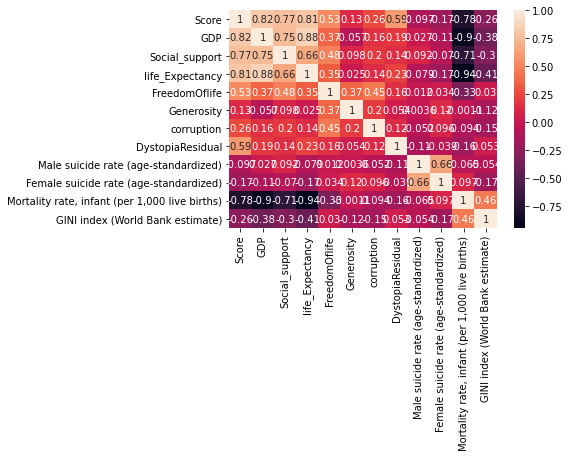

In [72]:
sns.heatmap(full2017Skimmed.corr(method="spearman"), annot = True)

In [73]:
from scipy.stats import spearmanr
spearCoeff = spearmanr(full2017Skimmed['life_Expectancy'],full2017Skimmed['Mortality rate, infant (per 1,000 live births)'])
spearCoeff

SpearmanrResult(correlation=-0.9426874258263297, pvalue=6.534772796911794e-62)

L'indice di correlazione di Spearman è un indice non-parametrico (non si fanno assunzioni sulle caratteristiche dei dati) che indica quanto bene la relazione tra due feature/variabili può essere approssimata tramite una funzione monotona. I valori ottenuti sono abbastanza concordi con l'indice di Pearson.



In [74]:
full2017Skimmed.corr(method="kendall")

Score       GDP  \
Score                                           1.000000  0.632045   
GDP                                             0.632045  1.000000   
Social_support                                  0.569776  0.564222   
life_Expectancy                                 0.598080  0.680364   
FreedomOflife                                   0.383214  0.258120   
Generosity                                      0.078267 -0.056841   
corruption                                      0.183854  0.102608   
DystopiaResidual                                0.407088  0.123278   
Male suicide rate (age-standardized)           -0.060308  0.011812   
Female suicide rate (age-standardized)         -0.112706 -0.079921   
Mortality rate, infant (per 1,000 live births) -0.581552 -0.704368   
GINI index (World Bank estimate)               -0.177984 -0.259819   

                                                Social_support  \
Score                                                 0.569776   
GDP                                                   0.564222   
Social_support                                        1.000000   
life_Expectancy                                       0.477362   
FreedomOflife                                         0.349902   
Generosity                                            0.059547   
corruption                                            0.132874   
DystopiaResidual                                      0.093996   
Male suicide rate (age-standardized)                  0.064969   
Female suicide rate (age-standardized)               -0.042731   
Mortality rate, infant (per 1,000 live births)       -0.521038   
GINI index (World Bank estimate)                     -0.201369   

                                                life_Expectancy  \
Score                                                  0.598080   
GDP                                                    0.680364   
Social_support                                         0.477362   
life_Expectancy                                        1.000000   
FreedomOflife                                          0.242618   
Generosity                                             0.010335   
corruption                                             0.090059   
DystopiaResidual                                       0.143209   
Male suicide rate (age-standardized)                  -0.055863   
Female suicide rate (age-standardized)                -0.122529   
Mortality rate, infant (per 1,000 live births)        -0.795541   
GINI index (World Bank estimate)                      -0.281769   

                                                FreedomOflife  Generosity  \
Score                                                0.383214    0.078267   
GDP                                                  0.258120   -0.056841   
Social_support                                       0.349902    0.059547   
life_Expectancy                                      0.242618    0.010335   
FreedomOflife                                        1.000000    0.247539   
Generosity                                           0.247539    1.000000   
corruption                                           0.312992    0.124016   
DystopiaResidual                                     0.099409    0.032480   
Male suicide rate (age-standardized)                 0.007629   -0.000246   
Female suicide rate (age-standardized)               0.024752    0.081399   
Mortality rate, infant (per 1,000 live births)      -0.232982    0.010473   
GINI index (World Bank estimate)                     0.028485   -0.077810   

                                                corruption  DystopiaResidual  \
Score                                             0.183854          0.407088   
GDP                                               0.102608          0.123278   
Social_support                                    0.132874          0.093996   
life_Expectancy                                   0.090059          0.143209   
Freedom

<AxesSubplot:>

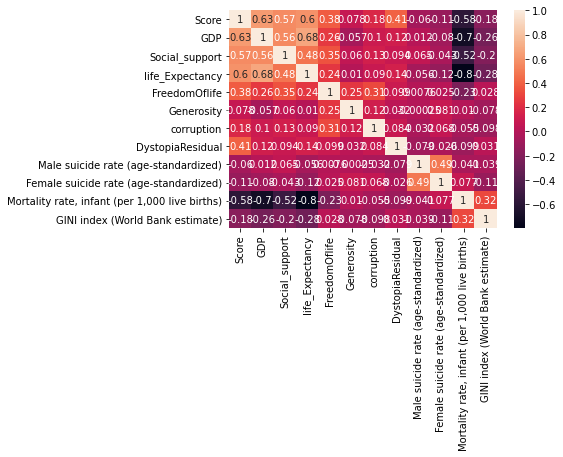

In [75]:
sns.heatmap(full2017Skimmed.corr(method="kendall"), annot = True)

In [76]:
from scipy.stats import kendalltau
kendCoeff = kendalltau(full2017Skimmed['life_Expectancy'],full2017Skimmed['Mortality rate, infant (per 1,000 live births)'])
kendCoeff

KendalltauResult(correlation=-0.7955407480147141, pvalue=2.2993326320212597e-40)

Anche la correlazione di Kendall fornisce un risultato abbastanza alto, in particolare questo risultato definisce che i ranghi dei vari record sono concordi tra di loro.

Sia l'indice di correlazione di Spearman che quello di Kendall si basano sul concetto di rango e di posizionamento nella classifica, quindi da un punto di vista concettuale, sarebbero i migliori indici da utilizzare per il tipo di dati fornito(che era una classifica in principio), in particolare l'indice di Spearman fornisce un buonissimo risultato dato che è ottimo per la situazione presentata nei vari dataset forniti e per la quantità di record/gradi di libertà presenti (oltre al fatto che fornisce la rilevanza statistica migliore rispetto agli altri coefficenti).

In [77]:
print("Indice di correlazione di Pearson:",pearCoeff[0])
print("Indice di correlazione di Spearman:",spearCoeff[0])
print("Indice di correlazione di Kendall:",kendCoeff[0])

Indice di correlazione di Pearson: -0.9378924961136714
Indice di correlazione di Spearman: -0.9426874258263297
Indice di correlazione di Kendall: -0.7955407480147141


Si conclude che per abbastanza coppie di feature, tutti gli indici sembrano concordi con i risultati ottenuti, quindi si valuta la correlazione sulla base del solo coefficente di Spearman o Pearson (dato che forniscono più o meno gli stessi risultati). 

### Conclusioni analisi statistica

In conclusione per questa analisi di correlazione tra le varie variabili, si può quindi supporre che:
> - Il rango degli stati con gli score di felicità più alti è praticamente incorrelato con il rango degli stati con i tassi di suicidi più bassi.
> - Lo score di felicità è fortemente correlato al GDP, ed è moderatamente anticorrelato alla mortalità infantile.
> - Gli indici di Generosity(generosità percepita in quel paese) corruption (corruzione percepita in quel paese) DystopiaResidual(distanza dal peggior paese immaginabile,cioè una distopia) sono praticamente incorrelati con qualsiasi altra feature(tranne per lo score di felicità, dove distopiaResidual e corruption sono quasi incorrelate o lievemente correlate).
> - La mortalità infantile è moderatamente o fortemente correlata con Score di felicità ,GDP ,Social_support e life_Expectancy, mentre è quasi o completamente incorrelata con tutto il resto.
> - Il gini index ha una leggera correlazione con la mortalità infantile e la life expectancy, mentre è quasi incorrelato o incorrelato con il resto.

La conclusione per cui score di felicità e tasso di suicidi siano praticamente incorrelate era stata già introdotta durante l'analisi delle densità, ed è comunque un buon risultato, dato che in una situazione attesa ideale per quello che comporta la felicità(secondo il pensiero comune), la felicità dovrebbe essere come minimo moderatamente anticorrelata al tasso di suicidi, cosa che non accade in questo caso.
Questo significa che lo score di felicità sembra non rispecchiare realmente il benessere o malessere di una popolazione, data la grande quantità di stati in cui i morti per suicidi sono abbastanza da dover far preoccupare la maggior parte delle persone.
Da un altro punto di vista questo risultato potrebbe essere vista come la difficolta e complessità del problema, che tiene conto di molte situazioni personali dei singoli individui, e che quindi non può essere misurato da un indice globale(oltre al fatto che gli indici forniti sono presi e dedotti dalla popolazione, quindi non terrebbero mai in considerazione altre misure utili che dipenderebbero dai singoli individui).

Molto interessante è il risultato ottenuto tramite il confronto con la mortalità infantile di uno stato, che sembra correlarsi con quasi tutte le feature più importanti, la mortalità infantile tiene conto di tutte le morti avvenute prima dei 5 anni, che comprendono aborti e altri tipi di decesso, che potrebbero essere causa di sconforto o tristezza inerente.

Inoltre, la mortalità infantile potrebbe essere vista come un indicatore della qualità sia di vita che della gestione sanitaria nel territorio, dato che più morti infantili ci sono, più è mal gestita la sanità in una regione (o almeno questa potrebbe essere una causa).

### 4.4.2 Predizione tramite regressione

Tramite l'analisi precedentemente fatta sulla correlazione tra le feature disponibili, alcune feature potrebbero essere tralasciate per l'analisi e la predizione dell'indice di felicità, ma si lasceranno comunque dato che durante l'analisi della regressione potrebbero o portare sorprese inattese (per relazioni non lineari) oppure riconfermarsi come feature inutilizzabili per la predizione degli score.

Alla fine dell'analisi di regressione inoltre viene fatta una cross-validation non solo per validare il modello (che per regressione lineare è praticamente ridondante dato che viene già fatto dagli indici di qualità già utilizzati come $R^2$ o la F-statistic, anche se con la validazione si controllano altri concetti indipendenti dal singolo sample), cioè non serve solo per combattere l'overfitting (che nel caso di regressione con variabili linerari non si ritrova in modo significativo), ma anche per valutare il modello non solo nelle performance (con lo score di accuratezza o qualsiasi score di goodness, che però non riescono a descrivere bene dei concetti che sono essenziali per la qualità di un modello) per capire quale sia il modello migliore, ma anche negli errori con deviazione risultante che servono per alzare dei sospetti nel caso in cui vi sia una deviazionea abbastanza alta.

Vengono visti brevemente i plot più promettenti tra le feature che sembrano correlate e quelle che sono significative per questa analisi.

Di seguito si vede il plot dei ranghi dei valori degli score con i ranghi dei valori dei tassi di suicidio. Per avere dei buoni risultati, ci si aspetta che i due ranghi per i singoli indici siano correlati in modo positivo, ci sia quindi una retta che sia molto vicina ai punti plottati.

<AxesSubplot:xlabel='rank', ylabel='index'>

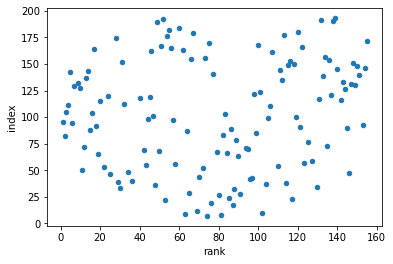

In [78]:
full2017.plot.scatter(x="rank",y="index")

Come si era già visto precedentemente, gli score di felicità ed il tasso di suicidi sembrano essere incorrelati(in questo caso vengono confrontati ri ranghi ma il concetto resta lo stesso) e, come si può vedere dallo scatterplot, continuano ad esserlo pure con questa rappresentazione visuale, dato che non sembrano trasparirire elementi significativi ed i singoli record dei ranghi sembrano abbastanza sparsi(una retta di regressione passerebbe per il centro di questo plot, con dei residui particolarmente grandi e varianza dei residui alta).

C:\Users\giorg\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



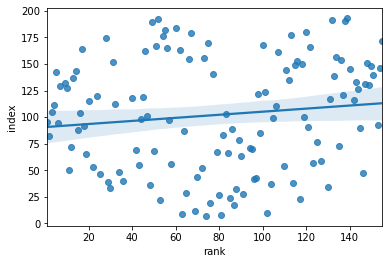

In [79]:
sns.regplot('rank','index',full2017)
plt.show()

I risultati sono deludenti dato che la retta di regressione calcolata dalla libreria seaborn è abbastanza lontana dalla maggior parte dei punti.

Si vede ora il modello effettivo costruito con la libreria di **statsmodels**

In [80]:
from statsmodels.formula.api import ols
model = ols("rank ~ index",full2017).fit()

#visualizziamo i parametri del modello
model.params

Intercept    68.084206
index         0.107597
dtype: float64

In [81]:
fitted = model.predict(full2017["index"])
residuals = full2017["rank"] - fitted
numPredictors = 1
RSS = np.sum(np.square(residuals))
RSE = np.sqrt(RSS/(full2017.shape[0]-numPredictors- 1))
TSS = np.square(full2017["rank"] - full2017["rank"].mean()).sum()
R2 = 1 - RSS/TSS
print("RSS: ",RSS)
print("RSE: ",RSE)
print("TSS: ",TSS)
print("R^2: ",R2)

RSS:  256907.29597914385
RSE:  45.154698465223625
TSS:  260969.5
R^2:  0.015565819074091602


In [82]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rank   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.992
Date:                Sat, 09 Jan 2021   Prob (F-statistic):              0.161
Time:                        13:56:48   Log-Likelihood:                -668.31
No. Observations:                 128   AIC:                             1341.
Df Residuals:                     126   BIC:                             1346.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     68.0842      8.742      7.788      0.000      50.784      85.384
index          0.1076      0.076      1.411      0.161      -0.043       0.258
==============================================================================
Omnibus:                       46.792   Durbin-Watson:                   0.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                7.965
Skew:                          -0.137   Prob(JB):                       0.0186
Kurtosis:                       1.809   Cond. No.                         251.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Come si può vedere dai vari indici e dalla rilevanza statistica del parametro collegato ad index (dove l'ipotesi nulla afferma che il parametro sia 0) e da $R^2$ molto vicino allo 0, risulta un modello inesatto, con residui molto grandi e una approssimazione inutilizzabile dei valori reali, quindi un modello inutile.

Non ha molto senso confrontare i ranghi dei singoli stati, potrebbe avere più senso confrontare le percentuali, ma esse stesse sono leggermente biased in base all'età degli individui del campione che è stato utilizzato (nonostante i dati siano nazionali, non è detto siano attendibili come popolazione, oltre al fatto che potrebbero non essere abbastanza attendibili come osservato precedentemente), quindi le misure utilizzate per i vari confronti dovrebbero essere normalizzate in base all'età(media e varianza, anche se molti studi affermano di aver preso dati di censimenti, che saranno comunque un campione abbastanza grande da essere considerato valido come popolazione) del campione preso in esempio, cosa che viene fatta il tasso di suicidi, che si è visto comunque non essere molto correlato con le altre variabili.

<AxesSubplot:xlabel='rank', ylabel='GDP'>

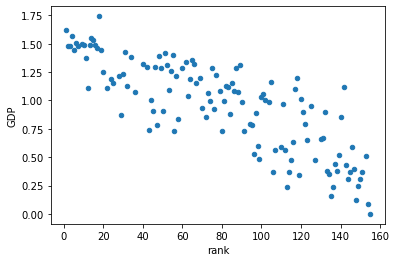

In [83]:
full2017.plot.scatter(x="rank",y="GDP")

Come era stato osservato precedentemente, lo score di felicità ed il GDP sembrano essere correlati da una relazione lineare.

<AxesSubplot:xlabel='Score', ylabel='Mortality rate, infant (per 1,000 live births)'>

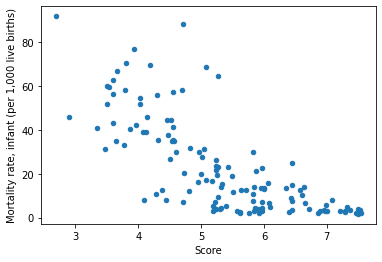

In [84]:
full2017.plot.scatter(x="Score",y="Mortality rate, infant (per 1,000 live births)")

Gli score di felicità sembrano essere lievemente relazionati alla mortalità infantile in una relazione non-lineare(quadratica o esponenziale).

<AxesSubplot:xlabel='life_Expectancy', ylabel='Mortality rate, infant (per 1,000 live births)'>

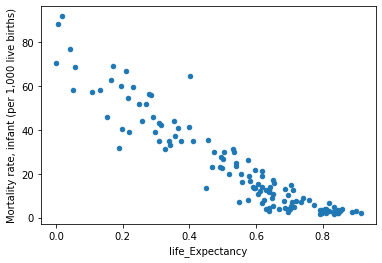

In [85]:
full2017.plot.scatter(x="life_Expectancy",y="Mortality rate, infant (per 1,000 live births)")

l'aspettativa di vita sembra essere molto correlata con la mortalità infantile in una relazione o lineare oppure esponenziale.

Si procede quindi ad una modellazione di un modello di regressione per la predizione degli score di felicità a partire dalle altre feature presenti.


### 4.4.3 Costruzione del modello


I modelli utilizzati saranno modelli di regressione lineare e non lineare, inoltre verrà effettuata una scelta delle feature di tipo backward-stepwise, cioè una selezione delle feature da non utilizzare durante il calcolo dei parametri ottimi per la regressione, calcolando come prima cosa  la regressione(lineare o non) su tutte le feature, ed attuando un criterio di uscita della feature (azzeramento del parametro collegato) attuato attraverso la scelta dello z-score minore collegato(p-value maggiore), cioè quelle feature che contribuiscono o in modo minimale alla retta di regressione, oppure nei casi di multicollinearità, dove una o più variabili sono correlate ad altre variabili, diminuendo la correttezza del modello ed aggiungendo ridondanza (anche se l'analisi e la complessità della multicollinearità è molto più difficile da analizzare).

Per testare la goodness of fit del modello e validarlo verranno utilizzate tutte le misure che vengono notoriamente usate, quali $R^2$ , F-statistic, analisi visuale ed interpretazione del modello con le sue caratteristiche.

Verranno anche viste le misure corrette (in modo da non appoggiare troppo sulle misure tradizionali che soffrono di sensibilità agli outlier, alla scala delle feature, o altri tecnicismi che potrebbero minare l'analisi).

In [86]:
responses = full2017[["Country","Score"]]
full2017Dummies = pd.get_dummies(full2017.drop(["year","Upper_Confidence_Interval","Lower_Confidence_Interval","Score","GINI index (World Bank estimate)","Code","rank","index"],axis=1), columns=['inequality'])
full2017Dummies

Country       GDP  Social_support  life_Expectancy  \
0                      Norway  1.616463        1.533524         0.796667   
1                     Denmark  1.482383        1.551122         0.792566   
2                     Iceland  1.480633        1.610574         0.833552   
3                 Switzerland  1.564980        1.516912         0.858131   
4                     Finland  1.443572        1.540247         0.809158   
..                        ...       ...             ...              ...   
123                      Togo  0.305445        0.431883         0.247106   
124                    Rwanda  0.368746        0.945707         0.326425   
125                  Tanzania  0.511136        1.041990         0.364509   
126                   Burundi  0.091623        0.629794         0.151611   
127  Central African Republic  0.000000        0.000000         0.018773   

     FreedomOflife  Generosity  corruption  DystopiaResidual  \
0         0.635423    0.362012    0.315964          2.277027   
1         0.626007    0.355280    0.400770          2.313707   
2         0.627163    0.475540    0.153527          2.322715   
3         0.620071    0.290549    0.367007          2.276716   
4         0.617951    0.245483    0.382612          2.430182   
..             ...         ...         ...               ...   
123       0.380426    0.196896    0.095665          1.837229   
124       0.581844    0.252756    0.455220          0.540061   
125       0.390018    0.354256    0.066035          0.621130   
126       0.059901    0.204435    0.084148          1.683024   
127       0.270842    0.280876    0.056565          2.066005   

     Male suicide rate (age-standardized)  \
0                                   13.24   
1                                   12.84   
2                                   16.61   
3                                   15.16   
4                                   19.54   
..                                    ...   
123                                 20.85   
124                                 19.59   
125                                 14.18   
126                                 20.09   
127                                 28.25   

     Female suicide rate (age-standardized)  \
0                                      5.40   
1                                      4.26   
2                                      3.26   
3                                      5.09   
4                                      5.81   
..                                      ...   
123                                    5.77   
124                                    5.29   
125                                    3.97   
126                                    5.89   
127                                    7.02   

     Mortality rate, infant (per 1,000 live births)  inequality_high  \
0                                               2.2                0   
1                                               3.6                0   
2                                               1.7                0   
3                                               3.8                0   
4                                               2.0                0   
..                                              ...              ...   
123                                            51.9                0   
124                                            31.4                0   
125                                            41.0                0   
126                                            45.9                0   
127                                            91.6                1   

     inequality_low  inequality_medium  inequality_medium-high  \
0                 1                  0                       0   
1                 1                  0                       0   
2                 1                  0                       0   
3                 1                  0                       0   
4                 1                  0 

Sopra sono stati modificati leggermente i dati in modo da avere delle feature in più da utilizzare (derivanti dall'inequalità e che rappresentano variabili/funzioni indicatrici che rapresentano l'appartenenza a quella caratteristica di inequalità, non è stato utilizzato il gini index per mantenere una generalità più grande con la caratteristica di inequalità, dato che il range del gini index è dettato dal dataset utilizzato, quindi si aggiunge varianza per togliere un po' di bias e specificità per l'istanza considerata).

Sono state inoltre tralasciate alcune feature che erano derivate e non fornivano particolare valenza.

In [87]:
from statsmodels.api import OLS
#la notazione y ~ x indica che y è la variabile
#dipendente e x è la variabile indipendente
#le altre variabili del dataframe saranno scartate
model = OLS(responses["Score"],full2017Dummies.drop(["Country"],axis=1)).fit()

#visualizziamo i parametri del modello
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Score   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.533e+08
Date:                Sat, 09 Jan 2021   Prob (F-statistic):               0.00
Time:                        13:56:49   Log-Likelihood:                 873.12
No. Observations:                 128   AIC:                            -1716.
Df Residuals:                     113   BIC:                            -1673.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
GDP                                                1.0000      0.000   6697.410      0.000       1.000       1.000
Social_support                                     0.9998      0.000   6941.563      0.000       1.000       1.000
life_Expectancy                                    0.9996      0.000   2415.116      0.000       0.999       1.000
FreedomOflife                                      1.0001      0.000   4201.124      0.000       1.000       1.001
Generosity                                         1.0003      0.000   4667.162      0.000       1.000       1.001
corruption                                         0.9997      0.000   2941.846      0.000       0.999       1.000
DystopiaResidual                                   1.0000   5.79e-05   1.73e+04      0.000       1.000       1.000
Male suicide rate (age-standardized)            5.489e-06   3.97e-06      1.384      0.169   -2.37e-06    1.33e-05
Female suicide rate (age-standardized)         -1.784e-05   1.26e-05     -1.417      0.159   -4.28e-05    7.11e-06
Mortality rate, infant (per 1,000 live births) -4.774e-06   4.27e-06     -1.118      0.266   -1.32e-05    3.69e-06
inequality_high                                    0.0005      0.000      1.452      0.149      -0.000       0.001
inequality_low                                     0.0006      0.000      1.713      0.089    -9.6e-05       0.001
inequality_medium                                  0.0006      0.000      1.721      0.088   -9.06e-05       0.001
inequality_medium-high                             0.0007      0.000      1.896      0.060   -2.94e-05       0.001
inequality_medium-low                              0.0005      0.000      1.305      0.194      -0.000       0.001
==============================================================================
Omnibus:                       21.283   Durbin-Watson:                   2.166
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                5.671
Skew:                          -0.073   Prob(JB):                       0.0587
Kurtosis:                       1.979   Cond. No.                     1.17e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In questo modello è possibile vedere come molte variabili contribuiscano veramente poco alla regressione, oltre al fatto che possiedono una rilevanza statistica veramente bassa, quindi si procede con un passo di backward elimination per lasciare fuori le feature che non superano i test di rilevanza statistica (tutte le classi di inequalità, i suicidi, il tasso di mortalità infantile,etc...).

In [88]:
model = OLS(responses["Score"],full2017Dummies.drop(["Country","inequality_medium-low","inequality_medium-high","inequality_medium","inequality_low","inequality_high","Mortality rate, infant (per 1,000 live births)","Female suicide rate (age-standardized)","Male suicide rate (age-standardized)"],axis=1)).fit()

#visualizziamo i parametri del modello
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Score   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          6.512e+09
Date:                Sat, 09 Jan 2021   Prob (F-statistic):                        0.00
Time:                        13:56:49   Log-Likelihood:                          865.10
No. Observations:                 128   AIC:                                     -1716.
Df Residuals:                     121   BIC:                                     -1696.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
GDP                  1.0000      0.000   7018.575      0.000       1.000       1.000
Social_support       1.0000      0.000   8744.947      0.000       1.000       1.000
life_Expectancy      1.0000      0.000   4731.969      0.000       1.000       1.000
FreedomOflife        1.0001      0.000   4567.729      0.000       1.000       1.001
Generosity           1.0003      0.000   4798.713      0.000       1.000       1.001
corruption           0.9997      0.000   3033.867      0.000       0.999       1.000
DystopiaResidual     1.0000   4.16e-05   2.41e+04      0.000       1.000       1.000
==============================================================================
Omnibus:                       55.856   Durbin-Watson:                   2.188
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                8.193
Skew:                          -0.086   Prob(JB):                       0.0166
Kurtosis:                       1.772   Cond. No.                         35.2
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Il modello presentato sembra stranamente troppo esatto e specifico dato l'$R^2$ =1 e le varie valenze statistiche(Prob(F-stat) e tutti i pvalue dei parametri, che sono praticamente 0), per testarlo si prendono alcuni dati del 2016, costruendo un test set per vedere come si comporta il modello con dati diversi dal training set.

In [89]:
testset = dataset[dataset["year"]==2018]
testresponses = testset["Score"]
testset = testset[["GDP","Social_support","life_Expectancy","FreedomOflife","Generosity","corruption","DystopiaResidual"]].fillna(0)
testset["Social_support"] = full2017["Social_support"]
testset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156 entries, 0 to 155
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GDP               156 non-null    float64
 1   Social_support    128 non-null    float64
 2   life_Expectancy   156 non-null    float64
 3   FreedomOflife     156 non-null    float64
 4   Generosity        156 non-null    float64
 5   corruption        156 non-null    float64
 6   DystopiaResidual  156 non-null    float64
dtypes: float64(7)
memory usage: 9.8 KB


In [90]:
from sklearn.metrics import r2_score
fitted = model.predict(testset.dropna())
residuals = testresponses - fitted
numPredictors = 7
RSS = np.sum(np.square(residuals))
RSE = np.sqrt(RSS/(testset.shape[0]-numPredictors- 1))
TSS = np.square(testresponses - testresponses.mean()).sum()
R2 = 1- RSS/TSS
#R2 = r2_score(testresponses,fitted)
print("RSS: ",RSS)
print("RSE: ",RSE)
print("TSS: ",TSS)
print("R^2: ",R2)

RSS:  47.00251473900199
RSE:  0.5635464125050489
TSS:  194.26046991666666
R^2:  0.7580438533935133


Dal punteggio $R^2$ si può facilmente vedere come i risultati ottenuti con il training set siano estremamente specifici ed il modello creato non sembra adatto per lo scopo della predizione dei valori, quindi sembra essere un tipico caso di overfitting del modello per l'anno 2017.
Si procede quindi con una strategia alternativa che utilizza il dataset totale(senza distinzione per anno) e costruisce una soluzione utilizzando prima una strategia di LeaveOneOut(con divisione del singolo dataset in training e test) e poi una strategia di cross validation alla ricerca del modello migliore e dell'errore dei modelli creati per questo dataset.

In [91]:
full = pd.merge(dataset, suicidesBySex.drop(["Suicide rate (age-standardized)","Code"], axis=1), on=["year","Country"])
full = pd.merge(full,infantMortality, on=["year","Country"])
responses = full.Score
full = full.drop(["rank","Score","Region","Region","Family","Lower_Confidence_Interval","Upper_Confidence_Interval","Code","Standard_Error","Country"],axis=1).fillna(0)
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 577 entries, 0 to 576
Data columns (total 11 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   GDP                                             577 non-null    float64
 1   life_Expectancy                                 577 non-null    float64
 2   FreedomOflife                                   577 non-null    float64
 3   corruption                                      577 non-null    float64
 4   Generosity                                      577 non-null    float64
 5   DystopiaResidual                                577 non-null    float64
 6   year                                            577 non-null    int64  
 7   Social_support                                  577 non-null    float64
 8   Male suicide rate (age-standardized)            577 non-null    float64
 9   Female suicide rate (age-standardized)     

In [92]:
from sklearn.model_selection import train_test_split
# creazione training e test set
X_train, X_test, y_train, y_test = train_test_split(full, responses, test_size=0.2)

Questa funzione di scikit learn randomizza direttamente i dati di test presi (facendo un sampling senza replacement), e crea due dataset, 1 training set ed un test set.

In [93]:
model = OLS(y_train, X_train).fit()
predictions = model.predict(X_test)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Score   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                          1.299e+04
Date:                Sat, 09 Jan 2021   Prob (F-statistic):                        0.00
Time:                        13:56:50   Log-Likelihood:                         -112.33
No. Observations:                 461   AIC:                                      246.7
Df Residuals:                     450   BIC:                                      292.1
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
GDP                                                1.1206      0.067     16.629      0.000       0.988       1.253
life_Expectancy                                    1.0945      0.179      6.118      0.000       0.743       1.446
FreedomOflife                                      1.5489      0.119     12.993      0.000       1.315       1.783
corruption                                         0.6439      0.164      3.937      0.000       0.322       0.965
Generosity                                         0.8113      0.132      6.139      0.000       0.552       1.071
DystopiaResidual                                   0.6925      0.029     23.838      0.000       0.635       0.750
year                                               0.0002   8.44e-05      2.846      0.005    7.43e-05       0.000
Social_support                                     0.6944      0.068     10.271      0.000       0.562       0.827
Male suicide rate (age-standardized)               0.0035      0.002      1.522      0.129      -0.001       0.008
Female suicide rate (age-standardized)            -0.0127      0.007     -1.699      0.090      -0.027       0.002
Mortality rate, infant (per 1,000 live births)     0.0024      0.002      1.149      0.251      -0.002       0.007
==============================================================================
Omnibus:                       34.278   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              124.550
Skew:                           0.182   Prob(JB):                     9.00e-28
Kurtosis:                       5.520   Cond. No.                     2.60e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.6e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Ancora una volta, le feature non provenienti dal dataset originale si rivelano inutili nella costruzione di un regressore lineare(bassi coefficenti, alti p-value), quindi si tolgono dal modello.

In [94]:
full = full.drop(["Male suicide rate (age-standardized)","Female suicide rate (age-standardized)","Mortality rate, infant (per 1,000 live births)"],axis=1)
X_train, X_test, y_train, y_test = train_test_split(full, responses, test_size=0.2)
model = OLS(y_train, X_train).fit()
predictions = model.predict(X_test)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Score   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                          1.546e+04
Date:                Sat, 09 Jan 2021   Prob (F-statistic):                        0.00
Time:                        13:56:50   Log-Likelihood:                         -146.80
No. Observations:                 461   AIC:                                      309.6
Df Residuals:                     453   BIC:                                      342.7
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
GDP                  1.0847      0.068     15.998      0.000       0.951       1.218
life_Expectancy      0.8517      0.112      7.586      0.000       0.631       1.072
FreedomOflife        1.5350      0.125     12.256      0.000       1.289       1.781
corruption           0.6162      0.165      3.744      0.000       0.293       0.940
Generosity           0.7169      0.137      5.221      0.000       0.447       0.987
DystopiaResidual     0.7233      0.030     24.494      0.000       0.665       0.781
year                 0.0003   4.07e-05      8.301      0.000       0.000       0.000
Social_support       0.7086      0.072      9.863      0.000       0.567       0.850
==============================================================================
Omnibus:                       37.249   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.653
Skew:                           0.265   Prob(JB):                     1.16e-28
Kurtosis:                       5.533   Cond. No.                     2.29e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.29e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [95]:
fitted = model.predict(X_test)
residuals = y_test - fitted
numPredictors = 7
RSS = np.sum(np.square(residuals))
RSE = np.sqrt(RSS/(X_test.shape[0]-numPredictors- 1))
TSS = np.square(responses - responses.mean()).sum()
R2 = 1- RSS/TSS
#R2 = r2_score(responses,fitted)
print("RSS: ",RSS)
print("RSE: ",RSE)
print("TSS: ",TSS)
print("R^2: ",R2)

RSS:  11.100448608339141
RSE:  0.3205962126393507
TSS:  748.8632341519462
R^2:  0.9851769347163772


Il risultato è comparabile con quello ottenuto precedentemente con solo i dati del 2017, dato che l'$R^2$ risultante è molto simile (forniscono tutt i e due i modelli risultati quasi perfett nella approssimazione), si procede ora quindi al k-folding per attuare la cross-validation.

In [96]:
from sklearn.model_selection import KFold,cross_val_score,cross_val_predict
from sklearn import linear_model,metrics
lm = linear_model.LinearRegression()
kf = KFold(n_splits=10,shuffle=True)
scoresPoor = cross_val_score(lm, full, responses, cv=kf)
scores = cross_val_score(lm, full, responses, cv=kf)
predictions = cross_val_predict(lm, full, responses, cv=kf)
print ("Cross-validated scores:", scores)
print('accuracy: ',(np.mean(scores)),"(", (np.std(scores)),")")
print("R2: ",metrics.r2_score(responses, predictions))

Cross-validated scores: [0.94863572 0.88934136 0.94410232 0.93309803 0.91453308 0.92524229
 0.91181904 0.85506813 0.9479073  0.91868681]
accuracy:  0.918843408346065 ( 0.02760443351148787 )
R2:  0.9209831087320473


Dai risultati ottenuti precedentemente quindi:
> - il modello utilizzato approssima bene i dati
> - la bontà del modello è abbastanza alta
> - i predittori sono giusti per il modello
> - i risultati finali non sembrano troppo specifici, quindi il modello non va in overfitting
> - l'errore ottenuto dal modello è abbastanza basso anche per dati di tutti gli anni, senza distinzioni per anno.


### Conclusioni modellizzazione con regressione

Nonostante la qualità di molte feature introdotte, oltre all'intuizione per cui certe feature dovrebbero essere collegate in qualche modo, l'indice di felicità sembra comportarsi in modo anomalo con molti dati reali che nascondono una tristezza inerente non indifferente, mentre sembra essere relativamente prevedibile tramite le feature dello stesso dataset che individuano o indici costruiti tramite survey, oppure dati principalmente monetari.

Si potrebbe ipotizzare che la felicità di molte persone viene dettata dalla quantità di entrate monetarie, oppure da quanto una persona possa vivere, ma dall'altro lato sembra dare poca importanza ad un fattore che permane il concetto stesso, che è quello della morte.

Sembra comunque strano come tutti gli indici appartanenti allo stesso dataset siano così tanto collegati, dato che rientrano tutti nel modello di regressione lineare finale con parametri uguali tutti più o meno ad 1 e valenza statistica molto alta, quasi facendo presupporre un determinismo tra i dati.

Dalla applicazione del modello prodotto inizialmente con un singolo anno in un altra parte del dataset con un altro anno è sorto il problema dell'overfitting con il modello originale.

E' stata quindi adottata una strategia di costruzione del modello che teneva conto dei dati di qualsiasi anno e una validazione e valutazione tramite cross-validation dei modelli proposti, che infine sono risultati abbastanza buoni per approssimare lo score di felicità tramite altre feature. 

In conclusione, molti indici introdotti da altri dataset che potrebbero essere stati molto collegati con il concetto sono risultati inutili e di poca valenza statistica, quindi tolti dal modello finale.

# 5 Clusterizzazione

Il clustering è un processo di «unsupervised learning» dove si vuole suddividere un insieme di dati in n classi (o cluster) senza alcuna conoscenza a-priori di quante e quali siano le classi e le loro
etichette, differente dalla classificazione che costruisce modelli di supervised learning.

Gli oggetti da raggruppare tramite clustering devono risiedere in uno spazio metrico oppure avere una sorta di funzione di distanza o similarità per permettere la costruzione del cluster (oltre al fatto che la distanza definita deve avere delle proprietà ben definite come la proprietà simmetrica e la triangolare). Per gli spazi euclidei la definizione di distanza potrebbe essere la solita distanza euclidea, ma esistono altre misure come la distanza di manhattan, del coseno o le varie norme(vedere [Lp-space](https://en.wikipedia.org/wiki/Lp_space)).

Nel caso di spazi non euclidei, si devono definire delle metriche alternative che, più che la distanza, misurano la similarità tra gli oggetti.

Una classificazione degli algoritmi di clustering si basa sull’approccio utilizzato.
1) Metodi gerarchici o agglomerativi: ciascun punto viene inizialmente posto in un cluster diverso e successivamente i cluster vengono combinati tra loro secondo una nozione di «vicinanza» definita opportunamente. Il processo di aggregazione di cluster termina sulla base di un opportuno criterio di terminazione (ad es. raggiungimento di un numero di cluster desiderati).

2) Metodi di partizionamento: l’insieme dei punti viene partizionato in k cluster, in modo che ciascun punto appartenga ad uno e un solo cluster. Dopo aver stimato dei cluster iniziali, i punti vengono presi in considerazione seguendo un certo ordine e assegnati al cluster più «adatto». Alcuni varianti permettono di non assegnare un punto a nessun cluster se questo punto è un outlier (cioè è isolato e lontano dai vari cluster). Rappresentanti di questa categoria sono gli algoritmi K-means.

3) altri metodi basati su densità(DB-SCAN), griglia (quantizzazione dello spazio metrico), ibridi.

Questo capitolo vedrà la costruzione di modelli per la ricerca di cluster nel dataset degli score di felicità joinato con gli altri dataset precedentemente esposti.

Si ricercano quindi le etichette associate ad ogni label sulla base della vicinanza, due regioni/stati che avranno poca distanza verranno clusterizzati con la stessa etichetta. 

Esistono molti algoritmi di clusterizzazione che utilizzano più o meno tutti lo stesso concetto di centroide(clusteroide), cioè un punto(che può essere non appartenente al dataset oppure appartenente al dataset) che serva da identificatore del cluster e sia utilizzato durante la costruzione dei cluster.

Durante questo studio verrà utilizzato l'algoritmo k-means, un metodo di clustering per partizionamento, molto simile al knn visto precedentemente.

Il fine ultimo di questa sezione è la ricerca di etichette da associare ai record e l'analisi della clusterizzazione derivata, come per esempio il numero di cluster derivanti per il modello ottimo, con considerazioni risultanti.

In [97]:
fullClustering = pd.merge(dataset, suicidesBySex.drop(["Suicide rate (age-standardized)","Code"], axis=1), on=["year","Country"])
fullClustering = pd.merge(fullClustering,infantMortality, on=["year","Country"])
fullClustering = pd.merge(fullClustering,incomeInequality.drop(["Code","inequality","year"],axis=1), on=["Country"])
fullClustering = fullClustering.drop(["rank","Family","Region","Standard_Error","Lower_Confidence_Interval","Upper_Confidence_Interval","Code"],axis=1).fillna(0)
fullClustering.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 512 entries, 0 to 511
Data columns (total 14 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Country                                         512 non-null    object 
 1   Score                                           512 non-null    float64
 2   GDP                                             512 non-null    float64
 3   life_Expectancy                                 512 non-null    float64
 4   FreedomOflife                                   512 non-null    float64
 5   corruption                                      512 non-null    float64
 6   Generosity                                      512 non-null    float64
 7   DystopiaResidual                                512 non-null    float64
 8   year                                            512 non-null    int64  
 9   Social_support                             

Quello che viene fatto dal k-means è scegliere inizialmente k punti appartenenti al dataset (4 punti in questo caso) scelti casualmente ma con certe proprietà (che abbiano alta probabilità di finire in cluster diversi). Da questi punti partono le costruzioni dei singoli cluster, che vengono espansi calcolando la distanza del centroide (dipendente dalla definizione data) ed i punti vicini, che finiranno nel cluster opportuno.
Dopo l'aggiunta nel cluster, i centroidi vengono aggiornati.
Dopo l'aggiornamento, vengono ricalcolate le distanze dei punti dai centroidi (clusteroidi) e vengono assegnati gli oggetti ai cluster opportuni.
Gli ultimi due passi vengono ripetuti fino a quando non si arriva ad una quasi convergenza ed i punti non si spostano più da un cluster ad un altro, esistono comunque casi in cui non si arriva ad una convergenza, ed in quei casi si stabilisce un numero di iterazioni massime.
Il criterio di convergenza e arresto dell'algoritmo viene molto spesso implementato tramite una funzione obiettivo legata alla distanza media dei punti dei cluster dai rispettivi centroidi. L’algoritmo termina quando la differenza tra i valori della funzione obbiettivo in due iterazioni
consecutive scende al di sotto di una soglia.

In [98]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(fullClustering.drop(["Country","year"],axis=1))

KMeans(n_clusters=2)

Spesso si ha a che fare con spazi ad elevata dimensione ed oggetti da clusterizzare con molti
attributi.
In spazi euclidei ad elevata dimensionalità si osserva il solito problema della curse of dimensionality.
Una soluzione non perfetta alle troppe dimensioni risiede nei metodi esposti precedentemente.
Nel caso della predizione delle etichette sopra descritto, se ci fossero state mille etichette si sarebbe attuata una strategia di riduzione delle dimensioni come precedentemente esposto, tuttavia questo non verrà fatto (anche se sono letteralmente due istruzioni) dato che è stata già vista e discussa questa strategia precedentemente durante la classificazione.

Un problema importante nel clustering è quello di trovare il miglior numero di cluster possibile in modo da avere la giusta etichettatura dei record.

Il controllo di validità del modello di cluster (e della scelta di un parametro che mantenga una buona separabilità tra cluster differenti e vicininanza tra gli elementi di un cluster) è l'indice di Silhouette.

Durante questo studio verrà quindi utilizzata la silhouette per vedere il parametro ottimale.

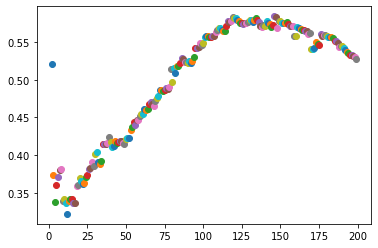

optimal number of clusters is : 146  with a silhouette avg of:  0.5843189023923878


In [99]:
from sklearn.metrics import silhouette_score

maxim=0
max_nclus=0

for n_clusters in range(2,200):
    clusterer = KMeans(n_clusters=n_clusters, random_state=30)
    cluster_labels = clusterer.fit_predict(fullClustering.drop(["Country","year"],axis=1))

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(fullClustering.drop(["Country","year"],axis=1), cluster_labels)
    #print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_avg)
    plt.scatter(n_clusters,silhouette_avg)
    if(maxim<silhouette_avg): 
        maxim=silhouette_avg
        max_nclus=n_clusters
plt.show()
print("optimal number of clusters is :",max_nclus," with a silhouette avg of: ",maxim)

Come si puo notare dallo scatterplot e dai risultati finali, il numero di cluster inizialmente sembra essere 2, ed è tale fino a quando non si arriva alla centinaia di cluster, questo perché si ci avvicina sostanzialmente al numero di regioni originarie del dataset che era intorno alle 130-140 (il valore non è definito precisamente perchè qualche anno sono andati persi dei valori ed i record che non possedevano certe feature sono stati eliminati), il risultato non sorprende data la natura ripetitiva dei dati di una stessa regione, nel senso che di anno in anno, i singoli valori nelle feature delle regioni cambiano di poco.

Si assegnano quindi le etichette di appartenenza ai record non secondo il numero ottimale di cluster (146), ma vengono semplicemente create 2 etichette per avere dei cluster abbastanza popolati (molti algoritmi di classificazione dipendono dalla popolazione rispetto alle etichette, come per esempio k-means o LDA).

In [100]:
clusterer = KMeans(n_clusters=2, random_state=30)
cluster_labels = clusterer.fit_predict(fullClustering.drop(["Country","year"],axis=1))

fullClustering["clusterLabels"] = cluster_labels
fullClustering.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 512 entries, 0 to 511
Data columns (total 15 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Country                                         512 non-null    object 
 1   Score                                           512 non-null    float64
 2   GDP                                             512 non-null    float64
 3   life_Expectancy                                 512 non-null    float64
 4   FreedomOflife                                   512 non-null    float64
 5   corruption                                      512 non-null    float64
 6   Generosity                                      512 non-null    float64
 7   DystopiaResidual                                512 non-null    float64
 8   year                                            512 non-null    int64  
 9   Social_support                             

# 6. Classificazione

Durante questo capitolo di classificazione verranno visti dei modelli per la stima dell'inequalità precedentemente introdotta e delle etichette di cluster precedentemente aggiunte al dataset.

Si procederà primariamente con la classificazione delle classi di inequalità, per poi svolgere quella delle etichette di cluster.
Durante la classificazione degli score di felicità si procederà con una descrizione breve dei modelli con commenti ed ipotesi sui possibili risultati migliori per il singolo dataset.

La classificazione delle etichette dei cluster invece verrà fatta in modo automatico con la costruzione dei modelli e la validazione, con solo le considerazioni finali sui modelli e sui risultati ottenuti.

## 6.1 Classificazione classi di inequalità

In questa sezione si procederà con la classificazione delle classi di inequalità del dataset completo.
Questo attributo e multinomiale quindi verranno utilizzati classificatori multinomiali.

Alla fine della creazione di tutti i modelli verranno confrontati tramite le misure di accuratezza del singolo classificatore, oltre a vedere il comportamento dei singoli su dati che non siano del training set tramite validazione del modello (tramite cross-validation con k-folding).

Il dataset utilizzato è lo stesso, ma sono state tolte delle feature che non erano complete oppure erano direttamente collegate con l'attributo da stimare (in particolare il Gini index).

Inoltre bisogna notare che per il dataset del gini index, l'unica data fornita è quella del 2017 (venivano fornite anche altre date ma erano tutte molto distanti), quindi si assume che sia restato più o meno lo stesso durante gli anni trattati in questo studio e quindi 

Il dataset è stato inoltre standardizzato/scalato, dato che molte tecniche di classificazione e di decomposizione sono molto sensibili alla scala delle singole feature, e potrebbero portare a risultati non consistenti.
Per la standardizzazione è stato utilizzato lo Standard Scaler di scikit learn, che molto semplicemente calcola lo z-score di ogni feature.

In [101]:
from sklearn.preprocessing import StandardScaler

fullClassification = pd.merge(dataset, suicidesBySex.drop(["Suicide rate (age-standardized)","Code"], axis=1), on=["year","Country"])
fullClassification = pd.merge(fullClassification,infantMortality, on=["year","Country"])
fullClassification = pd.merge(fullClassification,incomeInequality.drop(["Code","GINI index (World Bank estimate)","year"],axis=1), on=["Country"])
fullClassification = fullClassification.drop(["rank","Country","Family","Region","Standard_Error","Lower_Confidence_Interval","Upper_Confidence_Interval","Code"],axis=1).fillna(0)
inequalityColumn = fullClassification.inequality
scaler = StandardScaler()
fullClassification = pd.DataFrame(scaler.fit_transform(fullClassification.drop(["inequality"],axis=1)),columns = fullClassification.drop(["inequality"],axis=1).columns)
fullClassification.head()

Score       GDP  life_Expectancy  FreedomOflife  corruption  Generosity  \
0  1.957115  1.293946         1.509894       1.642688    3.033577    0.604791   
1  1.889026  1.628352         1.183620       1.126279    2.955206    0.479795   
2  1.875932  1.724593         1.163234       1.348984    2.499921    0.555962   
3  1.869821  1.353992         1.449841       1.606733    2.398724    0.285208   
4  1.934419  1.053174         1.536570       1.405140    0.219008    1.698173   

   DystopiaResidual      year  Social_support  \
0          0.848702 -1.343046        1.277396   
1          1.168049 -0.450008        1.243829   
2          0.415103  0.443031        1.025344   
3          0.691598  1.336069        1.133056   
4          1.181346 -1.343046        1.243829   

   Male suicide rate (age-standardized)  \
0                             -0.034553   
1                             -0.106766   
2                             -0.153492   
3                             -0.252254   
4                             -0.019686   

   Female suicide rate (age-standardized)  \
0                                0.328146   
1                                0.215557   
2                                0.120560   
3                                0.078340   
4                               -0.459977   

   Mortality rate, infant (per 1,000 live births)  
0                                       -0.904360  
1                                       -0.904360  
2                                       -0.904360  
3                                       -0.904360  
4                                       -0.996509

Si inizia la classificazione vedendo varie tecniche di classificazione (regressione logistica, Naive Bayes, LDA, SVM e alberi decisionali, K-nearest neighbors) con variazioni di esse (che coinvolgono più tecniche come il boosting o metodi di ensemble learnig).

Si vedono inizialmente tutte le accuratezze sui dati di test (senza considerare le accuratezze sul training set).
Infine si confronteranno i vari risultati per stabilire il classificatore migliore con la cross-validation.
Verrà inoltre visto il dataset ridotto di dimensioni e riclassificato per vedere se è possibile trarre vantaggi dalle tecniche di riduzione dimensionalità ed aumento di separabilità utilizzate.

Verranno infine visti dei metodi di diminuzione di dimensionalità ed infine verranno confrontati i modelli e validati.

## 6.1.1 Classificazione con regressione logistica multinomiale

La regressione logistica è una regressione di tipo non lineare utilizzata molto per la classificazione di variabili di tipo binario, ma può essere facilmente estesa a variabili qualitative non binarie.

Per il caso binario, la funzione logit è il logaritmo naturale dell'**odd**, ovvero del rapporto $\frac{p}{1-p}$.

La probabilità viene definita come la sigmoide della funzione lineare di parametri stimati, cioè $p = sigm (\beta_0 + \beta_1 x)= \frac{e^{\beta_0 + \beta_1 x}}{1+e^{\beta_0+\beta_1 x}}$ .

E' importante notare che la derivata prima della sigmoide è una funzione a forma di campana, infatti la regressione logistica è molto utile per la predizione di dati che seguono una distribuzione normale.

Di seguito viene visto il codice per la costruzione della regressione logistica multinomiale.

In [102]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(fullClassification, inequalityColumn,test_size=0.2, random_state=42)

modelLogit = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# fit the model on the whole dataset
modelLogit.fit(X_train,y_train )
predictedLogit = modelLogit.predict(X_test)
acc = accuracy_score(y_test, predictedLogit)
cm = confusion_matrix(y_test, predictedLogit)
print(cm)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(y_test,predictedLogit))

[[ 3  0  1  0  1]
 [ 0 23  3  0 13]
 [ 0  7 18  1  4]
 [ 0  0  2  1  2]
 [ 0  5  5  2 12]]
Accuracy: 0.55
              precision    recall  f1-score   support

        high       1.00      0.60      0.75         5
         low       0.66      0.59      0.62        39
      medium       0.62      0.60      0.61        30
 medium-high       0.25      0.20      0.22         5
  medium-low       0.38      0.50      0.43        24

    accuracy                           0.55       103
   macro avg       0.58      0.50      0.53       103
weighted avg       0.58      0.55      0.56       103



Si vedono la matrice di confusione e degli indici statistici che esprimono l'accuratezza del modello, in particolare verrà posta particolare attenzione ad accuratezza (definita come record correttamente classificati in rapporto a tutti i record), precision(record classificati ed appartenenti effettivamente ad una classe in rapporto a tutti i record classificati con quella classe), recall(record classificati ed appartenenti ad una classe in rapporto a tutti i record effettivi di quella classe) ed f1-score(la media armonica tra precision e recall).

L'algoritmo di sklearn utilizza già una strategia di regolarizzazione dei parametri (L2) per evitare overfitting, si può comunque stabilire sia la strategia di regolarizzazione che il coefficentie di penalizzazione (come nelle SVM).

L'algoritmo originario di regressione logistica originario è stato fatto per considerare solo due classi (risposta binaria di appartenenza alle due classi), quello utilizzato da sklearn per la regressione logistica multinomiale calcola le probabilità che un record appartenga ad una classe specifica e poi decide con quale classe identificare il record tramite l'algoritmo di SoftMax (utilizzato anche nelle reti neurali per la classificazione all'ultimo livello), un caso speciale della sigmoide utilizzata nella regressione logistica per il calcolo delle probabilità.

Infine si decide la classe grazie alle probabilità ottenute (molto semplicemente la classe derivante è quella più probabile).

Il modello precedentemente esposto basava la predizione della classe su tutte le feature possibili, il seguente modello invece sulle feature con la correlazione più alta con l'indice di gini.

In [103]:
X_train, X_test, y_train, y_test = train_test_split(fullClassification[["Mortality rate, infant (per 1,000 live births)","life_Expectancy","GDP","Social_support"]], inequalityColumn,test_size=0.2, random_state=42)

modelLogitReduced = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# fit the model on the whole dataset
modelLogitReduced.fit(X_train,y_train )
predictedLogit = modelLogitReduced.predict(X_test)
acc = accuracy_score(y_test, predictedLogit)
cm = confusion_matrix(y_test, predictedLogit)
print(cm)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(y_test,predictedLogit,zero_division=0))

[[ 0  0  5  0  0]
 [ 0 27  2  0 10]
 [ 4 11  4  0 11]
 [ 0  1  0  0  4]
 [ 0  7  3  0 14]]
Accuracy: 0.44
              precision    recall  f1-score   support

        high       0.00      0.00      0.00         5
         low       0.59      0.69      0.64        39
      medium       0.29      0.13      0.18        30
 medium-high       0.00      0.00      0.00         5
  medium-low       0.36      0.58      0.44        24

    accuracy                           0.44       103
   macro avg       0.25      0.28      0.25       103
weighted avg       0.39      0.44      0.40       103



L'approccio precedentemente utilizzato di ridurre la quantità di feature utilizzate per la predizione non sembra funzionare, quindi anche nelle prossime tecniche di classificazione, verranno utilizzate tutte le feature disponibili.

Il modello costruito (con tutte le feature) sembra approssimare bene le classi di inequalità alte, medie e basse, ma non funziona bene è costruisce molti falsi positivi e negativi con le classi medie tra la media e le classi agli estremi.


## 6.1.2 Classificazione con Naive Bayes 

Il classificatore Naive Bayes si basa sull'interpretazione Bayesiana di probabilità e della probabilità condizionata riassunta nella seguente formula:

\begin{equation}
P(Y\ |\ X) = \frac{P(X\ |\ Y)\ P(Y)}{P(X)}
\end{equation}

Dove $P(X\ |\ Y)$ viene detta likelihood e $P(Y)$ probabilità a priori.

Questi concetti tornano molto utili nella classificazione dato che è possibile costruire un modello supervisionato dai dati di training già etichettati che riesca ad estimare la classe di appartenenza a partire dalle variabili indipendenti (gli estimatori).

Per semplificare il calcolo, si suppone l'indipendenza dei predittori, in modo che il calcolo della likelihood si riduca ad una produttoria delle singole probabilità condizionate dalla variabile dipendente da stimare.

In caso di variabili continue, si stima la likelihood secondo delle distribuzioni precise, tra le quali la più famosa è la distribuzione Gaussiana con la seguente formula di PDF : 
\\[p(x=v|C_k)=\frac{e^{-\frac{(v-\mu_k)^2}{2\sigma_k^2}}}{\sqrt[2]{2\pi\sigma_k^2}}\\]
Altri approcci utilizzano la divisione in range di valori e binning, ma non verranno viste dato che gli estimatori di sklearn utilizzano tutti la strategia di stima della densità della likelihood.

La classificazione avviene infine prendendo la classe più probabile tramite la strategia di MAP.

Di seguito vengono presentati i codici per la costruzione di classificatori con Naive Bayes.

In [104]:
from sklearn.naive_bayes import GaussianNB,CategoricalNB

X_train, X_test, y_train, y_test = train_test_split(fullClassification, inequalityColumn,test_size=0.2, random_state=42)

#probabilità a priori uniformi
modelNBgaussian = GaussianNB(priors=[0.2,0.2,0.2,0.2,0.2])
#modelNBgaussian = GaussianNB()
modelNBgaussian.fit(X_train,y_train)

predictedNBGaussian = modelNBgaussian.predict(X_test)
acc = accuracy_score(y_test, predictedNBGaussian)
cm = confusion_matrix(y_test, predictedNBGaussian)
print(cm)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(y_test,predictedNBGaussian,zero_division=0))

[[ 5  0  0  0  0]
 [ 0 27  6  0  6]
 [ 5  8 13  2  2]
 [ 0  1  1  2  1]
 [ 3 10  7  2  2]]
Accuracy: 0.48
              precision    recall  f1-score   support

        high       0.38      1.00      0.56         5
         low       0.59      0.69      0.64        39
      medium       0.48      0.43      0.46        30
 medium-high       0.33      0.40      0.36         5
  medium-low       0.18      0.08      0.11        24

    accuracy                           0.48       103
   macro avg       0.39      0.52      0.42       103
weighted avg       0.44      0.48      0.44       103



La classificazione tramite Naive Bayes con ipotesi di likelihood a distribuzione gaussiana sembra funzionare peggio della regressione logistica anche se di poco, il modello presentato resta comunque molto incosistente dato che da dataset con più o meno la stessa struttura possono risultare modelli abbastanza differenti.

Si passa ora alla classificazione tramite LDA (linear discriminant analysis), molto simile alla scomposizione per PCA, ma che tiene conto delle classi di appartenenza dei record ed effettua una decomposizione spettrale mantenendo una buona separabilità interclasse (massimizzando la distanza tra le medie) e vicinanza intraclasse (minimizzando la somma delle varianze delle feature).

## 6.1.3 Classificazione con LDA (linear discriminant analysis)

Oltre ad essere un modo per ridurre le dimensioni di un dataset tenendo conto delle etichette di classificazione (scomposizione supervisionata).

Le ipotesi che si seguono durante l'utilizzo di LDA è che la covarianza tra le classi sia all'incirca la stessa (praticamente la correlazione tra le classi deve essere quasi nulla) e che le distribuzioni delle osservazioni all'interno di ogni classe seguano un andamento gaussiano.

Nonostante queste ipotesi, la scomposizione e il classificatore in generale funzionano abbastanza bene.

Esiste comunque la Quadratic Discriminant Analisys che toglie l'assunzione di covarianza all'incirca uguale dalle osservazioni intraclasse.

Se si vuole mantenere comunque una buona separabilità che rispetti le condizioni precedentementi esposte, solitamente si ricorre ad una pipeline di trasformazioni, trasformando i dati con PCA per avere variazione massima nelle componenti e una correlazione quasi nulla tra tutte le componenti(tranne in casi speciali dove tutte le componenti sono sostanzialmente sparse), con conseguente trasformazione con LDA o QDA.
La tecnica esposta precedentemente verrà utilizzata alla fine della visione di tutti i metodi di classificazione per ottenere un nuovo dataset con meno dimensioni e separabilità abbastanza alta.

L'algoritmo di LDA può essere utilizzato come classificatore, questo viene fatto dopo la scomposizione spettrale, dove il dataset originale viene trasformato in un nuovo spazio dove la separabilità interclasse è massima come esposto precedentemente, vengono scelti dei threshold di classificazione e lo spazio viene diviso in regioni, dove i punti vengono classificati come appartenenti ad una classe specifica.

Di seguito il codice del classificatore.

In [105]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

modelLDA = LDA(n_components=2)
modelLDA.fit(X_train,y_train)

predictedLDA = modelLDA.predict(X_test)
acc = accuracy_score(y_test, predictedLDA)
cm = confusion_matrix(y_test, predictedLDA)
print(cm)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(y_test,predictedLDA,zero_division=0))

[[ 4  0  1  0  0]
 [ 0 23  3  0 13]
 [ 4  6 14  1  5]
 [ 0  0  2  1  2]
 [ 0  5  6  2 11]]
Accuracy: 0.51
              precision    recall  f1-score   support

        high       0.50      0.80      0.62         5
         low       0.68      0.59      0.63        39
      medium       0.54      0.47      0.50        30
 medium-high       0.25      0.20      0.22         5
  medium-low       0.35      0.46      0.40        24

    accuracy                           0.51       103
   macro avg       0.46      0.50      0.47       103
weighted avg       0.53      0.51      0.52       103



Il parametro di n_components del modello non modifica il modello finale ma solo il comportamento di transform, è stato scelto due perché nel prossimo codice verranno visualizzati i dati, ma durante l'analisi dei dati scomposti si costruirà una scomposizione di N-1 variabili, dove N è il numero di classi.

Viene visualizzata la trasformazione in 2 dimensioni, che comunque non è esplicativa del modello in esame.

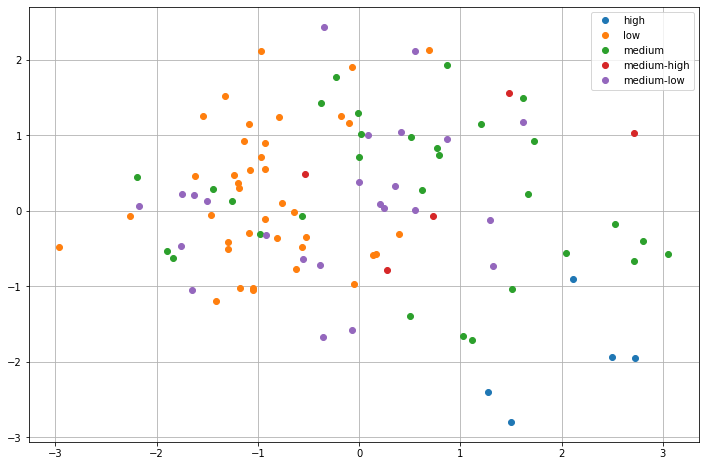

In [106]:
data_lda=modelLDA.transform(X_test)
plt.figure(figsize=(12,8))
classes = np.unique(inequalityColumn)
for s in classes:
    class_data = data_lda[y_test==s]
    plt.plot(class_data[:,0],class_data[:,1],'o')
plt.grid()
plt.legend(classes)
plt.show()

Le classi non sono linearmente separabili, o almeno non lo sono in 2 dimensioni, non è possibile vederlo dato che non esiste un modo di vedere uno spazio a 4 dimensioni (esistono metodi di visualizzazione ma non permetterebbero di vedere la separazione tra i dati).

La classificazione con LDA sembra comunque la migliore per il momento, dato il risultato si prova pure la QDA(quadratic discriminant analysis).

In [107]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

modelQDA = QDA()
modelQDA.fit(X_train,y_train)

predictedQDA = modelQDA.predict(X_test)
acc = accuracy_score(y_test, predictedQDA)
cm = confusion_matrix(y_test, predictedQDA)
print(cm)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(y_test,predictedLDA,zero_division=0))

[[ 1  0  4  0  0]
 [ 0 26  4  0  9]
 [ 0  5 21  0  4]
 [ 0  0  1  2  2]
 [ 0  9  7  0  8]]
Accuracy: 0.56
              precision    recall  f1-score   support

        high       0.50      0.80      0.62         5
         low       0.68      0.59      0.63        39
      medium       0.54      0.47      0.50        30
 medium-high       0.25      0.20      0.22         5
  medium-low       0.35      0.46      0.40        24

    accuracy                           0.51       103
   macro avg       0.46      0.50      0.47       103
weighted avg       0.53      0.51      0.52       103



Ancora una volta il risultato sembra migliorare, nei prossimi capitoli verranno utilizzati i dati trasformati in meno dimensioni.

Si passa ora alla classificazione tramite SVM.

## 6.1.4 Classificazione con SVM (support vector machine)

Questo modello di classificazione lavora bene con dati separabili linearmente nel caso di kernel lineari, dato che costruisce un piano separatore che massimizzi il margine tra le classi prese in esame, questo problema è un problema di programmazione non lineare facilmente risolvibile tramite moltiplicatori di Lagrange e condizioni KKT.

Si è visto precedentemente che le classi non sono separabili linearmente neanche dopo la trasformazione con LDA (dai risultati ottenuti l'accuratezza ottenuta lo fa presumere), questo modello quindi probabilmente non porterà miglioramenti, specialmente senza l'utilizzo di kernel. Quello che viene fatto da un kernel è una trasformazione dei dati in più dimensioni, dove le dimensioni aggiuntive derivano dal kernel scelto  (quello che viene fatto in realtà è una trasformazione diretta sulla funzione di decisione e sul calcolo delle relazioni tra i singoli datapoints per ottimizzare il calcolo e non calcolare la trasformazione).

Un altra nota importante da tenere conto è che le SVM nella loro formulazione principale sono estremamente sensibili agli outlier , per evitare di overfittare e di tenere conto di singoli outlier che rovinerebbero il modello, vengono utilizzati dei regolarizzatori (coefficenti di penalità) utilizzati per implementare nelle SVM il cosidetto soft-margin, che permette a dei record di essere classificato in modo errato per diminuire il bias e rendere il modello costruito più flessibile. La ricerca dei parametri di penalizzazione viene attuata tramite cross-validation e ricerca di parametri ottimali (tramite grid-search).

Di seguito si vedranno vari risultati con vari kernel e parametri per infine sfociare nella ricerca dei parametri ottimali tramite GridSearch.

In [108]:
from sklearn.svm import SVC

#Parametro di regolarizzazione/penalizzazione relativamente basso dato che non c'è molto pericolo di overfitting dato l'inseparabilità dei dati
#in questo modo si ottiene un soft margin
modelsvm = SVC(kernel='linear',C=10)
modelsvm.fit(X_train,y_train)

predictedSVM = modelsvm.predict(X_test)
acc = accuracy_score(y_test, predictedSVM)
cm = confusion_matrix(y_test, predictedSVM)
print(cm)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(y_test,predictedSVM,zero_division=0))

[[ 2  0  2  0  1]
 [ 0 25  6  0  8]
 [ 1  6 19  0  4]
 [ 0  0  2  1  2]
 [ 0  7  4  1 12]]
Accuracy: 0.57
              precision    recall  f1-score   support

        high       0.67      0.40      0.50         5
         low       0.66      0.64      0.65        39
      medium       0.58      0.63      0.60        30
 medium-high       0.50      0.20      0.29         5
  medium-low       0.44      0.50      0.47        24

    accuracy                           0.57       103
   macro avg       0.57      0.47      0.50       103
weighted avg       0.58      0.57      0.57       103



Sorprendentemente, il modello costruito è il migliore finora, si procede quindi con l'utilizzo dei kernel e della ricerca dei parametri ottimali.



### 6.1.4.1 SVM con kernel non lineare

Per utilizzare un kernel non lineare, si possono trasformare i dati in modo da aumentare la separabilità, oppure utilizzare il kernel trick cambiando la funzione di decisione (approccio utilizzato nella libreria di scikit learn).

Si userà il secondo metodo perché è ovviamente il più efficente, ed è quello che viene utilizzato ufficialmente in molte librerie di ML.

Si inizia vedendo il kernel radiale

In [109]:
modelsvmrad = SVC(kernel='rbf')
modelsvmrad.fit(X_train,y_train)

predictedSVMrad = modelsvmrad.predict(X_test)
acc = accuracy_score(y_test, predictedSVMrad)
cm = confusion_matrix(y_test, predictedSVMrad)
print(cm)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(y_test,predictedSVMrad,zero_division=0))

[[ 0  0  5  0  0]
 [ 0 30  3  0  6]
 [ 0  6 19  0  5]
 [ 0  0  3  0  2]
 [ 0  7  7  0 10]]
Accuracy: 0.57
              precision    recall  f1-score   support

        high       0.00      0.00      0.00         5
         low       0.70      0.77      0.73        39
      medium       0.51      0.63      0.57        30
 medium-high       0.00      0.00      0.00         5
  medium-low       0.43      0.42      0.43        24

    accuracy                           0.57       103
   macro avg       0.33      0.36      0.34       103
weighted avg       0.52      0.57      0.54       103



In [110]:
modelsvmpoly = SVC(kernel='poly')
modelsvmpoly.fit(X_train,y_train)

predictedSVMpoly = modelsvmpoly.predict(X_test)
acc = accuracy_score(y_test, predictedSVMpoly)
cm = confusion_matrix(y_test, predictedSVMpoly)
print(cm)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(y_test,predictedSVMpoly,zero_division=0))

[[ 1  0  2  0  2]
 [ 0 27  3  0  9]
 [ 0  3 20  0  7]
 [ 0  0  3  0  2]
 [ 0  6  5  0 13]]
Accuracy: 0.59
              precision    recall  f1-score   support

        high       1.00      0.20      0.33         5
         low       0.75      0.69      0.72        39
      medium       0.61      0.67      0.63        30
 medium-high       0.00      0.00      0.00         5
  medium-low       0.39      0.54      0.46        24

    accuracy                           0.59       103
   macro avg       0.55      0.42      0.43       103
weighted avg       0.60      0.59      0.58       103



Per vedere quale sia la migliore combinazione di parametri si può ricorrere alla funzione di scikit learn **GridSearchCV**

In [111]:
from sklearn.model_selection import GridSearchCV
param_grid = [
  {'C': [1, 10, 100], 'kernel': ['linear']}, #parametri da utilizzare con kernel lineare
  {'C': [1, 10, 90, 100], 'gamma': [0.01, 0.05, 0.001], 'kernel': ['rbf']}, #parametri da utilizzare con kernel radiale
  {'C': [1, 10, 100],'degree':[2,3,4,5] ,'gamma': [0.01, 0.05, 0.001], 'kernel': ['poly']} #parametri da utilizzare con kernel polinomiale
 ]
#definiamo l'oggetto Grid Search
#Passando l'argomento verbose, possiamo ottenere informazioni aggiuntive
#n_jobs permette di effettuare più test in parallelo

modelSVMgrid = GridSearchCV(SVC(), param_grid, verbose=1,n_jobs=4, cv=kf)

modelSVMgrid.fit(X_train,y_train)

Fitting 10 folds for each of 51 candidates, totalling 510 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  57 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 510 out of 510 | elapsed:    3.7s finished


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=SVC(), n_jobs=4,
             param_grid=[{'C': [1, 10, 100], 'kernel': ['linear']},
                         {'C': [1, 10, 90, 100], 'gamma': [0.01, 0.05, 0.001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100], 'degree': [2, 3, 4, 5],
                          'gamma': [0.01, 0.05, 0.001], 'kernel': ['poly']}],
             verbose=1)

In [112]:
modelSVMgrid.score(X_test,y_test)

0.7766990291262136

In [113]:
bestSVM = modelSVMgrid.best_estimator_
print(bestSVM)

bestSVM.fit(X_train,y_train)

bestpredicted = bestSVM.predict(X_test)
acc = accuracy_score(y_test, bestpredicted)
cm = confusion_matrix(y_test, bestpredicted)
print(cm)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(y_test,bestpredicted,zero_division=0))

SVC(C=100, gamma=0.05)
[[ 5  0  0  0  0]
 [ 0 33  1  1  4]
 [ 1  4 21  1  3]
 [ 0  1  0  3  1]
 [ 0  4  2  0 18]]
Accuracy: 0.78
              precision    recall  f1-score   support

        high       0.83      1.00      0.91         5
         low       0.79      0.85      0.81        39
      medium       0.88      0.70      0.78        30
 medium-high       0.60      0.60      0.60         5
  medium-low       0.69      0.75      0.72        24

    accuracy                           0.78       103
   macro avg       0.76      0.78      0.76       103
weighted avg       0.78      0.78      0.78       103



Il modello di classificazione SVM con kernel radiale e un quasi hard margin (valore alto del parametro **C** di penalizzazione) sembra il migliore, si passa quindi alla classificazione tramite alberi decisionali.

## 6.1.5 Classificazione con decision trees

Un modello di classificazione con alberi decisionali consiste nella costruzione di un albero, dove ogni nodo interno dell’albero contiene un test su un attributo che stabilisce quale sottoalbero deve essere visitato. Un test tipicamente valuta una feature (booleana, numerica, ecc.) o combinazioni di feature. Un percorso di classificazione è una concatenazione di regole IF-THEN sugli attributi. Ogni foglia rappresenta la classificazione ad una etichetta di classe.

La costruzione di un albero può avvenire con due strategie, una top-down ed una bottom-up, controllando le etichette di classe del training set e creando o foglie o nodi decisionali su un attributo scelto secondo delle scelte di purezza di un nodo(quante t-uple contiene con la stessa etichetta da classificare).

La creazione dei nodi e delle regole decisionali avviene in base al tipo di attributo selezionato per lo splitting e alle caratteristiche della feature coinvolta (per dati continui si sceglie una soglia secondo certe regole, per dati categoriali si dividono per classi di appartenenza).

La costruzione dell'albero decisionale dipende pesantemente sull'ordine delle feature scelte durante la classificazione e sul criterio utilizzato per sceglierle (solitamente viene scelto un criterio di purezza secondo delle misure di goodness come information gain, gain ratio o gini impurity).

L'albero ottenuto influisce pesantemente sulle prestazioni, quindi molti algoritmi utilizzano strategie complesse per la costruzione di un albero, come ad esempio strategie di boosting, cross-validation, ricerca di parametri ottimali, ibride e pruning.

Quello che viene utilizzato nella libreria di scikit learn ed in python in generale implementano quasi tutte le strategie sopra esposte, anche se non è possibile effettuare delle strategie di pruning in modo semplice. Un modo simulare queste strategie di pruning ed evitare overfitting e calo di prestazioni è ricorrere alle random forest, che verranno utilizzate nell'ultima parte di questa classificazione con alberi decisionali.

Uno dei vantaggi degli alberi decisionali è la loro interpretabilità. Un albero decisionale costruisce una serie di regole che vengono applicate in maniera gerarchica per ottenere un risultato finale.

In [114]:
from sklearn import tree 
#limitiamo la profondità massima dell'albero per poterlo visualizzare in seguito
modelTree = tree.DecisionTreeClassifier(max_depth=12)
modelTree.fit(X_train,y_train)

predictedTree = modelTree.predict(X_test)
acc = accuracy_score(y_test, predictedTree)
cm = confusion_matrix(y_test, predictedTree)
print(cm)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(y_test,predictedTree,zero_division=0))

[[ 4  0  1  0  0]
 [ 0 34  3  0  2]
 [ 2  2 22  0  4]
 [ 0  0  0  4  1]
 [ 0  4  5  0 15]]
Accuracy: 0.77
              precision    recall  f1-score   support

        high       0.67      0.80      0.73         5
         low       0.85      0.87      0.86        39
      medium       0.71      0.73      0.72        30
 medium-high       1.00      0.80      0.89         5
  medium-low       0.68      0.62      0.65        24

    accuracy                           0.77       103
   macro avg       0.78      0.77      0.77       103
weighted avg       0.77      0.77      0.77       103



L'albero creato ha una buona accuratezza, ma data la profondità così alta, potrebbe overfittare il dataset in esame.

Si visualizza la struttura dell'albero decisionale trova.

In [115]:
texttree=tree.export_text(modelTree,feature_names=list(fullClassification.columns))
print(texttree)

|--- Mortality rate, infant (per 1,000 live births) <= -0.82
|   |--- Male suicide rate (age-standardized) <= -0.46
|   |   |--- Score <= 1.62
|   |   |   |--- class: medium-low
|   |   |--- Score >  1.62
|   |   |   |--- class: medium
|   |--- Male suicide rate (age-standardized) >  -0.46
|   |   |--- Generosity <= -0.95
|   |   |   |--- life_Expectancy <= 1.32
|   |   |   |   |--- GDP <= 0.57
|   |   |   |   |   |--- class: low
|   |   |   |   |--- GDP >  0.57
|   |   |   |   |   |--- class: medium-low
|   |   |   |--- life_Expectancy >  1.32
|   |   |   |   |--- class: low
|   |   |--- Generosity >  -0.95
|   |   |   |--- Mortality rate, infant (per 1,000 live births) <= -0.88
|   |   |   |   |--- DystopiaResidual <= -1.36
|   |   |   |   |   |--- class: medium-low
|   |   |   |   |--- DystopiaResidual >  -1.36
|   |   |   |   |   |--- Generosity <= 2.02
|   |   |   |   |   |   |--- FreedomOflife <= 1.51
|   |   |   |   |   |   |   |--- class: low
|   |   |   |   |   |   |--- Freedo

L'albero creato viene percorso da radice a foglia durante la predizione, controllando le condizioni e classficando infine il record.

### 6.1.5.1 Random Forest

Il Random Forest è un esempio di modello (classificatore o predittore) ensemble che combina i risultati di diversi alberi decisionali mediante la tecnica bootstrap. In più il Random Forest addestra ciascun albero  decisionale su un sottinsieme random di **m** attributi (bagging sugli attributi).

Alla fine del processo di costruzione dei vari classificatori(creati tramite training con dati e feature prese tramite bagging), si utilizza un modello ensemble per avere il risultato finale.

In [116]:
from sklearn.ensemble import RandomForestClassifier
#si sceglie un seme per avere gli stessi risultati, dato che random forest utilizza metodi randomici per costruire il modello
np.random.seed(777)
#limitiamo la profondità massima dell'albero per poterlo visualizzare in seguito
modelRF = RandomForestClassifier(max_depth=10, n_estimators=1000)
modelRF.fit(X_train,y_train)

predictedRTree = modelRF.predict(X_test)
acc = accuracy_score(y_test, predictedRTree)
cm = confusion_matrix(y_test, predictedRTree)
print(cm)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(y_test,predictedRTree,zero_division=0))

[[ 4  0  1  0  0]
 [ 0 36  0  1  2]
 [ 0  2 27  0  1]
 [ 0  0  0  4  1]
 [ 0  2  4  0 18]]
Accuracy: 0.86
              precision    recall  f1-score   support

        high       1.00      0.80      0.89         5
         low       0.90      0.92      0.91        39
      medium       0.84      0.90      0.87        30
 medium-high       0.80      0.80      0.80         5
  medium-low       0.82      0.75      0.78        24

    accuracy                           0.86       103
   macro avg       0.87      0.83      0.85       103
weighted avg       0.86      0.86      0.86       103



In [117]:
texttree=tree.export_text(modelRF.estimators_[0],feature_names=list(fullClassification.columns))
print(texttree)

|--- GDP <= 0.89
|   |--- Score <= 0.55
|   |   |--- Score <= -1.03
|   |   |   |--- Male suicide rate (age-standardized) <= -0.08
|   |   |   |   |--- year <= 0.89
|   |   |   |   |   |--- GDP <= -0.09
|   |   |   |   |   |   |--- Male suicide rate (age-standardized) <= -0.46
|   |   |   |   |   |   |   |--- life_Expectancy <= -1.44
|   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |--- life_Expectancy >  -1.44
|   |   |   |   |   |   |   |   |--- class: 4.0
|   |   |   |   |   |   |--- Male suicide rate (age-standardized) >  -0.46
|   |   |   |   |   |   |   |--- FreedomOflife <= -1.06
|   |   |   |   |   |   |   |   |--- class: 2.0
|   |   |   |   |   |   |   |--- FreedomOflife >  -1.06
|   |   |   |   |   |   |   |   |--- class: 4.0
|   |   |   |   |   |--- GDP >  -0.09
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- year >  0.89
|   |   |   |   |   |--- class: 4.0
|   |   |   |--- Male suicide rate (age-standardized) >  -0.08
|   |   |   |   

Per stimare i parametri ottimali da passare per la costruzione del modello, si utilizza GridSearch come precedentemente fatto per le SVM.

In [118]:
#definiamo la griglia di parametri
param_grid = {'max_depth': [5, 10, 15, None], 'n_estimators': [50, 100, 150, 200]}
#definiamo l'oggetto Grid Search
bestRF = GridSearchCV(RandomForestClassifier(), param_grid, verbose=1, n_jobs=4, cv=kf)
#avviamo la ricerca dei parametri ottimali sui nostri dati
bestRF.fit(X_train,y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed:    7.6s finished


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'max_depth': [5, 10, 15, None],
                         'n_estimators': [50, 100, 150, 200]},
             verbose=1)

In [119]:
bestRF = bestRF.best_estimator_
predictedbestRTree = bestRF.predict(X_test)
acc = accuracy_score(y_test, predictedbestRTree)
cm = confusion_matrix(y_test, predictedbestRTree)
print(cm)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(y_test,predictedbestRTree,zero_division=0))

[[ 5  0  0  0  0]
 [ 0 36  1  1  1]
 [ 0  2 27  0  1]
 [ 0  0  0  4  1]
 [ 0  2  3  0 19]]
Accuracy: 0.88
              precision    recall  f1-score   support

        high       1.00      1.00      1.00         5
         low       0.90      0.92      0.91        39
      medium       0.87      0.90      0.89        30
 medium-high       0.80      0.80      0.80         5
  medium-low       0.86      0.79      0.83        24

    accuracy                           0.88       103
   macro avg       0.89      0.88      0.88       103
weighted avg       0.88      0.88      0.88       103



Il modello creato ha una accuratezza abbastanza alta e batte tutti i classificatori precedentemente visti.

## 6.1.6 K-Nearest neighbors

Il classificatore K-nearest neighbors è un tipo di classificatore che utilizza la vicinanza spaziale (o la similarità per spazi non euclidei) che utilizza delle tecniche di apprendimento lazy (apprendimento e costruzione del modello veloce, ma predizine più dispendiosa) per la costruzione del modello e le predizioni di etichetta.

Il modello di classificatore K-nn funziona nel seguente modo:

Fissato k, si prendono le k tuple più vicine alla tupla X da classificare.
Si assegnano a X la classe più ricorrente (etichetta di maggioranza) tra le classi delle k tuple scelte.

La vicinanza di un record rispetto ad altri viene implementata o tramite distanza (euclidea o altro), oppure come similarità tra oggetti.

Un possibile modello 3-nn si può costruire nel seguente modo.

In [120]:
from sklearn.neighbors import KNeighborsClassifier

model3NN = KNeighborsClassifier(n_neighbors=3)
model3NN.fit(X_train,y_train)

predicted3NN = model3NN.predict(X_test)
acc = accuracy_score(y_test, predicted3NN)
cm = confusion_matrix(y_test, predicted3NN)
print(cm)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(y_test,predicted3NN,zero_division=0))

[[ 3  0  2  0  0]
 [ 0 33  2  0  4]
 [ 1  6 17  3  3]
 [ 1  0  1  3  0]
 [ 0  6  3  0 15]]
Accuracy: 0.69
              precision    recall  f1-score   support

        high       0.60      0.60      0.60         5
         low       0.73      0.85      0.79        39
      medium       0.68      0.57      0.62        30
 medium-high       0.50      0.60      0.55         5
  medium-low       0.68      0.62      0.65        24

    accuracy                           0.69       103
   macro avg       0.64      0.65      0.64       103
weighted avg       0.69      0.69      0.69       103



Il modello così semplicemente esposto sembra funzionare molto bene, dato questo risultato sorprendente si continua con la ricerca dei parametri ottimali tramite GridSearch.

In [121]:
param_grid = [ {'n_neighbors':range(1,40)}]

modelKNNbest = GridSearchCV(KNeighborsClassifier(), param_grid)
modelKNNbest.fit(X_train,y_train)
bestKNN = modelKNNbest.best_estimator_
print("Migliore valore di K trovato utilizzando solo il training set: %d" % bestKNN.n_neighbors)

Migliore valore di K trovato utilizzando solo il training set: 1


Il valore di vicini considerati ottimo è 1, quindi verrà considerata la classe del record più vicino(spazialmente) nel dataset di training.

In [122]:
predictedBestKNN = bestKNN.predict(X_test)
acc = accuracy_score(y_test, predictedBestKNN)
cm = confusion_matrix(y_test, predictedBestKNN)
print(cm)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(y_test,predictedBestKNN,zero_division=0))

[[ 5  0  0  0  0]
 [ 0 33  2  0  4]
 [ 1  2 24  2  1]
 [ 0  0  1  4  0]
 [ 0  3  2  1 18]]
Accuracy: 0.82
              precision    recall  f1-score   support

        high       0.83      1.00      0.91         5
         low       0.87      0.85      0.86        39
      medium       0.83      0.80      0.81        30
 medium-high       0.57      0.80      0.67         5
  medium-low       0.78      0.75      0.77        24

    accuracy                           0.82       103
   macro avg       0.78      0.84      0.80       103
weighted avg       0.82      0.82      0.82       103



Il modello così ottenuto sembra essere il migliore per il momento.

## 6.1.7 Confronto dei modelli costruiti

Vengono confrontati i migliori classificatori di ogni tipo.

In [123]:
scores = cross_val_score(modelLogit, fullClassification, inequalityColumn, cv=kf)
print ("Cross-validated scores for Logit:", scores)
print('accuracy for Logit: ',(np.mean(scores)),"(", (np.std(scores)),")","\n")
scores = cross_val_score(modelNBgaussian, fullClassification, inequalityColumn, cv=kf)
print ("Cross-validated scores for Naive Bayes Gaussian:", scores)
print('accuracy for Naive Bayes Gaussian: ',(np.mean(scores)),"(", (np.std(scores)),")","\n")
scores = cross_val_score(modelQDA, fullClassification, inequalityColumn, cv=kf)
print ("Cross-validated scores for QDA:", scores)
print('accuracy for QDA: ',(np.mean(scores)),"(", (np.std(scores)),")","\n")
scores = cross_val_score(modelLDA, fullClassification, inequalityColumn, cv=kf)
print ("Cross-validated scores for LDA:", scores)
print('accuracy for LDA: ',(np.mean(scores)),"(", (np.std(scores)),")","\n")
scores = cross_val_score(bestSVM, fullClassification, inequalityColumn, cv=kf)
print ("Cross-validated scores for SVM:", scores)
print('accuracy for SVM: ',(np.mean(scores)),"(", (np.std(scores)),")","\n")
scores = cross_val_score(modelTree, fullClassification, inequalityColumn, cv=kf)
print ("Cross-validated scores for decision tree:", scores)
print('accuracy for decision tree: ',(np.mean(scores)),"(", (np.std(scores)),")","\n")
scores = cross_val_score(bestRF, fullClassification, inequalityColumn, cv=kf)
print ("Cross-validated scores for RandomForest:", scores)
print('accuracy for RandomForest: ',(np.mean(scores)),"(", (np.std(scores)),")","\n")
scores = cross_val_score(bestKNN, fullClassification, inequalityColumn, cv=kf)
print ("Cross-validated scores for K-nearest neighbor:", scores)
print('accuracy for k-nearest neighbor: ',(np.mean(scores)),"(", (np.std(scores)),")")

Cross-validated scores for Logit: [0.48076923 0.42307692 0.39215686 0.52941176 0.52941176 0.39215686
 0.49019608 0.64705882 0.60784314 0.54901961]
accuracy for Logit:  0.5041101055806938 ( 0.08177036109980003 ) 

Cross-validated scores for Naive Bayes Gaussian: [0.34615385 0.44230769 0.37254902 0.35294118 0.47058824 0.45098039
 0.33333333 0.43137255 0.37254902 0.45098039]
accuracy for Naive Bayes Gaussian:  0.40237556561085974 ( 0.048952980012425595 ) 

Cross-validated scores for QDA: [0.55769231 0.65384615 0.52941176 0.60784314 0.56862745 0.49019608
 0.70588235 0.68627451 0.56862745 0.60784314]
accuracy for QDA:  0.5976244343891401 ( 0.06512939668132874 ) 

Cross-validated scores for LDA: [0.61538462 0.48076923 0.37254902 0.45098039 0.49019608 0.52941176
 0.37254902 0.52941176 0.47058824 0.50980392]
accuracy for LDA:  0.4821644042232277 ( 0.06941193226677066 ) 

Cross-validated scores for SVM: [0.84615385 0.80769231 0.90196078 0.84313725 0.76470588 0.80392157
 0.70588235 0.80392157 0.

Dagli score ottenuti precedentemente (con gli errori risultanti dei modelli), risulta che l'algoritmo di Random Forest risulta il migliore classificatore tra tutti quelli presentati, data l'alta accuratezza ottenuta e l'errore molto piccolo rispetto agli altri modelli.

Si prova ora la tecnica di riduzione di dimensionalità dei dati e si ripetono gli esperimenti precedentemente fatti.

## 6.1.8 Riduzione dimensionalità

In molti metodi di riduzione della dimensionalità, quello che viene fatto è sostanzialmente una trasformazione (automorfismo o isomorfismo), che cambia l'insieme delle feature in un altro insieme con certe proprietà (solitamente sempre spazi vettoriali ma non è detto).

Non è stato fatto precedentemente perché dai risultati che si otterranno i modelli risulteranno quasi inutili dopo la trasformazione dei dati, quindi si mette alla fine delle considerazioni sulla classificazione per fare notare che la riduzione di dimensionalità è inutile in questo caso.

Con la Principal component analisys lo spazio delle feature viene trasformato in un altro spazio dove i vettori di base (le nuove feature) sono ordinati per varianza non crescente e le feature sono decorrelate tra di loro (la matrice di covarianza risultante è diagonale).
Sostanzialmente si può dimostrare che le componenti principali sono gli autovettori della matrice di covarianza, quindi questi vettori vengono solitamente calcolati per decomposizione spettrale (eigendecomposition) oppure con Singular Value Decomposition direttamente sui dati.
Alla fine della procedura si avranno le componenti principali dei dati (delle basi ortonormali) e la matrice di trasformazione per il cambio di base.

La PCA è implementata nella libreria di scikit learn tramite Singular Value Decomposition.

In [124]:
from sklearn.decomposition import PCA
pca = PCA(n_components=8)
pca.fit(fullClassification)
transformedFullClassification = pca.transform(fullClassification)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum()[-1])

[0.3786829  0.13519237 0.13124282 0.10628126 0.06788844 0.05615149
 0.03950177 0.03359605]
0.9485370774616831


Il 91% della varianza viene mantenuta alla fine della trasformazione con 8 componenti principali, è comunque un risultato abbastanza poco buono sia per il fatto che i dati erano poco correlati (i dataset diversi erano poco correlati, molte feature in se erano correlate), sia perché il numero di feature non era troppo grande. Risultati maggiori è più notevoli si sarebbero ottenuti con una maggiore quantità di feature.

Si procede ora a vedere come se la cavano i classificatori di fronte al dataset trasformato.

In [125]:
scores = cross_val_score(modelLogit, transformedFullClassification, inequalityColumn, cv=kf)
print ("Cross-validated scores for transformed data (PCA) Logit:", scores)
print('accuracy for Logit: ',(np.mean(scores)),"(", (np.std(scores)),")","\n")
scores = cross_val_score(modelNBgaussian, transformedFullClassification, inequalityColumn, cv=kf)
print ("Cross-validated scores for transformed data (PCA) Naive Bayes Gaussian:", scores)
print('accuracy for Naive Bayes Gaussian: ',(np.mean(scores)),"(", (np.std(scores)),")","\n")
scores = cross_val_score(modelQDA, transformedFullClassification, inequalityColumn, cv=kf)
print ("Cross-validated scores for transformed data (PCA) QDA:", scores)
print('accuracy for QDA: ',(np.mean(scores)),"(", (np.std(scores)),")","\n")
scores = cross_val_score(modelLDA, transformedFullClassification, inequalityColumn, cv=kf)
print ("Cross-validated scores for transformed data (PCA) LDA:", scores)
print('accuracy for LDA: ',(np.mean(scores)),"(", (np.std(scores)),")","\n")
scores = cross_val_score(bestSVM, transformedFullClassification, inequalityColumn, cv=kf)
print ("Cross-validated scores for transformed data (PCA) SVM:", scores)
print('accuracy for SVM: ',(np.mean(scores)),"(", (np.std(scores)),")","\n")
scores = cross_val_score(modelTree, transformedFullClassification, inequalityColumn, cv=kf)
print ("Cross-validated scores for transformed data (PCA) decision tree:", scores)
print('accuracy for decision tree: ',(np.mean(scores)),"(", (np.std(scores)),")","\n")
scores = cross_val_score(bestRF, transformedFullClassification, inequalityColumn, cv=kf)
print ("Cross-validated scores for transformed data (PCA) RandomForest:", scores)
print('accuracy for RandomForest: ',(np.mean(scores)),"(", (np.std(scores)),")","\n")
scores = cross_val_score(bestKNN, transformedFullClassification, inequalityColumn, cv=kf)
print ("Cross-validated scores for transformed data (PCA) K-nearest neighbor:", scores)
print('accuracy for k-nearest neighbor: ',(np.mean(scores)),"(", (np.std(scores)),")")

Cross-validated scores for transformed data (PCA) Logit: [0.61538462 0.46153846 0.47058824 0.50980392 0.39215686 0.47058824
 0.41176471 0.62745098 0.43137255 0.43137255]
accuracy for Logit:  0.4822021116138764 ( 0.07650508978012414 ) 

Cross-validated scores for transformed data (PCA) Naive Bayes Gaussian: [0.53846154 0.44230769 0.41176471 0.50980392 0.35294118 0.43137255
 0.41176471 0.35294118 0.43137255 0.60784314]
accuracy for Naive Bayes Gaussian:  0.44905731523378584 ( 0.07669769461645765 ) 

Cross-validated scores for transformed data (PCA) QDA: [0.57692308 0.53846154 0.58823529 0.62745098 0.50980392 0.50980392
 0.60784314 0.58823529 0.56862745 0.64705882]
accuracy for QDA:  0.5762443438914027 ( 0.04386061698604179 ) 

Cross-validated scores for transformed data (PCA) LDA: [0.5        0.53846154 0.50980392 0.47058824 0.56862745 0.47058824
 0.33333333 0.39215686 0.43137255 0.54901961]
accuracy for LDA:  0.47639517345399696 ( 0.06997422975817333 ) 

Cross-validated scores for trans

Sostanzialmente, i peggiori classificatori sono migliorati di poco, mentre la maggior parte dei migliori sono peggiorati di molto. Il dataset trovato quindi sembra inutilizzabile.

Si passa ora alla scomposizione tramite LDA vista precedentemente, quindi si costruisce il dataset trasformato per vedere come lavora con i classificatori.

In [126]:
LDAmodelTrans = LDA()
LDAmodelTrans.fit(fullClassification,inequalityColumn)
transformedLDAfullClassification = LDAmodelTrans.transform(fullClassification)

scores = cross_val_score(modelLogit, transformedLDAfullClassification, inequalityColumn, cv=kf)
print ("Cross-validated scores for transformed data (LDA) Logit:", scores)
print('accuracy for Logit: ',(np.mean(scores)),"(", (np.std(scores)),")","\n")
scores = cross_val_score(modelNBgaussian, transformedLDAfullClassification, inequalityColumn, cv=kf)
print ("Cross-validated scores for transformed data (LDA) Naive Bayes Gaussian:", scores)
print('accuracy for Naive Bayes Gaussian: ',(np.mean(scores)),"(", (np.std(scores)),")","\n")
scores = cross_val_score(modelQDA, transformedLDAfullClassification, inequalityColumn, cv=kf)
print ("Cross-validated scores for transformed data (LDA) QDA:", scores)
print('accuracy for QDA: ',(np.mean(scores)),"(", (np.std(scores)),")","\n")
scores = cross_val_score(modelLDA, transformedLDAfullClassification, inequalityColumn, cv=kf)
print ("Cross-validated scores for transformed data (LDA) LDA:", scores)
print('accuracy for LDA: ',(np.mean(scores)),"(", (np.std(scores)),")","\n")
scores = cross_val_score(bestSVM, transformedLDAfullClassification, inequalityColumn, cv=kf)
print ("Cross-validated scores for transformed data (LDA) SVM:", scores)
print('accuracy for SVM: ',(np.mean(scores)),"(", (np.std(scores)),")","\n")
scores = cross_val_score(modelTree, transformedLDAfullClassification, inequalityColumn, cv=kf)
print ("Cross-validated scores for transformed data (LDA) decision tree:", scores)
print('accuracy for decision tree: ',(np.mean(scores)),"(", (np.std(scores)),")","\n")
scores = cross_val_score(bestRF, transformedLDAfullClassification, inequalityColumn, cv=kf)
print ("Cross-validated scores for transformed data (LDA) RandomForest:", scores)
print('accuracy for RandomForest: ',(np.mean(scores)),"(", (np.std(scores)),")","\n")
scores = cross_val_score(bestKNN, transformedLDAfullClassification, inequalityColumn, cv=kf)
print ("Cross-validated scores for transformed data (LDA) K-nearest neighbor:", scores)
print('accuracy for k-nearest neighbor: ',(np.mean(scores)),"(", (np.std(scores)),")")

Cross-validated scores for transformed data (LDA) Logit: [0.48076923 0.5        0.54901961 0.39215686 0.50980392 0.56862745
 0.58823529 0.52941176 0.52941176 0.41176471]
accuracy for Logit:  0.5059200603318251 ( 0.060132601404255644 ) 

Cross-validated scores for transformed data (LDA) Naive Bayes Gaussian: [0.48076923 0.44230769 0.45098039 0.41176471 0.45098039 0.37254902
 0.56862745 0.41176471 0.45098039 0.43137255]
accuracy for Naive Bayes Gaussian:  0.44720965309200605 ( 0.04926755946847985 ) 

Cross-validated scores for transformed data (LDA) QDA: [0.42307692 0.46153846 0.45098039 0.56862745 0.52941176 0.56862745
 0.50980392 0.52941176 0.52941176 0.47058824]
accuracy for QDA:  0.5041478129713424 ( 0.0475427246584558 ) 

Cross-validated scores for transformed data (LDA) LDA: [0.5        0.59615385 0.50980392 0.62745098 0.52941176 0.49019608
 0.45098039 0.50980392 0.49019608 0.47058824]
accuracy for LDA:  0.5174585218702866 ( 0.05192187202515454 ) 

Cross-validated scores for transf

I risultati parlano da soli, la scomposizione con LDA ha reso la maggior parte dei classificatori peggiori rispetto alla controparte sul dataset originale.

## 6.1.9 Conclusioni classificazione per gli score di felicità

Nonostante l'inequalità inizialmente derivata dall'indice di gini non avesse particolari associazioni con altre variabili, i modelli creati dal dataset originario sembrano classificare abbastanza bene (intorno all'80% di accuratezza) le classi di inequalità, specialmente il modello di Random Forest e kNN, che ottengono risultati notevoli per dataset che inizialmente non sembravano stare bene insieme.

La riduzione delle dimensionalità si è rivelata invece molto negativa per tutti i classificatori, che non riuscivano a raggiungere i livelli di accuratezza ottenuti dal dataset originario.

Grazie alla validazione dei modelli ed alla ricerca dei parametri ottimali inoltre, è stato possibile ottenere i parametri e gli iperparametri dei modelli in modo da avere delle formulazioni consistenti sugli errori dei singoli classificatori con abbastanza completezza nella stima dei possibili modelli.

## 6.2 Classificazione etichette dei cluster

Come detto precedentemente, si costruiranno direttamente i modelli e si forniranno le accuratezze ottenute dal modello.
Per la costruzione dei modelli verranno utilizzato il dataframe creato durante il clustering, con feature scalate per garantire il buon funzionamento dei modelli.

In [134]:
fullClustering = pd.DataFrame(scaler.fit_transform(fullClustering.drop(["clusterLabels","Country"],axis=1)),columns = fullClustering.drop(["clusterLabels","Country"],axis=1).columns)

### 6.2.1 Creazione modelli

In [136]:
X_train, X_test, y_train, y_test = train_test_split(fullClustering, cluster_labels,test_size=0.2, random_state=42)
#modello regressione logistica
modelLogit = LogisticRegression(multi_class='multinomial', solver='lbfgs')
#modello naive bayes gaussiano
modelNBgaussian = GaussianNB()
#modello linear discriminant analisys
modelLDA = LDA()
#modello quadratic discriminant analisys
modelQDA = QDA()

In [137]:
#modello support vector classifier
param_grid = [
  {'C': [1, 10, 100], 'kernel': ['linear']}, #parametri da utilizzare con kernel lineare
  {'C': [1, 10, 90, 100], 'gamma': [0.01, 0.05, 0.001], 'kernel': ['rbf']}, #parametri da utilizzare con kernel radiale
  {'C': [1, 10, 100],'degree':[2,3,4,5] ,'gamma': [0.01, 0.05, 0.001], 'kernel': ['poly']} #parametri da utilizzare con kernel polinomiale
 ]
modelSVMgrid = GridSearchCV(SVC(), param_grid, verbose=1,n_jobs=6, cv=5)
modelSVMgrid.fit(X_train,y_train)
bestSVM = modelSVMgrid.best_estimator_

Fitting 5 folds for each of 51 candidates, totalling 255 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done 255 out of 255 | elapsed:    2.3s finished


In [138]:
#modello random forest
param_grid = {'max_depth': [5, 10, 15, None], 'n_estimators': [50, 100, 150, 200]}
bestRF = GridSearchCV(RandomForestClassifier(), param_grid, verbose=1, n_jobs=6, cv=kf)
bestRF.fit(X_train,y_train)
bestRF = bestRF.best_estimator_

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  64 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done 160 out of 160 | elapsed:    5.0s finished


In [139]:
#classificatore k-nearest neighbor
param_grid = [ {'n_neighbors':range(1,150)}]
modelKNNbest = GridSearchCV(KNeighborsClassifier(), param_grid, n_jobs=6)
modelKNNbest.fit(X_train,y_train)
bestKNN = modelKNNbest.best_estimator_

In [140]:
scores = cross_val_score(modelLogit, fullClassification, cluster_labels, cv=kf)
print ("Cross-validated scores for Logit:", scores)
print('accuracy for Logit: ',(np.mean(scores)),"(", (np.std(scores)),")","\n")
scores = cross_val_score(modelNBgaussian, fullClassification, cluster_labels, cv=kf)
print ("Cross-validated scores for Naive Bayes Gaussian:", scores)
print('accuracy for Naive Bayes Gaussian: ',(np.mean(scores)),"(", (np.std(scores)),")","\n")
scores = cross_val_score(modelQDA, fullClassification, cluster_labels, cv=kf)
print ("Cross-validated scores for QDA:", scores)
print('accuracy for QDA: ',(np.mean(scores)),"(", (np.std(scores)),")","\n")
scores = cross_val_score(modelLDA, fullClassification, cluster_labels, cv=kf)
print ("Cross-validated scores for LDA:", scores)
print('accuracy for LDA: ',(np.mean(scores)),"(", (np.std(scores)),")","\n")
scores = cross_val_score(bestSVM, fullClassification, cluster_labels, cv=kf)
print ("Cross-validated scores for SVM:", scores)
print('accuracy for SVM: ',(np.mean(scores)),"(", (np.std(scores)),")","\n")
scores = cross_val_score(modelTree, fullClustering, cluster_labels, cv=kf)
print ("Cross-validated scores for decision tree:", scores)
print('accuracy for decision tree: ',(np.mean(scores)),"(", (np.std(scores)),")","\n")
scores = cross_val_score(bestRF, fullClustering, cluster_labels, cv=kf)
print ("Cross-validated scores for RandomForest:", scores)
print('accuracy for RandomForest: ',(np.mean(scores)),"(", (np.std(scores)),")","\n")
scores = cross_val_score(bestKNN, fullClustering, cluster_labels, cv=kf)
print ("Cross-validated scores for K-nearest neighbor:", scores)
print('accuracy for k-nearest neighbor: ',(np.mean(scores)),"(", (np.std(scores)),")")

Cross-validated scores for Logit: [1.         0.98076923 1.         0.98039216 1.         0.98039216
 1.         1.         0.96078431 1.        ]
accuracy for Logit:  0.990233785822021 ( 0.013125692996854333 ) 

Cross-validated scores for Naive Bayes Gaussian: [1.         1.         0.98039216 0.94117647 1.         0.98039216
 0.98039216 0.96078431 0.92156863 1.        ]
accuracy for Naive Bayes Gaussian:  0.9764705882352942 ( 0.02601274345376785 ) 

Cross-validated scores for QDA: [0.94230769 1.         0.98039216 0.98039216 0.94117647 0.98039216
 0.92156863 1.         0.96078431 1.        ]
accuracy for QDA:  0.9707013574660633 ( 0.02654667252857899 ) 

Cross-validated scores for LDA: [1.         1.         0.98039216 0.98039216 0.94117647 1.
 1.         0.96078431 1.         1.        ]
accuracy for LDA:  0.9862745098039216 ( 0.01970563847278606 ) 

Cross-validated scores for SVM: [1.         0.96153846 1.         0.98039216 0.96078431 0.98039216
 1.         1.         1.         0

Come era prevedibile dato che le etichette sono state create tramite vicinanza spaziale, quasi tutti i classificatori hanno una accuratezza quasi perfetta.

# 7. Conclusioni generali

Obiettivo principale della ricerca era capire l'attendibilità del dataset della World Happiness e trovare le associazioni con feature dello stesso dataset e con feature degli altri dataset precedentemente descritti.

Un risultato abbastanza inusuale è il fatto che il tasso di suicidi e lo score di felicità non siano correlati neanche un minimo, sembra infatti che esistano stati dove lo score di happiness dichiarato sia abbastanza alto ed il tasso di suicidi sia molto grande. Il modello di regressione per la predizione dello score creato utilizzando solo il tasso di suicidi è un modello inutilizzabile e dal plot le due variabili non sembrano avere alcuna relazione.

Vi è pure il fatto che il regressore lineare che alla fine è stato creato con tutte le feature consideri soltanto quelle del dataset originale e le utilizza nel modello con quasi assoluta certezza, costruendo un modello stranamente troppo valido per il dataset sulla felicità.

Per la clusterizzazione si è notato che il numero di cluster ottimale è sostanzialmente il numero di stati considerati nei vari dataset, questo perché gli indici di ogni stato cambiano di poco di anno in anno, quindi stessi stati con feature similari vengono clusterizzati assieme.

La classificazione ha fornito un modello di predizione per le etichette di cluster praticamente perfetto, questo perché la costruzione dei cluster è comunque fatta tramite dei metodi di distanza su spazio metrico, quindi molti classificatori (che comunque svolgono una divisione dello spazio metrico in regioni, quindi praticamente tutti dato che vengono utilizzati dati continui) risultano avvantaggiati da questo tipo di classificazione.

La classificazione dell'inequalità derivata dal gini-index ha dato anche dei buoni risultati con il modello Random Forest, che ha fornito una accuratezza abbastanza alta per essere utilizzato nella classificazione destinata.

Ogni modello è stato validato e valutato, quindi la consistenza dei metodi è stata mantenuta.
Ogni risultato è stato significativo, anche la semplice diminuzione di dimensionalità ha fornito dei risultati importanti nella suo essere inutilizzabile, dato che i dati sono probabilmente non lineari (come osservato per alcune feature) o multimodali (come si è visto per le etichette di inequalità, che avevano una distribuzione quasi uniforme o molto schiacciata).

# 8. Futuro della ricerca

Per il futuro della ricerca sono state trovate delle possibili applicazioni nell'ambito della digitalizzazione e dell'analisi di singoli soggetti a rischio in base alle proprie caratteristiche:
1. Nuovi indici derivati (Sadness) oppure da raccolta dati (tramite interviste, surveys, etc...) per avere più dati utilizzabili da possibili studi di sociologia.
2. Predizione di indici (Happiness e Sadness) che indicano quanto un soggetto sia portato ad essere contento della sua vita oppure quanto effettivamente la ripudia.
3. Predizione di essere possibili suicidi in base alle feature (considerando più che gli stati, i singoli individui, sempre sulla stessa base dell'analisi globale).
4. bootstrapping per intervalli di confidenza nel caso di misure inusuali o poco chiare per vedere il comportamento delle sampling distribution.

# BIBLIOGRAFIA E REFERENZE

1. Visualizzazione globale con [plotly](https://plotly.com/python/maps/) o [PyGal](http://www.pygal.org/en/stable/)
2. Esempio di visualizzazione globale con plotly [analisi e visualizzazione popolazione](https://towardsdatascience.com/analysing-and-visualising-the-country-wise-population-from-1955-to-2020-with-pandas-matplotlib-70b3614eed6b)
3. Tutorial visualizzazione globale con pygal [plotting mappa globale](https://www.geeksforgeeks.org/plotting-world-map-using-pygal-in-python/)
4. Softmax [softmax](https://deepai.org/machine-learning-glossary-and-terms/softmax-layer)
5. scikit learn [SkLearn](https://scikit-learn.org/stable/user_guide.html)